# Space-time soil moisture retrieval at the catchment-scale using a dense network of cosmic-ray neutron sensors

<img src="crns4b.jpg" />

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
#import scipy.stats as stats
from scipy import stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
warnings.simplefilter('once', RuntimeWarning)

In [3]:
# Display figures inline
%matplotlib inline

# Retrieve and inspect metadata

In [4]:
attrs = pd.read_csv("jfc1table.csv", sep=",")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs.loc[[9,10,11,12,13],"hasdata"] = True
attrs

,institution,type,lon,lat,alt,hasdata,hascal,calstart,calend,mincph,maxcph,sens_mq,sens_fendt,sensitivity,sens_comment,usedata,N0,ismin,parma,id
id,,,,,,,,,,,,,,,,,,,,
1,UP,CRS 2000-B,11.064440,47.825350,599.06000,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1300,2100,1.190,NaN,1.190,1 x calibrator,True,3338.0,True,26.770,1
2,UP,CRS 1000,11.061650,47.826560,598.25000,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,0.452,NaN,0.452,1 x calibrator,True,3493.0,True,26.751,2
3,UP,CRS 1000,11.059494,47.831677,596.53998,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,0.458,NaN,0.458,cross-cal with #4,True,3611.0,True,26.713,3
4,UP,Lab-C,11.061470,47.823910,598.34003,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6000,9500,4.544,4.515,4.530,2 x calibrator,True,3572.0,True,26.753,4
5,KIT,CRS 1000-B,11.063264,47.828784,596.19000,True,True,2019-05-29 12:20:00,2019-05-31 08:35:00,800,1500,NaN,0.670,0.670,1 x calibrator,True,3460.0,True,26.704,5
6,KIT,CRS 1000-B,11.064510,47.822520,607.48999,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,800,1500,NaN,NaN,0.668,type average,True,3534.0,True,26.968,6
7,KIT,CRS 1000-B,11.059960,47.828184,600.03998,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1000,1700,NaN,NaN,0.668,type average,True,3784.0,True,26.794,7
8,KIT,CRS 2000-B,11.060487,47.832478,594.85999,True,True,2019-06-04 16:00:00,2019-06-05 11:53:00,1300,2500,NaN,1.161,1.161,1 x calibrator,True,3501.0,True,26.674,8
9,UFZ,Styx Neutronica,11.066562,47.828935,599.90997,True,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,NaN,NaN,1.000,None,False,NaN,True,26.791,9


In [5]:
locs = pd.read_table("data/soilmoisture/manual_sampling/locations.txt", sep="\t")
locs = locs.iloc[:,0:5]
locs = locs.set_index(locs.columns[0])

### Project geographic coordinates to UTM 32 N

In [6]:
wgs84 = wradlib.georef.epsg_to_osr(4326)
utm32n = wradlib.georef.epsg_to_osr(32632)

In [7]:
attrs["x"], attrs["y"] = wradlib.georef.reproject(attrs.lon, attrs.lat, projection_target=utm32n)
locs["x"], locs["y"] = wradlib.georef.reproject(locs.lon, locs.lat, projection_target=utm32n)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo

### Retrieve and reproject auxiliary geodata

In [8]:
# catchment
catdata, catlayer = wradlib.io.open_vector("data/aux/upperRottCatchment.shp")
catborders, keys = wradlib.georef.get_vector_coordinates(catlayer, source_srs=wgs84, dest_srs=utm32n)
# roads
roaddata, roadlayer = wradlib.io.open_vector("data/aux/FendtRoads.shp")
roads, keys = wradlib.georef.get_vector_coordinates(roadlayer, source_srs=wgs84, dest_srs=utm32n)
# water
waterdata, waterlayer = wradlib.io.open_vector("data/aux/FendtWater.shp")
water, keys = wradlib.georef.get_vector_coordinates(waterlayer, source_srs=wgs84, dest_srs=utm32n)
# SoilNet
snfile = "data/aux/soilnetNodesInfo.shp"
soilnetlatlon = cs.util.xy_from_pointshp(snfile)
soilnetxy = wradlib.georef.reproject(soilnetlatlon, projection_target=utm32n)
# Land use
lutdata, lutlayer = wradlib.io.open_vector("data/aux/osm_landuse_selection.shp")
lut, lutkeys = wradlib.georef.get_vector_coordinates(lutlayer, key="fclass", source_srs=wgs84, dest_srs=utm32n)
# Buildings
builddata, buildlayer = wradlib.io.open_vector("data/aux/buildings_fendt.shp")
build, buildkeys = wradlib.georef.get_vector_coordinates(buildlayer, source_srs=wgs84, dest_srs=utm32n)
# Crops
cropdata, croplayer = wradlib.io.open_vector("data/aux/crops.shp")
crop, cropkeys = wradlib.georef.get_vector_coordinates(croplayer, source_srs=wgs84, dest_srs=utm32n)
# No trespassing
nogodata, nogolayer = wradlib.io.open_vector("data/aux/nogo.geojson")
nogo, nogokeys = wradlib.georef.get_vector_coordinates(nogolayer, source_srs=wgs84, dest_srs=utm32n)
nogo2data, nogo2layer = wradlib.io.open_vector("data/aux/nogo2.shp")
nogo2, nogo2keys = wradlib.georef.get_vector_coordinates(nogo2layer, source_srs=wgs84, dest_srs=utm32n)
# Climate station
meteox, meteoy = wradlib.georef.reproject(11.06073, 47.83289, projection_target=utm32n)
# Grassland monitoring units
monitordata, monitorlayer = wradlib.io.open_vector("data/aux/grassland_monitoring_units.geojson")
monitor, keys = wradlib.georef.get_vector_coordinates(monitorlayer, source_srs=wgs84, dest_srs=utm32n)
# Biomass sampling
biomass = pd.read_csv("data/biomass/grassland/biomass_sampling.csv", sep=",")
biomass["x"], biomass["y"] = wradlib.georef.reproject(biomass.lon, biomass.lat, projection_target=utm32n)
# Forest plots
forestsampling = pd.read_csv("data/biomass/forest/forest_plots.csv", sep="\t")
forestsampling["x"], forestsampling["y"] = wradlib.georef.reproject(forestsampling.long, forestsampling.lat, projection_target=utm32n)
# UAV
uavdata, uavlayer = wradlib.io.open_vector("data/thermal_imagery/Flight_Areas.geojson")
uav, keys = wradlib.georef.get_vector_coordinates(uavlayer, source_srs=wgs84, dest_srs=utm32n)
# Germany
dedata, delayer = wradlib.io.open_vector("data/aux/germany.geojson")
de, keys = wradlib.georef.get_vector_coordinates(delayer)#, source_srs=wgs84, dest_srs=utm32n)
# Europe
eudata, eulayer = wradlib.io.open_vector("data/aux/europe.geojson")
eu, keys = wradlib.georef.get_vector_coordinates(eulayer)#, source_srs=wgs84, dest_srs=utm32n)
# large rivers
rivsdata, rivslayer = wradlib.io.open_vector("data/aux/largerivers.geojson")
rivs, keys = wradlib.georef.get_vector_coordinates(rivslayer)#, source_srs=wgs84, dest_srs=utm32n)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/vector.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shp.append(np.squeeze(np.array(reslist)))
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/project

In [9]:
bbox = catlayer.GetExtent()
bboxxy = wradlib.georef.reproject([bbox[0], bbox[1]], [bbox[2], bbox[3]], projection_target=utm32n)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):


### Fig. 1 (overview map)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


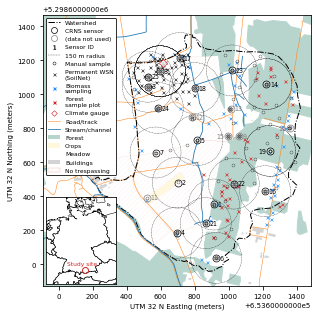

In [10]:
plt.rc('font', **{'size'   : 7})
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect("equal")

nogocolor= "#ec9488"
plt.rcParams['hatch.color'] = nogocolor
plt.rcParams['hatch.linewidth'] = 0.05
for i in range(len(nogo)):
    wradlib.vis.add_patches(ax, nogo[i], hatch="/////", facecolors="None", edgecolor=nogocolor, linewidth=0.1)
wradlib.vis.add_patches(ax, nogo2, hatch="/////", facecolors="None", edgecolor=nogocolor, linewidth=0.1)


wradlib.vis.add_patches(ax, crop, facecolors="cornsilk", edgecolor="None")

wradlib.vis.add_patches(ax, build, facecolors="lightgrey", edgecolor="None")

forestcolor='darkseagreen'
forestcolor='#b8d5cd'
for i in range(len(lut)):
    if lutkeys[i]=="forest":
        wradlib.vis.add_patches(ax, lut[i], color=forestcolor)


# Roads
wradlib.vis.add_lines(ax, roads, color='tab:orange', lw=0.5)
# Catchment
ls_catchment = "-."
wradlib.vis.add_lines(ax, catborders, color='black', lw=1., ls=ls_catchment)
# Streams/channels
wradlib.vis.add_lines(ax, water, color='tab:blue', lw=0.8)

biomasscolor="dodgerblue"
plt.plot(biomass.x, biomass.y, lw=0, marker="x", markersize=3, mew=0.6, mfc="None", mec=biomasscolor)
forestsamplecolor = "tab:red"
plt.plot(forestsampling.x, forestsampling.y, lw=0, marker="x", markersize=3, mew=0.6, mfc="None", mec=forestsamplecolor)


# CRNS
for id in attrs.index:
    usecrnscol = "black"
    if not attrs.loc[id].usedata:
        usecrnscol = "grey"
    else:
        circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 150, ls="dashed", facecolor="None", 
                        edgecolor="black", lw=0.3)
    ax.add_artist(circle)
    hassncol = "white"
    if id in [9,13,24,11,4,22,19,10,14]:
        hassncol = "white"
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=0, marker="o",
             markersize=7, mfc=hassncol, mec="None", alpha=0.3)
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=0, marker="o", mew=0.7, 
             markersize=7, mfc="None", mec=usecrnscol)
    if id >= 10:
        labeloffsetx = 44
    else:
        labeloffsetx = 32
    labeloffsety = 0
    if id in [10, 15, 19]:
        labeloffsetx = -labeloffsetx
    if id in []:
        labeloffsety = 20
    plt.text(attrs.loc[id,"x"]+labeloffsetx, attrs.loc[id,"y"]+labeloffsety, str(id), horizontalalignment="center", 
             verticalalignment="center", color=usecrnscol, fontsize=7, weight=550, 
             stretch= 'ultra-condensed')

samplecolor="black"
locs_with_data = ~((locs["FDR-readings (yes/no)"]=="no") & ( locs["cylinder samples (yes/no)"]=="no"))
for locid in locs.index[locs_with_data]:
    plt.plot(locs.loc[locid].x, locs.loc[locid].y, linewidth=0, marker="o", 
             markersize=3, mfc="white", mew=0.3, mec="None", alpha=0.2)    
    plt.plot(locs.loc[locid].x, locs.loc[locid].y, linewidth=0, marker="o", 
             markersize=3, mfc="None", mew=0.3, mec=samplecolor)
    
# Permanent SoilNet
color_PSN = "black"
plt.plot(soilnetxy[:,0], soilnetxy[:,1], linewidth=0, marker="x", ms=3, mew=0.5, color=color_PSN)#mfc="None", mec="black")

# Meteo
plt.plot(meteox, meteoy, marker="D", mec="None", mfc="white", mew=0.6, ms=6, alpha=0.8)
plt.plot(meteox, meteoy, marker="D", mec="tab:red", mfc="None", mew=0.6, ms=6)

plt.xlim(bboxxy[0][0]-300, bboxxy[0][1]+75)
plt.ylim(bboxxy[1][0]-70, bboxxy[1][1]+100)
#plt.grid()
ax.ticklabel_format(axis="x", useOffset=653600)
ax.ticklabel_format(axis="y", useOffset=5298600)
plt.xlabel("UTM 32 N Easting (meters)")
plt.ylabel("UTM 32 N Northing (meters)")

legend_elements = [plt.Line2D([0], [0], lw=1., ls=ls_catchment, color="black", label="Watershed"),
                   plt.Line2D([0], [0], marker="o",  ms=6, mec="black", mfc="white", mew=0.7,  lw=0, label="CRNS sensor"),
                   plt.Line2D([0], [0], marker="o",  ms=6, mec="grey", mfc="white", mew=0.7,  lw=0, label="(data not used)"),
                   plt.Line2D([0], [0], marker="$1$",  ms=4, mew=0.3, color="black", lw=0, label="Sensor ID"),
                   plt.Line2D([0], [0], lw=0.3, color="black", ls="--", label="150 m radius"), 
                   plt.Line2D([0], [0], marker="o", markersize=3, mfc="white", mew=0.5, mec=samplecolor, lw=0, label="Manual sample"),
                   plt.Line2D([0], [0], marker="x", ms=3,  mew=0.5, color=color_PSN, lw=0, label="Permanent WSN\n(SoilNet)"),
                   plt.Line2D([0], [0], marker="x", ms=3,  mec=biomasscolor, mfc="None", lw=0, label="Biomass\nsampling"),
                   plt.Line2D([0], [0], marker="x", ms=3,  mec=forestsamplecolor, mfc="None", lw=0, label="Forest\nsample plot"),
                   plt.Line2D([0], [0], marker="D", mec="tab:red", mfc="None", mew=0.6, ms=4, lw=0, label="Climate gauge"),
                   plt.Line2D([0], [0], lw=0.5, color="tab:orange", label="Road/track"),
                   plt.Line2D([0], [0], lw=0.8, color="tab:blue", label="Stream/channel"),
                   Patch(facecolor=forestcolor, edgecolor="None", label="Forest"),
                   Patch(facecolor="cornsilk", edgecolor="None", label="Crops"),
                   Patch(facecolor="white", edgecolor="None", label="Meadow"),
                   Patch(facecolor="lightgrey", edgecolor="None", label="Buildings"),
                   Patch(hatch="////", facecolor="None", edgecolor=nogocolor, linewidth=0.3, label="No trespassing")]
_ = ax.legend(handles=legend_elements, loc="upper left", framealpha=1., edgecolor="black", fontsize=6)
_.get_frame().set_linewidth(0.8)

axins = ax.inset_axes([0.012, 0.01, 0.26, 0.32])
wradlib.vis.add_lines(axins, eu, color='black', lw=0.5)
axins.plot(11.061903, 47.830175, marker="o", lw=0, ms=6, mfc="None", mec="tab:red")
axins.text(11.061903+2., 47.830175+0.5, "Study site", fontsize=6, horizontalalignment="right", color="tab:red")
debbox = delayer.GetExtent()
axins.set_xlim(debbox[0]-1., debbox[1]+1.)
axins.set_ylim(debbox[2]-1., debbox[3]+1.)
axins.tick_params(    
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

plt.savefig("figures/overviewmap.pdf", dpi=300, bbox_inches="tight")

### Reading grids for land use, biomass grid, soil

In [11]:
forestgdal =  wradlib.io.gdal.open_raster("data/aux/grids/forest.tif", driver="GTiff")
fgrid, fcoords, _ = wradlib.georef.raster.extract_raster_dataset(forestgdal)
fgrid[fgrid==255] = 0
#fcoords = fcoords[:-1,:-1]
fcoords[...,0] = fcoords[...,0] + 5.
fcoords[...,1] = fcoords[...,1] - 5.

In [12]:
fagbgdal =  wradlib.io.gdal.open_raster("data/aux/grids/forest_agb_irina.tif", driver="GTiff")
fagbgrid, fagbcoords, _ = wradlib.georef.raster.extract_raster_dataset(fagbgdal)
#fagbgrid[fagbgrid==255] = 0
fagbgrid = fagbgrid / 10. # from t/ha to kg/m2
#fagbcoords = fagbcoords[:-1,:-1]
fagbcoords[...,0] = fagbcoords[...,0] + 5.
fagbcoords[...,1] = fagbcoords[...,1] - 5.

In [13]:
# mean forest biomass
print("Avg. forest AGB: %.1f kg/m2" % np.nanmean(fagbgrid))

Avg. forest AGB: 24.4 kg/m2


In [14]:
soilgdal =  wradlib.io.gdal.open_raster("/media/x/cosmicsense/data/fendt/soil/uebk_minorg_openforest/minorg_openforest.tif", driver="GTiff")
sgrid, scoords, _ = wradlib.georef.raster.extract_raster_dataset(soilgdal)
sgrid[sgrid==255] = 0
scoords = scoords[:-1,:-1]
scoords[...,0] = scoords[...,0] + 5.
scoords[...,1] = scoords[...,1] - 5.

### Construct target grid

In [15]:
# Construct grid
delta = 10
xs = np.arange(bboxxy[0][0], bboxxy[0][1], delta)
ys = np.arange(bboxxy[1][0], bboxxy[1][1], delta)
xx, yy = np.meshgrid(xs, ys)
xxyy = np.array([xx.ravel(), yy.ravel()]).T
print("Grid shape:", xx.shape)

Grid shape: (143, 121)


### Or we take the grid specification which we got from the forest and soil grids

In [16]:
# xxyy = fcoords.reshape((-1,2))
# xx = fcoords[...,0]
# yy = fcoords[...,1]
xxyy = fagbcoords.reshape((-1,2))
xx = fagbcoords[...,0]
yy = fagbcoords[...,1]

### Retrieve grid indices of the catchment

In [17]:
# Create vertices for each grid cell
grdverts = wradlib.zonalstats.grid_centers_to_vertices(xx, yy, delta, delta)
zd = wradlib.zonalstats.ZonalDataPoly(grdverts, [catborders], srs=utm32n)
cat_ix = zd.get_source_index(0)

Warning 1: Layer src has no spatial index, DROP SPATIAL INDEX failed.
Warning 1: Layer trg has no spatial index, DROP SPATIAL INDEX failed.
Warning 1: Layer dst has no spatial index, DROP SPATIAL INDEX failed.


### Collecting meteo data

From DWD at Hohenpeißenberg:
- Precipitation: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_02290_akt.zip
- Temperature and humidity: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_02290_akt.zip
- Pressure: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_02290_akt.zip

In [18]:
f_prec = "data/dwd/stundenwerte_RR_02290_akt.txt"
prec = pd.read_csv(f_prec, sep=";", na_values=-999)
prec.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec.datetime = pd.to_datetime(prec.datetime, format="%Y%m%d%H")
prec = prec.set_index("datetime")

In [19]:
f_press = "data/dwd/stundenwerte_P0_02290_akt.txt"
press = pd.read_csv(f_press, sep=";", na_values=-999)
press.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press.datetime = pd.to_datetime(press.datetime, format="%Y%m%d%H")
press = press.set_index("datetime")

In [20]:
f_temphum = "data/dwd/stundenwerte_TU_02290_akt.txt"
temphum = pd.read_csv(f_temphum, sep=";", na_values=-999)
temphum.columns = ["station_id", "datetime", "quality", "temp2m", "relhum2m", "eor"]
temphum.datetime = pd.to_datetime(temphum.datetime, format="%Y%m%d%H")
temphum = temphum.set_index("datetime")

In [21]:
f_meteo = "data/meteo/2019_metDataDE-Fen.dat"
names = ["datetime","temp2m","press2m","relhum2m","windsp2m","winddir2m","swdownrad2m","lwdownrad2m","precip"]
meteo = pd.read_csv(f_meteo, sep=",", skiprows=2, names=names)
meteo.datetime = pd.to_datetime(meteo.datetime)
meteo = meteo.set_index("datetime")
meteo.index = meteo.index.tz_convert(None)

In [22]:
meteo["abshum2m"] = cs.conv.absolute_humidity(meteo.temp2m, meteo.relhum2m)
temphum["abshum2m"] = cs.conv.absolute_humidity(temphum.temp2m, temphum.relhum2m)

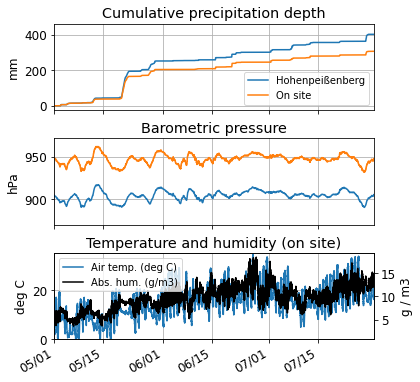

In [23]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=3, figsize=(6, 6), sharex=True)
ax = ax.ravel()

plt.sca(ax[0])
plt.plot(prec["2019-05-01":].index, prec["2019-05-01":].depth.cumsum(), label="Hohenpeißenberg")
plt.plot(meteo["2019-05-01":].index, meteo["2019-05-01":].precip.cumsum(), label="On site")
plt.grid() 
plt.title("Cumulative precipitation depth")
plt.legend(fontsize=10)
plt.ylabel("mm")
xlim = dt.datetime(2019,5,1), dt.datetime(2019,7,31)

plt.sca(ax[1])
plt.plot(press.index, press.p0, label="Hohenpeißenberg")
plt.plot(meteo.index, meteo.press2m, label="On site")
plt.grid()
plt.title("Barometric pressure")
plt.ylabel("hPa")

plt.sca(ax[2])
templ = plt.plot(meteo.index, meteo.temp2m, label="Air temp. (deg C)")
plt.grid()
plt.ylim(0,35)
plt.ylabel("deg C")
ax[2].set_xlim(xlim)
ax2 = ax[2].twinx()
abshumpl = plt.plot(meteo.index, meteo.abshum2m, color="black", label="Abs. hum. (g/m3)")
lns = templ+abshumpl
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, fontsize=10)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.title("Temperature and humidity (on site)")
plt.ylabel("g / m3")
plt.tight_layout()

fig.autofmt_xdate()

plt.savefig("figures/meteo.pdf", dpi=150, bbox_inches="tight")

In [24]:
from eto import ETo
et_pm = ETo()
et_hg = ETo()

meteoH = meteo.resample("1H").mean()
meteoH.columns = ['T_mean', 'P', 'RH_mean', 'U_2', 'winddir2m', 'R_s', 'lwdownrad2m', 'precip', 'abshum2m']
meteoH = meteoH[['R_s', 'T_mean', 'P', 'RH_mean', 'U_2']]
meteoH.R_s = meteoH.R_s * 3600e-6 # to MJ/m2 at hourly freq
meteoH.P = meteoH.P / 10 # hPa to kPa 
#meteoH.RH_mean = meteoH.RH_mean / 100 # from %

meteoD = meteo.resample("1D").mean()
meteoD.columns = ['T_mean', 'P', 'RH_mean', 'U_2', 'winddir2m', 'R_s', 'lwdownrad2m', 'precip', 'abshum2m']
meteoD = meteoD[['R_s', 'T_mean', 'P', 'RH_mean', 'U_2']]
meteoD.R_s = meteoD.R_s * 86400e-6 # to MJ/m2 at daily freq
meteoD.P = meteoD.P / 10 # hPa to kPa
meteoD["T_min"] = meteo.temp2m.resample("1D").min() 
meteoD["T_max"] = meteo.temp2m.resample("1D").max() 


et_pm.param_est(meteoH, freq="H", z_msl=500, lat=47.83289, lon=11.06073, TZ_lon=15)
eto_pm = et_pm.eto_fao()
et_hg.param_est(meteoD, freq="D", z_msl=500, lat=47.83289, lon=11.06073, TZ_lon=15)
eto_hg = et_hg.eto_hargreaves()
eto_pmD = et_hg.eto_fao()

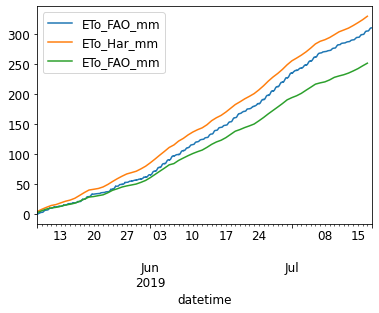

In [25]:
eto_pm["2019-05-08":"2019-07-17"].cumsum().plot()
eto_hg["2019-05-08":"2019-07-17"].cumsum().plot()
eto_pmD["2019-05-08":"2019-07-17"].cumsum().plot()
plt.legend()

# Read raw data

#### Read sensor data

In [26]:
fpath = "data/crns/stationary"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "crns_data_%d.txt" % id), sep="\t")
    df.datetime = [pd.to_datetime(dtime.strftime("%Y-%m-%d %H:%M:%S")) for dtime in pd.to_datetime(df.datetime, utc=None)]
    df = df.set_index("datetime")
    print("%d: %s to %s" % (id, df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-09 09:40:44 to 2019-07-17 06:39:00
2: 2019-05-07 11:02:13 to 2019-07-16 14:13:02
3: 2019-05-07 08:37:25 to 2019-07-16 11:26:00
4: 2019-05-07 15:21:29 to 2019-07-16 14:39:00
5: 2019-05-03 08:53:04 to 2019-07-19 09:29:00
6: 2019-05-03 09:34:48 to 2019-07-19 07:05:00
7: 2019-05-13 14:54:00 to 2019-07-19 09:20:00
8: 2019-05-01 00:06:02 to 2019-07-24 23:56:00
9: 2019-06-12 19:00:03 to 2019-07-20 23:53:31
10: 2019-06-03 20:00:04 to 2019-07-17 18:18:38
11: 2019-06-03 11:16:48 to 2019-07-20 23:43:40
12: 2019-06-03 16:00:04 to 2019-07-02 07:03:47
13: 2019-05-14 14:34:05 to 2019-07-21 23:48:09
14: 2019-05-08 06:45:44 to 2019-07-23 06:18:00
15: 2019-06-05 16:01:54 to 2019-07-23 09:08:00
16: 2019-05-14 13:45:00 to 2019-07-17 11:51:00
17: 2019-05-15 14:14:46 to 2019-07-17 07:06:00
18: 2019-05-14 10:16:06 to 2019-07-17 08:24:00
19: 2019-05-21 16:42:00 to 2019-07-17 12:25:00
21: 2019-05-13 13:38:38 to 2019-07-16 04:17:00
22: 2019-05-13 15:24:44 to 2019-07-15 09:45:00
23: 2019-05-15 15:42:2

In [27]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)
# Set max_dtime
max_dtime = dt.datetime(2019, 7, 23)

2019-05-01 00:06:02 - 2019-07-24 23:56:00


#### Applying the sensitivity correction factors

In [28]:
for id in crns.keys():
    crns[id]["cph1cal"] = crns[id]["moder_cph_filt"] / attrs.loc[id, "sensitivity"]

#### Read calibrator data

In [29]:
cal = pd.read_csv("data/crns/stationary/crns_data_20.txt", sep="\t")
cal.datetime = pd.to_datetime(cal.datetime)
cal = cal.set_index("datetime")
# Accounting for counts in both tubes
cal["cph1"] = (cal.counts1 + cal.counts2) / cs.conv.s_to_h(cal.nsecs1)

## Resample to uniform 20 minute interval

In [30]:
dtrange = pd.date_range('2019-05-01 00:00:00', max_dtime, freq="20T")
crns20 = pd.DataFrame({}, index=dtrange)

for i, key in enumerate(crns.keys()):
    limit = 1
    crns20[key] = crns[key].cph1cal.resample('20T').nearest(limit=limit).reindex(dtrange)

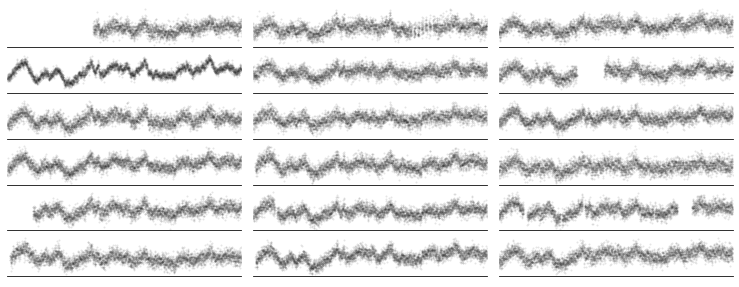

In [31]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(13,5.5), sharex=True)
ax=ax.ravel()
ids = np.array([1,2,3,4,5,6,7,8,14,16,17,18,19,21,22,23,24,25])
for i, id in enumerate(ids):
    plt.sca(ax[i])
    plt.plot(crns20.index, crns20[id], "ko", mfc="None", mec="black", ms=1, alpha=0.1)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
plt.xlim(dt.datetime(2019,5,15), dt.datetime(2019,7,15))

plt.subplots_adjust(wspace=0.05, hspace=0.15)

fig.autofmt_xdate() 

plt.savefig("figures/raw.png", dpi=300, bbox_inches="tight")

In [32]:
rovcal = pd.read_csv("data/crns/roving/analysis/UFZRover-Fendt-20190627-calibration-results.csv", sep=",")
rovcal.time = pd.to_datetime(rovcal.time)
rovcal.sensor = rovcal.sensor.astype("i4")
rovcal = rovcal.set_index("sensor")
rovcal

,time,comment,N_raw_mean,N_raw_std,N_raw_err
sensor,,,,,
9,2019-06-27 09:04:00+02:00,NaN,8815.939850,1709.708037,155.645815
15,2019-06-27 09:28:00+02:00,NaN,9688.543689,1910.340493,185.822775
13,2019-06-27 09:50:00+02:00,NaN,8283.130435,1828.508339,162.439846
23,2019-06-27 10:24:00+02:00,NaN,7738.348624,1674.723036,161.348484
17,2019-06-27 11:00:00+02:00,NaN,8712.000000,1706.098041,166.592042
18,2019-06-27 11:26:00+02:00,NaN,9421.782178,1764.005347,182.906226
8,2019-06-27 11:53:00+02:00,NaN,9211.376147,1719.682070,176.036612
3,2019-06-27 12:20:00+02:00,tablet restart,10014.803150,2032.634091,170.231153
25,2019-06-27 12:44:00+02:00,NaN,9769.541284,1964.770454,181.291662


In [33]:
from scipy.stats import sem, t
from scipy import mean

/tmp/ipykernel_86133/3046265242.py:10: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  x = crns20.loc[(dtime-halfwindow):(dtime+halfwindow),id].mean()
/tmp/ipykernel_86133/3046265242.py:11: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  x_err = stats.sem(crns20.loc[(dtime-halfwindow):(dtime+halfwindow),id], nan_policy="omit")
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)
/tmp/ipykernel_86133/3046265242.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0, 2000

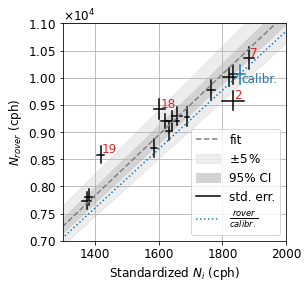

In [34]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(4, 4))
xlist = []
ylist = []
for i, id in enumerate(rovcal.index):
    if id in [9,10,11,13,15]:
        continue
    dtime = rovcal.loc[id, "time"].astimezone("utc")
    halfwindow = dt.timedelta(seconds=6*3600)
    x = crns20.loc[(dtime-halfwindow):(dtime+halfwindow),id].mean()
    x_err = stats.sem(crns20.loc[(dtime-halfwindow):(dtime+halfwindow),id], nan_policy="omit")
    y = rovcal.loc[id,"N_raw_mean"]
    plt.plot([x, x], [y-rovcal.loc[id, "N_raw_err"], y+rovcal.loc[id, "N_raw_err"]], "k-")
    plt.plot([x-x_err, x+x_err], [y, y], "k-")
    if id in [2,7,18,19]:
        plt.text(x+3, y+30, str(id), color="tab:red", fontsize=12)
    if (not id in [12]) and np.all(~np.isnan([x, y])):
        xlist.append(x)
        ylist.append(y)
xlist, ylist = np.array(xlist), np.array(ylist)
std_err = sem( ylist / xlist )
corr, _ = stats.pearsonr(xlist, ylist)
h = std_err * t.ppf((1 + 0.95) / 2, len(xlist) - 1)
ratio = np.mean( np.array(ylist) / np.array(xlist) )
plt.plot([0, 2000],[0, ratio*2000], "k-", color="grey", ls="--", label="fit")
plt.fill_between([0, 2000], y1=[0, 0.95*ratio*2000], y2=[0, 1.05*ratio*2000], alpha=0.4, 
                 color="lightgrey", label="$\pm 5\,\%$")
plt.fill_between([0, 2000], y1=[0, (ratio-h)*2000], y2=[0, (ratio+h)*2000], color="lightgrey", 
                 alpha=1, label="95% CI")
plt.plot([0,1],[0,1],"k-", label="std. err.")
plt.ylim(7000, 11000)
plt.xlim(1300, 2000)
plt.grid()

# Get the ratio from the comparison between rover and calibrator (which was situated at probe #24)
dtime = rovcal.loc[24, "time"].astimezone("utc")
cal_val = cal.loc[(dtime-halfwindow):(dtime+halfwindow),"cph1"].mean()
cal_val_err = stats.sem(cal.loc[(dtime-halfwindow):(dtime+halfwindow),"cph1"], nan_policy="omit")
rov_at_cal = rovcal.loc[24,"N_raw_mean"]
ratio_rov_cal = rov_at_cal / cal_val
ratio_rov_cal_err = stats.sem(cal.loc[(dtime-halfwindow):(dtime+halfwindow),"cph1"], nan_policy="omit")
rov_at_cal_err = rovcal.loc[24, "N_raw_err"]
#plt.plot(cal_val, rov_at_cal, "ko", color="tab:green", mfc="None", ms=7)
plt.plot([cal_val, cal_val], [rov_at_cal-rov_at_cal_err, rov_at_cal+rov_at_cal_err], "k-", color="tab:blue")
plt.plot([cal_val-cal_val_err, cal_val+cal_val_err], [rov_at_cal, rov_at_cal], "k-", color="tab:blue")
plt.text(cal_val+4, rov_at_cal-150, "calibr.", color="tab:blue", fontsize=12)

plt.plot([0, 2000],[0, ratio_rov_cal*2000], "k-", ls="dotted", color="tab:blue", label=r"$\frac{rover}{calibr.}$")
plt.xlabel("Standardized $N_i$ (cph)")
plt.ylabel("$N_{rover}$ (cph)")
plt.ticklabel_format(axis='y', style='sci', useMathText=True, scilimits=(-0,0))


plt.legend(fontsize=12)

plt.savefig("figures/probe_vs_rover.pdf", dpi=150, bbox_inches="tight")

In [35]:
print("fitted ratio(Rover/standardizedCRNS)=%.2f,\nratio(rover/calibrator)=%.2f" % (ratio, ratio_rov_cal))

fitted ratio(Rover/standardizedCRNS)=5.59,
ratio(rover/calibrator)=5.43


# Correcting for variations in incoming neutron flux

#### NMBD station data

`nmdb.txt` contains reference (background) neutron count rates from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL2`, `JUNG`, `JUNG1`, and `DRBS` (Dourbes, Belgium). 

In [36]:
# NMDB data
nmdb = pd.read_csv("data/crns/nmdb/nmdb.txt", sep=";", comment="#", na_values="   null")
nmdb = pd.read_csv("/media/x/cosmicsense/git/n0/data/nmdb.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

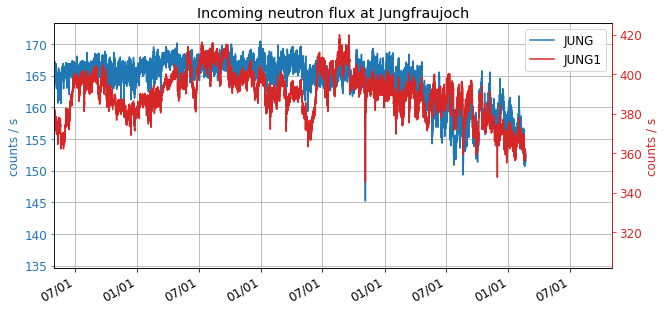

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 5))
jungcol = "tab:blue"
jung = plt.plot(nmdb.index, nmdb.JUNG, color=jungcol)
plt.ylabel("counts / s", color=jungcol)
ax1.spines['left'].set_color(jungcol)
ax1.tick_params(axis='y', colors=jungcol)
ax1.grid()

ax2 = ax1.twinx()
jung1col = "tab:red"
jung1 = plt.plot(nmdb.index, nmdb.JUNG1, color="tab:red")
plt.ylabel("counts / s", color=jung1col)
ax2.spines['right'].set_color(jung1col)
ax2.tick_params(axis='y', colors=jung1col)

leg = plt.legend(jung+jung1, ["JUNG", "JUNG1"])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Incoming neutron flux at Jungfraujoch")

fig.autofmt_xdate() 

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch (JUNG).

In [38]:
fi = (nmdb.JUNG / nmdb.JUNG.mean())
fi.name="fi"
fi = fi.resample("1H").mean().resample("20T").ffill().reindex(dtrange)
fi2 = (nmdb.JUNG1 / nmdb.JUNG1.mean())
fi2.name="fi2"
fi2 = fi2.resample("1H").mean().resample("20T").ffill().reindex(dtrange)

## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

For $p_0$, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ or the site average pressure, and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [39]:
p_0 = press.p0.mean()
L = 131.6 # g/cm2
fp = cs.core.corrfact_baro(press.p0, p_0, L)
fp = fp.resample("20T").ffill().reindex(dtrange)
fp.name="fp"

In [40]:
fp2 = cs.core.corrfact_baro(meteo.press2m, meteo.press2m.mean(), L)
fp2 = fp2.resample("20T").ffill().reindex(dtrange)
fp2.name="fp2"

## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

In [41]:
fwv2 = cs.core.corrfact_vapor_rosolem(meteo.abshum2m, h_ref=7.5479)
fwv2.name = "fwv2"
fwv2 = fwv2.resample("20T").ffill().reindex(dtrange)
fwv = cs.core.corrfact_vapor_rosolem(temphum.abshum2m, h_ref=7.5479)
fwv.name = "fwv"
fwv = fwv.resample("20T").ffill().reindex(dtrange)

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

In [42]:
factorcombined = fwv2 / (fi * fp2)

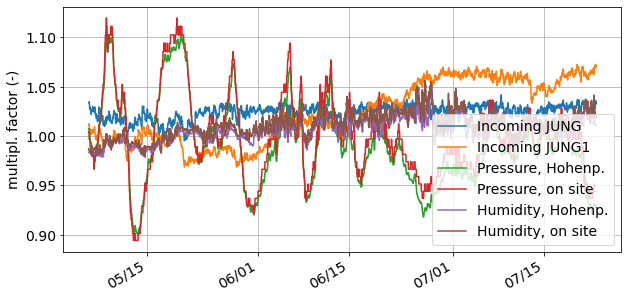

In [43]:
plt.rc('font', **{'size'   : 14})
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.plot(fi["2019-05-06":].index, fi["2019-05-06":], label="Incoming JUNG")
plt.plot(fi2["2019-05-06":].index, fi2["2019-05-06":], label="Incoming JUNG1")
plt.plot(fp["2019-05-06":].index, fp["2019-05-06":], label="Pressure, Hohenp.")
plt.plot(fp2["2019-05-06":].index, fp2["2019-05-06":], label="Pressure, on site")
plt.plot(fwv["2019-05-06":].index, fwv["2019-05-06":], label="Humidity, Hohenp.")
plt.plot(fwv2["2019-05-06":].index, fwv2["2019-05-06":], label="Humidity, on site")
plt.ylabel("multipl. factor (-)")
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.title("Correction factors")
plt.legend()#loc="lower left")
fig.autofmt_xdate() 

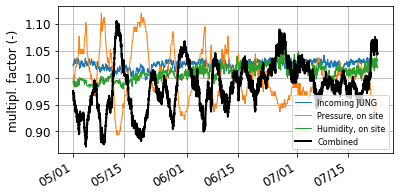

In [44]:
plt.rc('font', **{'size'   : 12})
fig = plt.figure(figsize=(6, 3))
plstart = "2019-05-01"
plend = "2019-07-22"
ax = plt.subplot(111)
plt.plot(fi[plstart:plend].index, fi[plstart:plend], lw=1, label="Incoming JUNG")
plt.plot(fp2[plstart:plend].index, fp2[plstart:plend], lw=1, label="Pressure, on site")
plt.plot(fwv2[plstart:plend].index, fwv2[plstart:plend],  lw=1, label="Humidity, on site")
plt.plot(factorcombined[plstart:plend].index, factorcombined[plstart:plend], lw=2, label="Combined", color="black")
plt.ylabel("multipl. factor (-)")
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.title("Correction factors")
plt.legend(loc="lower right", fontsize=8)
fig.autofmt_xdate()
plt.savefig("figures/corrfactors.png", dpi=300, bbox_inches="tight")

In [45]:
crns20c = crns20.copy()
for id in crns20c.keys():
    crns20c[id] = crns20c[id] * factorcombined

In [46]:
# Only use those probes which are reliable
crns20c = crns20c[attrs.index[attrs.hasdata & attrs.usedata]]

# Organize soil moisture campaign data

In [47]:
# From data repository
cyls = pd.read_table("data/soilmoisture/manual_sampling/theta_grav_BD_cylinder.txt", sep="\t")
cyls.columns = ['location_id', 'replicate', 'depth', 'theta', 'bd']
cyls["poro"] = 1 - (cyls.bd/2.65)
cyls["wfps"] = cyls.theta / cyls.poro
cyls["depthcorr"] = cyls["depth"]
depths = np.array([0,5,10,15,20,25,30])
# Force-homogenize measurement depth
for ix in cyls.index:
    depth = cyls.loc[ix, "depth"]
    if depth not in depths:
        cyls.loc[ix, "depthcorr"] = depths[np.argmin(np.abs(depth - depths))]        

In [48]:
fdr = pd.read_table("data/soilmoisture/manual_sampling/voltage_epsilon_theta_FDR.txt", sep="\t")
fdr.columns = ['location_id', 'depth', 'fdr1', 'fdr2', 'fdr3', 'time', 'device', 
               'remarks', 'volt1', 'volt2', 'volt3', 'epsilon1', 'epsilon2', 'epsilon3',
               'theta1', 'theta2', 'theta3', 'thetamean']
fdr.time = pd.to_datetime(fdr.time, utc=None)
# Force-homogenize measurement depth
fdr["depthcorr"] = fdr["depth"]
for ix in fdr.index:
    depth = fdr.loc[ix, "depth"]
    if depth not in depths:
        fdr.loc[ix, "depthcorr"] = depths[np.argmin(np.abs(depth - depths))]

In [49]:
fdr.time.min(), fdr.time.max()

(Timestamp('2019-06-25 09:30:00+0000', tz='UTC'),
 Timestamp('2019-06-26 17:50:00+0000', tz='UTC'))

### Relate CRNS locations to ground truth sampling locations

In [50]:
# Find the closest CRNS location for each sampling location
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(crnsxy)
nextdist, nextix = tree.query(np.array([locs.x, locs.y]).T, k=1)
locs["crnsid"] = attrs.index[nextix]
locs["crnsid_in10"] = locs["crnsid"]
locs.loc[nextdist>10, "crnsid_in10"] = 0

In [51]:
# Assign a cylinder location ID to each CRNS in attribute table
attrs["cylid"] = -9999
for locid in np.unique(cyls["location_id"]):
    #print(locid)
    attrs.loc[locs.loc[locid, "crnsid"], "cylid"] = locid
# Assign cylinder stats to each CRNS in attribute table
attrs["rhob"] = np.nan
attrs["theta"] = np.nan

### Reorganise profile data

In [52]:
thetaprofs = {}
bdprofs = {}
locs["type"] = ""
for locid in locs.index:
    if np.in1d(locid, cyls.location_id)[0]:
        # cylinder profile
        locs.loc[locid, "type"] = "cyl"
        sortix = np.array(np.argsort(cyls.loc[cyls.location_id==locid, "depth"]))
        deptharr = np.unique(np.array(cyls.loc[cyls.location_id==locid, "depth"])[sortix]).reshape((-1,1))
        bdarr = np.array(cyls.loc[cyls.location_id==locid, "bd"])[sortix].reshape((-1,2))
        thetaarr = np.array(cyls.loc[cyls.location_id==locid, "theta"])[sortix].reshape((-1,2))
        bdprofs[locid] = np.hstack((deptharr, bdarr, bdarr.mean(axis=1).reshape((-1,1))))
        thetaprofs[locid] = np.hstack((deptharr, thetaarr, thetaarr.mean(axis=1).reshape((-1,1))))
    elif np.in1d(locid, fdr.location_id)[0]:
        # Please note: we discard the FDR profile at a cylinder location!
        # FDR profile
        locs.loc[locid, "type"] = "fdr"
        sortix = np.array(np.argsort(fdr.loc[fdr.location_id==locid, "depth"]))
        thetaarr = np.array(fdr.loc[fdr.location_id==locid, ["depth", "theta1", "theta2", "theta3", "thetamean"]])[sortix]
        if not np.all(np.isnan(thetaarr[:,4])):
            thetaprofs[locid] = thetaarr
        else:
            locs.loc[locid, "type"] = "invalid"
    else:
        # No match
        locs.loc[locid, "type"] = "unknown"
        print("WARNING: location %d is neither FDR nor cylinder profile." % locid)   

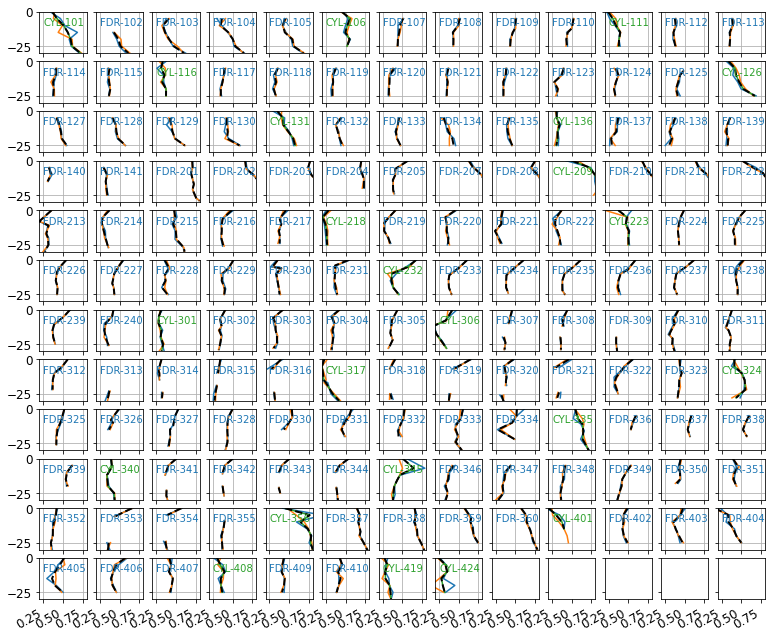

In [53]:
fig, ax = plt.subplots(nrows=12, ncols=13, figsize=(13,12), sharex=True, sharey=True)
ax = ax.ravel()
for i, key in enumerate(thetaprofs.keys()):
    try:
        depth = thetaprofs[key][:,0]
        if thetaprofs[key].shape[1] == 4:
            ax[i].plot(thetaprofs[key][:,1:4], -depth)
        else:
            ax[i].plot(thetaprofs[key][:,1:3], -depth)
        ax[i].plot(thetaprofs[key][:,-1], -depth, color="black", lw=2, ls="dashed")
        ax[i].set_ylim(-30,0)
        ax[i].set_xlim(0.2,0.8)
        ax[i].grid()
    except ValueError:
        print(key)

    if locs.loc[key, "type"] == "cyl":
        txtcol = "tab:green"
        txt = "CYL-%d" % key
    elif locs.loc[key, "type"] == "fdr":
        txtcol = "tab:blue"
        txt = "FDR-%d" % key
    else:
        txtcol = "tab:red"
        txt = "MISSING"
    if np.all(np.isnan(thetaprofs[key][:,-1])):
        txtcol = "tab:red"
       
    ax[i].text(0.25, -10, txt, fontsize=10, color=txtcol)

fig.autofmt_xdate() 

### Retrieve mean profiles and fit standard shape functions to profiles

In [54]:
def proffun2(depth, upper, lower):
    """Standard theta profile shape in Fendt    
    """
    y = upper + ((lower - upper)/30.) * depth
    return(y) 

In [55]:
def objfun(pars, proffun, obsprof, depths):
    fitprof = proffun(depths, *pars)
    return( np.sum((obsprof - fitprof)**2) )

In [56]:
def proffunth(depth, upper, lower, thresh=13.):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + ((lower - upper)/thresh) * depth
    minbd = min(upper, lower)
    maxbd = max(upper, lower)
    y[y > maxbd] = maxbd
    y[y < minbd] = minbd
    return(y)    

In [57]:
locs["theta0"] = np.nan
locs["theta30"] = np.nan
error = 0
for i, locid in enumerate(thetaprofs.keys()):
    ix = ~np.isnan(thetaprofs[locid][:,-1])
    optres = minimize(fun=objfun, x0=np.array([0.4, 0.5]), args=(proffunth, thetaprofs[locid][ix,-1],
                                                                 thetaprofs[locid][ix,0]))    
    locs.loc[locid, "theta0"] = optres["x"][0]
    locs.loc[locid, "theta30"] = optres["x"][1]
    error += optres["fun"]
print("Error = %.2f" % error)

Error = 0.84


/tmp/ipykernel_86133/1689608091.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1689608091.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1689608091.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1689608091.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1689608091.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1689608091.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1689608091.py:23: U

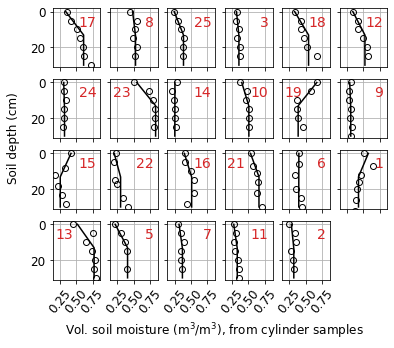

In [58]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(6,5), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="cyl"]):
    plt.sca(ax[i])
    ax[i].plot(thetaprofs[locid][:,-1], -thetaprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg prf")
    #ax[i].plot(np.nanmean(cyltheta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proffunth(plotdepths, *locs.loc[locid, ["theta0", "theta30"]].tolist()), -plotdepths, color="black", label="fitted")
    #ax[i].set_title(str(id))
    label = "%d" % attrs.id[attrs.cylid==locid]
    textx = 0.81
    if (int(attrs.id[attrs.cylid==locid])) in [13,19,21,23]:
        textx=0.45
    ax[i].text(textx,-8, label, fontsize=14, color="tab:red", horizontalalignment="right")
    ax[i].grid()
    plt.ylim(-31,2)
    #if i in [0, 6, 12, 18]:
    #    ax[i].set_ylabel("cm")
    #if i==0:
    #    ax[i].legend(loc="lower right", fontsize=6)
    plt.xticks(rotation=50)
    ax[i].set_yticklabels(["40","20","0","20"])
title = fig.suptitle(r"Vol. soil moisture (m$^3$/m$^3$), from cylinder samples", y=0.01, fontsize=12)
title = plt.figtext(x=0.02, y=0.4, s="Soil depth (cm)", fontsize=12, rotation=90)
#ax[-1].tick_params(labelbottom=False)
ax[-1].axis('off')
#fig.autofmt_xdate()

plt.savefig("figures/cyl_theta.pdf", dpi=150, bbox_inches="tight")

In [59]:
def proffunbd(depth, upper, lower, thresh=13.):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + ((lower - upper)/thresh) * depth
    minbd = min(upper, lower)
    maxbd = max(upper, lower)
    y[y > maxbd] = maxbd
    y[y < minbd] = minbd
    return(y)  

In [60]:
locs["bd0"] = np.nan
locs["bd30"] = np.nan
#locs["thresh"] = np.nan
error = 0
for i, locid in enumerate(bdprofs.keys()):
    ix = ~np.isnan(bdprofs[locid][:,-1])
    #optres = minimize(fun=objfun, x0=np.array([1.0, 1.0]), args=(proffun2, bdprofs[locid][ix,-1], bdprofs[locid][ix,0]))["x"]    
    optres = minimize(fun=objfun, x0=np.array([1.0, 1.5]),
                      args=(proffunbd, bdprofs[locid][ix,-1], bdprofs[locid][ix,0]))
    locs.loc[locid, "bd0"] = optres["x"][0]
    locs.loc[locid, "bd30"] = optres["x"][1]
    #locs.loc[locid, "thresh"] = optres["x"][2]
    error += optres["fun"]
    #print(optres["x"][2])
    #print("%d - Error (SSE) = %.2f" % (attrs.id[attrs.cylid==locid], optres["fun"]))
print("Error (SSE) = %.2f" % error)

Error (SSE) = 1.80


/tmp/ipykernel_86133/1478818898.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1478818898.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1478818898.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1478818898.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1478818898.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1478818898.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["40","20","0","20"])
/tmp/ipykernel_86133/1478818898.py:23: U

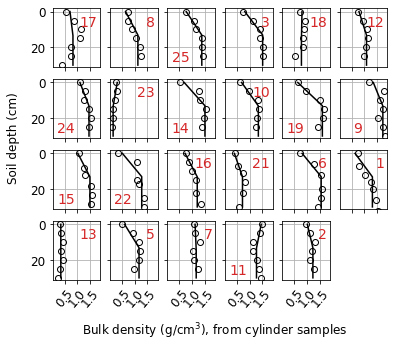

In [61]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(6,5), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="cyl"]):
    plt.sca(ax[i])
    ax[i].plot(bdprofs[locid][:,-1], -bdprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg prf.")
    ax[i].plot(proffunbd(plotdepths, *locs.loc[locid, ["bd0", "bd30"]].tolist()), -plotdepths, color="black", label="fitted")
    label = "%d" % attrs.id[attrs.cylid==locid]
    textx = 1.8
    texty = -8
    if (int(attrs.id[attrs.cylid==locid])) in [9, 11, 14, 15, 22, 19, 24, 25]:
        textx=0.9
        texty = -28
    ax[i].text(textx,texty, label, fontsize=14, color="tab:red", horizontalalignment="right")
    ax[i].grid()
    plt.ylim(-31,2)
    #if i in [0, 6, 12, 18]:
    #    ax[i].set_ylabel("cm")
    #if i==0:
    #    ax[i].legend(loc="lower right", fontsize=6)
    plt.xticks(rotation=50)
    ax[i].set_yticklabels(["40","20","0","20"])
title = fig.suptitle(r"Bulk density (g/cm$^3$), from cylinder samples", y=0.01, fontsize=12)
title = plt.figtext(x=0.02, y=0.4, s="Soil depth (cm)", fontsize=12, rotation=90)
#ax[-1].tick_params(labelbottom=False)
ax[-1].axis('off')
#fig.autofmt_xdate()

plt.savefig("figures/cyl_bd.pdf", dpi=150, bbox_inches="tight")

/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: U

/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: U

/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(["50","25","0","25"])
/tmp/ipykernel_86133/3857578512.py:16: U

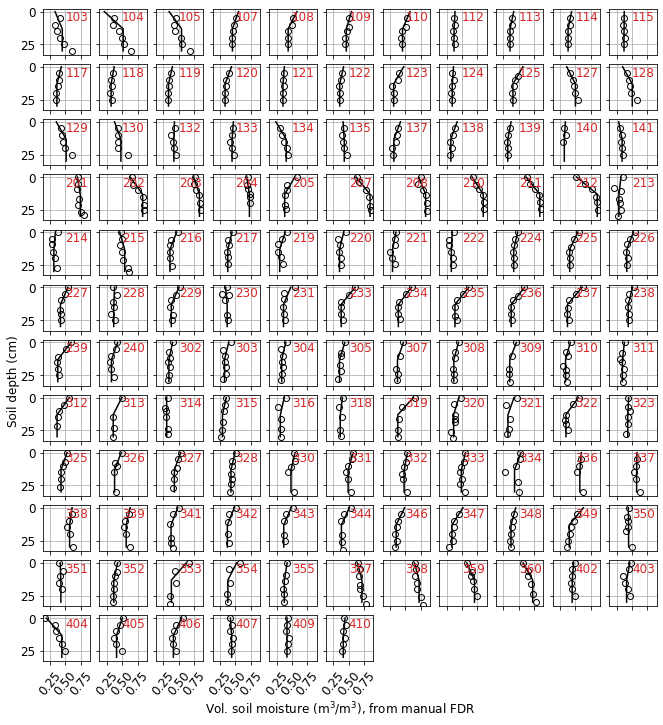

In [62]:
fig, ax = plt.subplots(nrows=12, ncols=11, figsize=(11,12), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="fdr"][1:]):
    plt.sca(ax[i])
    ax[i].plot(thetaprofs[locid][:,-1], -thetaprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg. prof.")
    #ax[i].plot(np.nanmean(cyltheta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proffunth(plotdepths, *locs.loc[locid, ["theta0", "theta30"]].tolist()), -plotdepths, color="black", label="fitted")
    #ax[i].set_title(str(id))
    #ax[i].text(.6,-28,str(locs.loc[locid,"crnsid_in10"]), fontsize=12, color="tab:red", horizontalalignment="left")
    ax[i].text(.5,-7,str(locid), fontsize=12, color="tab:red")
    ax[i].grid()
    plt.ylim(-33,2)
    #if i==0:
    #    ax[i].legend(loc="lower right", fontsize=8)
    ax[i].set_yticklabels(["50","25","0","25"])
    plt.xticks(rotation=50)
for i in range(-5,0):
    ax[i].axis('off')
title = fig.suptitle(r"Vol. soil moisture (m$^3$/m$^3$), from manual FDR", y=0.08, fontsize=12)
title = plt.figtext(x=0.08, y=0.4, s="Soil depth (cm)", fontsize=12, rotation=90)
plt.savefig("figures/fdr_theta.pdf", dpi=150, bbox_inches="tight")

In [63]:
# Find the closest CRNS location for each sampling location
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(crnsxy)

In [64]:
#locs["crnsid_in10"] = locs["crnsid"]
#locs["crnsid_in10"][nextdist>10] = 0

## Interpolation on a regular grid

In [65]:
krange_theta = 150.
krange_bd = 50.

In [66]:
# Organize input arrays for gridding
thetaix = ~np.isnan(locs.theta0)
# Discard FDR profiles in 10 m radius around probe except cylinders
thetaix = thetaix & ((locs.crnsid_in10==0) | (locs["type"]=="cyl"))
#thetaix = thetaix & (locs["type"]=="cyl")
bdix = ~np.isnan(locs.bd0) #np.array(locs[~np.isnan(locs.bd0)][["x", "y"]])
# Bulk density
bdxy = np.array(locs[bdix][["x", "y"]])
bdupper = np.array(locs[bdix].bd0)
bdlower = np.array(locs[bdix].bd30)
# Theta
thetaxy = np.array(locs[thetaix][["x", "y"]])
thetaupper = np.array(locs[thetaix].theta0)
thetalower = np.array(locs[thetaix].theta30)

In [67]:
# theta
ok = wradlib.ipol.OrdinaryKriging(thetaxy, xxyy, cov='1.0 Exp(%.1f)' % krange_theta, nnearest=30)
ip_thetaupper = ok(thetaupper)
ip_thetalower = ok(thetalower)
# bd
ok = wradlib.ipol.OrdinaryKriging(bdxy, xxyy, cov='1.0 Exp(%.1f)' % krange_bd, nnearest=15)
ip_bdupper = ok(bdupper)
ip_bdlower = ok(bdlower)

avgtheta_from_fit = np.array([proffunth(np.arange(0,30).reshape((-1,1)), ip_thetaupper[i], ip_thetalower[i]).mean(axis=0) for i in np.arange(len(ip_thetaupper))])
avgbd_from_fit = np.array([proffunbd(np.arange(0,30).reshape((-1,1)), ip_bdupper[i], ip_bdlower[i]).mean(axis=0) for i in np.arange(len(ip_bdupper))])

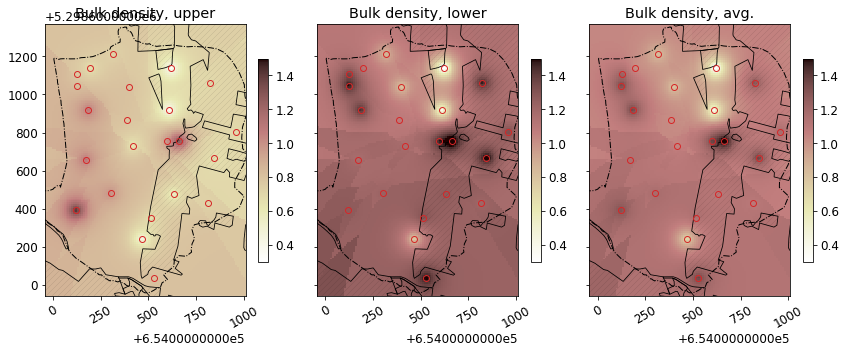

In [68]:
def plot_forest(ax):
    wradlib.vis.add_lines(ax, catborders, color='black', lw=1., ls=ls_catchment)
    for i in range(len(lut)):
        if lutkeys[i]=="forest":
            wradlib.vis.add_patches(ax, lut[i], hatch="////", facecolors="None", lw=0.8, edgecolors="black")


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
ax = ax.ravel()

vmin=0.3
vmax=1.5

cmap = plt.cm.pink_r

plt.sca(ax[0])
ax[0].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_bdupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Bulk density, upper")
#plt.grid()
plt.xticks(rotation=30)
plot_forest(ax[0])


plt.sca(ax[1])
ax[1].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_bdlower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Bulk density, lower")
#plt.grid()
plt.xticks(rotation=30)
plot_forest(ax[1])

plt.sca(ax[2])
ax[2].set_aspect("equal")
p = plt.pcolormesh(xx, yy, avgbd_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
#plt.grid()
plt.title("Bulk density, avg.")
plt.xticks(rotation=30)
plot_forest(ax[2])

plt.xlim(bboxxy[0][0]+150,bboxxy[0][1])
plt.ylim(bboxxy[1])

ax[2].ticklabel_format(axis="x", useOffset=654000)
ax[2].ticklabel_format(axis="y", useOffset=5298600)

plt.tight_layout()

plt.savefig("figures/bulk_density_ip.png", dpi=150, bbox_inches="tight")

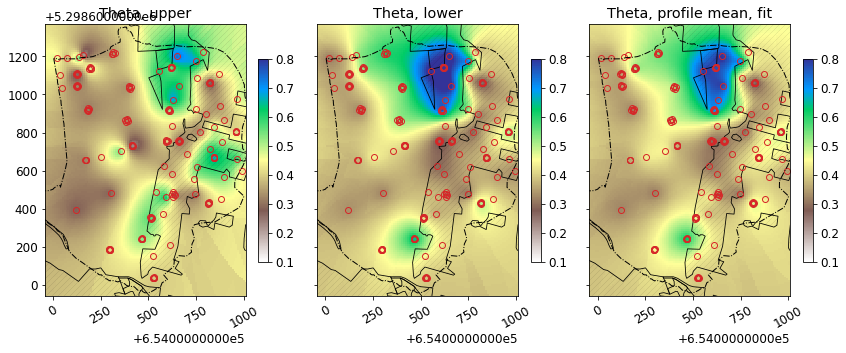

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
ax = ax.ravel()

vmin=0.1
vmax=0.8

cmap = plt.cm.terrain_r

plt.sca(ax[0])
ax[0].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_thetaupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Theta, upper")
plt.xticks(rotation=30)
#plt.grid()
plot_forest(ax[0])

plt.sca(ax[1])
ax[1].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_thetalower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Theta, lower")
plt.xticks(rotation=30)
#plt.grid()
plot_forest(ax[1])

plt.sca(ax[2])
ax[2].set_aspect("equal")
p = plt.pcolormesh(xx, yy, avgtheta_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
#plt.grid()
plt.title("Theta, profile mean, fit")
plt.xticks(rotation=30)
plot_forest(ax[2])


plt.xlim(bboxxy[0][0]+150,bboxxy[0][1])
plt.ylim(bboxxy[1])

ax[2].ticklabel_format(axis="x", useOffset=654000)
ax[2].ticklabel_format(axis="y", useOffset=5298600)

plt.tight_layout()

plt.savefig("figures/theta_ip.png", dpi=150, bbox_inches="tight")

In [70]:
depths = np.arange(0,30)

In [71]:
theta3d = np.array([proffunth(depths, ip_thetaupper[j], ip_thetalower[j]) for j in range(len(ip_thetalower))])
bd3d = np.array([proffunbd(depths, ip_bdupper[j], ip_bdlower[j]) for j in range(len(ip_thetaupper))])

# Soil water equivalent of $C_{org}$ and lattice water

In [72]:
soilanalysisfile = "data/soilmoisture/manual_sampling/OM_LW_texture_composite.txt"
sanalysis = pd.read_csv(soilanalysisfile, sep="\t")
sanalysis.columns = ['classstr', 'locids', 'nsamples', 'depth',
       'som', 'lattice', 'coarse', 'fine', 'sand', 'silt', 'clay']
sanalysis["classid"] = 0
sanalysis.loc[sanalysis.classstr=="min_open", "classid"] = 1
sanalysis.loc[sanalysis.classstr=="min_forest", "classid"] = 2
sanalysis.loc[sanalysis.classstr=="org_open", "classid"] = 3
sanalysis.loc[sanalysis.classstr=="org_forest", "classid"] = 4
sanalysis["weq"] = sanalysis.som*0.556 + sanalysis.lattice # water equivalent in g water/g dry 

In [73]:
def proffunweqmin(depth, upper=0.12, lower=0.06, thresh=20.):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + ((lower - upper)/thresh) * depth
    minbd = min(upper, lower)
    maxbd = max(upper, lower)
    y[y > maxbd] = maxbd
    y[y < minbd] = minbd
    return(y)

def proffunweqorg(depth, upper=0.27, lower=0.4, thresh=12.):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + (lower-upper)/(30.-thresh) * (depth-thresh)
    y[y<upper] = upper
    return(y) 

def proffunsommin(depths):
    return proffunweqmin(depths, upper=0.16, lower=0.05, thresh=15)

def proffunsomorg(depths):
    return proffunweqorg(depths, upper=0.42, lower=0.67, thresh=12.)

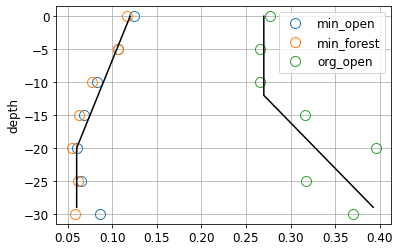

In [74]:
min_open = sanalysis.loc[sanalysis.classid==1, ["depth", "som", "lattice", "weq"]]
min_forest = sanalysis.loc[sanalysis.classid==2, ["depth", "som", "lattice", "weq"]]
org_open = sanalysis.loc[sanalysis.classid==3, ["depth", "som", "lattice", "weq"]]
plt.plot(min_open.weq, -min_open.depth, lw=0, ms=10, marker="o", mfc="None", label="min_open")
plt.plot(min_forest.weq, -min_forest.depth, lw=0, ms=10, marker="o", mfc="None", label="min_forest")
plt.plot(proffunweqmin(depths), -depths, color="black", ls="-")
plt.plot(org_open.weq, -org_open.depth,  lw=0, ms=10, marker="o", mfc="None", label="org_open")
plt.plot(proffunweqorg(depths), -depths, color="black", ls="-")

plt.legend()
plt.ylabel("depth")
plt.grid()

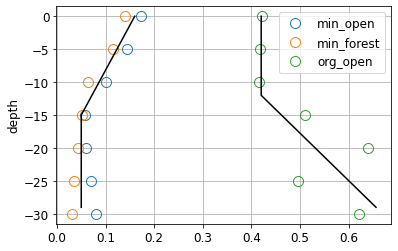

In [75]:
plt.plot(min_open.som, -min_open.depth, lw=0, ms=10, marker="o", mfc="None", label="min_open")
plt.plot(min_forest.som, -min_forest.depth, lw=0, ms=10, marker="o", mfc="None", label="min_forest")
plt.plot(proffunsommin(depths), -depths, color="black", ls="-")
plt.plot(org_open.som, -org_open.depth,  lw=0, ms=10, marker="o", mfc="None", label="org_open")
plt.plot(proffunsomorg(depths), -depths, color="black", ls="-")

plt.legend()
plt.ylabel("depth")
plt.grid()

In [76]:
# Assign min or org to sampling locs
locs["ismin"] = True
for item in attrs.index:
    locs.loc[locs.crnsid==item,"ismin"] = attrs.loc[item, "ismin"]

In [77]:
# Use the same locations for weq interpolation as we used for bulk density
weqxy = np.array(locs[bdix][["x", "y"]])
ok = wradlib.ipol.OrdinaryKriging(weqxy, xxyy, cov='1.0 Exp(%.1f)' % krange_bd, nnearest=23)
# 3d container
weq = np.zeros(bd3d.shape)
SOM = np.zeros(bd3d.shape)

for depthi in np.arange(0,30,5):
    print("Processing depth %d" % depthi)
    minweq = proffunweqmin(np.array([depthi]))[0]
    orgweq = proffunweqorg(np.array([depthi]))[0]
    weqdepthi = np.ones(len(weqxy)) * orgweq
    weqdepthi[locs.loc[bdix,"ismin"]] = minweq
    ip_weq_depthi = ok(weqdepthi)
    weq[:,depthi:depthi+5] = ip_weq_depthi.reshape((-1,1))

# Same for SOM only
for depthi in np.arange(0,30,5):
    print("Processing depth %d" % depthi)
    minsom = proffunsommin(np.array([depthi]))[0]
    orgsom = proffunsomorg(np.array([depthi]))[0]
    somdepthi = np.ones(len(weqxy)) * orgsom
    somdepthi[locs.loc[bdix,"ismin"]] = minsom
    ip_som_depthi = ok(somdepthi)
    SOM[:,depthi:depthi+5] = ip_som_depthi.reshape((-1,1))

Processing depth 0
Processing depth 5
Processing depth 10
Processing depth 15
Processing depth 20
Processing depth 25
Processing depth 0
Processing depth 5
Processing depth 10
Processing depth 15
Processing depth 20
Processing depth 25


In [78]:
thetaeq = weq * bd3d

# Compute bulk density and average soil moisture per CRNS probe

1. Initial guess theta and bulk density in CRNS footprint
2. Compute vertical weights for each grid cell in the cutoff radius
3. Compute vertical weighted average for each profile
4. Compute horizontal weights for each grid cell in the cuttoff radius
4. Compute horizontally weighted average
5. Iterate until theta and bulk density become converge (typically within 3 steps)

In [79]:
attrs = attrs.drop(index=[20])

In [80]:
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(xxyy)
ix = tree.query_ball_point(crnsxy, r=300)

In [81]:
# Required input vars: pressure, abs. hum., vegetation height
press_oncamp = press.p0["2019-06-25 09:00:00":"2019-06-26 17:00:00"].mean()
h_oncamp = temphum["2019-06-25 09:00:00":"2019-06-26 17:00:00"].abshum2m.mean()
Hveg = 0.

In [82]:
# Initial guess of theta in the footprint
attrs["thetaini"] = np.nan
attrs["bdini"] = np.nan
for i, id in enumerate(attrs.index):
    attrs.loc[id, "thetaini"] = avgtheta_from_fit[ix[i]].mean()
    attrs.loc[id, "bdini"] = avgbd_from_fit[ix[i]].mean()

In [83]:
attrs["thetaeq"] = 0.
attrs["som"] = 0.

In [84]:
maxiter = 5
for i, id in enumerate(attrs.index):   
    if not attrs.loc[id, "hasdata"]:
        continue
    print("Iterating for CRNS #%d..." % id)
    # Initial guess
    thetaguess = attrs.loc[id, "thetaini"]
    bdguess = attrs.loc[id, "bdini"]
    # 3-d grid of theta and bulk density in cutoff radius
    theta_vertgrd = theta3d[ix[i]]
    bd_vertgrd = bd3d[ix[i]]
    thetaeq_vertgrd = thetaeq[ix[i]]
    thetaeqguess = thetaeq_vertgrd.mean()
    thetaeff = thetaguess + thetaeqguess
    SOM_vertgrd = SOM[ix[i]]
    # Distances of grid cells to probe
    dists = cs.util.distance(crnsxy[i], xxyy[ix[i]])
    for iteri in range(maxiter):
        print("\ttheta=%.2f, bd=%.2f, thetaeq=%.2f, thetaeff=%.2f" % (thetaguess, bdguess, thetaeqguess, thetaeff) )
        # Vertical weights
        vweights = cs.core.vertical_weight_koehli(dists, depths, thetaeff, press_oncamp, Hveg, bdguess).T
        theta_vertavgs = np.sum(vweights * theta_vertgrd, axis=1) / np.sum(vweights, axis=1)
        bd_vertavgs = np.sum(vweights * bd_vertgrd, axis=1) / np.sum(vweights, axis=1 )
        thetaeq_vertavgs = np.sum(vweights * thetaeq_vertgrd, axis=1) / np.sum(vweights, axis=1 )
        hweights = cs.core.horizontal_weight_koehli(dists, press_oncamp, Hveg, thetaguess, h_oncamp) \
                   / (2 * np.pi * dists)
        hweights[dists>300] = 0
        thetaguess = np.sum(hweights * theta_vertavgs) / np.sum(hweights)
        bdguess = np.sum(hweights * bd_vertavgs) / np.sum(hweights)
        thetaeqguess = np.sum(hweights * np.sum(hweights * thetaeq_vertavgs) / np.sum(hweights)) / np.sum(hweights)
        thetaeff = thetaguess + thetaeqguess
    # Ex post from SOM, only
    SOM_vertavgs = np.sum(vweights * SOM_vertgrd, axis=1) / np.sum(vweights, axis=1 )
    SOMguess = np.sum(hweights * SOM_vertavgs) / np.sum(hweights)
        
        
    attrs.loc[id, "theta"] = thetaguess
    attrs.loc[id, "rhob"] = bdguess
    attrs.loc[id, "thetaeq"] = thetaeqguess
    attrs.loc[id, "thetaeff"] = thetaeff
    attrs.loc[id, "som"] = SOMguess
    

Iterating for CRNS #1...
	theta=0.41, bd=1.11, thetaeq=0.13, thetaeff=0.54
	theta=0.48, bd=0.94, thetaeq=0.11, thetaeff=0.59
	theta=0.48, bd=0.96, thetaeq=0.11, thetaeff=0.59
	theta=0.48, bd=0.95, thetaeq=0.11, thetaeff=0.59
	theta=0.48, bd=0.95, thetaeq=0.11, thetaeff=0.59
Iterating for CRNS #2...
	theta=0.39, bd=1.13, thetaeq=0.12, thetaeff=0.51
	theta=0.32, bd=1.07, thetaeq=0.12, thetaeff=0.45
	theta=0.33, bd=1.08, thetaeq=0.12, thetaeff=0.45
	theta=0.33, bd=1.08, thetaeq=0.12, thetaeff=0.45
	theta=0.33, bd=1.08, thetaeq=0.12, thetaeff=0.45
Iterating for CRNS #3...
	theta=0.42, bd=1.06, thetaeq=0.11, thetaeff=0.53
	theta=0.36, bd=1.05, thetaeq=0.12, thetaeff=0.47
	theta=0.36, bd=1.05, thetaeq=0.12, thetaeff=0.47
	theta=0.36, bd=1.05, thetaeq=0.12, thetaeff=0.47
	theta=0.36, bd=1.05, thetaeq=0.12, thetaeff=0.47
Iterating for CRNS #4...
	theta=0.41, bd=1.14, thetaeq=0.13, thetaeff=0.55
	theta=0.43, bd=0.99, thetaeq=0.13, thetaeff=0.56
	theta=0.43, bd=1.00, thetaeq=0.13, thetaeff=0.56


# Aboveground biomass for grassland

In [85]:
grass = pd.read_csv("data/biomass/grassland/Biomass.csv", sep="\t")
grass.columns = ['id', 'comment', 'date', 'fresheffect', 'dryeffect', 'freshmass', 'drymass', 'bwe', 'height']
grass.loc[grass.id=="21a","id"] = "21"
grass.loc[grass.id=="21b", "id"] = "21"
grass.id = grass.id.astype("int")
grass.date = [pd.to_datetime(item[0:10]) for item in grass.date]

# Correct for formatting inconstencies in the comment column
comments = []
for item in np.array(grass.comment):
    if type(item)==str:
        comments.append(item)
    else:
        comments.append("")
grass.comment = comments

# Identify sampling dates
grassdates = np.unique(grass.date)
print(grassdates)

# Reconstruct biomass on campaign date from samples before and after
weight1 = (dt.datetime(2019,6,25) - dt.datetime(2019,6,6)).total_seconds()
weight2 = (dt.datetime(2019,7,17) - dt.datetime(2019,6,25)).total_seconds()
weight1, weight2 = weight1/(weight1+weight2), weight2/(weight1+weight2)
drymass = np.array([])
loctypes = np.array([])
for grassid in biomass.id:
    val1 = grass.loc[(grass.id==grassid) & (grass.date==pd.to_datetime("2019-06-06"))]
    val2 = grass.loc[(grass.id==grassid) & (grass.date==pd.to_datetime("2019-07-17"))]
    tmp = float(val1.drymass)*weight1 + float(val2.drymass)*weight2
    drymass = np.append(drymass, tmp)
    if len(val1.comment.to_list() + val2.comment.to_list()) > 0:
        loctype = val1.comment.to_list()[0]
    else:
        loctype = ""
    loctypes = np.append(loctypes, loctype)
    #print("%d: %.1f, %.1f, %.1f (%s)" % (grassid, float(val1.drymass), float(val2.drymass), tmp, loctype))
drymass = drymass / 1000. # g to kg

['2019-05-14T00:00:00.000000000' '2019-05-15T00:00:00.000000000'
 '2019-05-16T00:00:00.000000000' '2019-06-06T00:00:00.000000000'
 '2019-06-07T00:00:00.000000000' '2019-07-17T00:00:00.000000000']


In [86]:
fagbgrid2 = fagbgrid.copy()
fagbgrid2[~np.isnan(fagbgrid)] = np.nanmean(fagbgrid)
fagbgrid2[np.isnan(fagbgrid)] = 0.

In [87]:
fagbgrid2.size, fagbcoords.shape, fagbcoords[...,0].size, 33264-33630, 189+176

(33630, (190, 177, 2), 33630, -366, 365)

In [88]:
isgrass = loctypes==""
islitter = loctypes=="Litter"
# Grassland
ok = wradlib.ipol.OrdinaryKriging(np.array(biomass.loc[isgrass, ["x","y"]]), xxyy, cov='1.0 Exp(%.1f)' % krange_bd, nnearest=30)
ip_grass = ok(drymass[isgrass])
drymassgrid = ip_grass.copy()
print("Average grassland dry weight: %.1f kg/m2" % np.nanmean(drymassgrid) )
#   forest
#forestbiomass = 24. # aboveground biomass on trees (kg/m2)
#drymassgrid[fgrid.ravel()==1] += forestbiomass 
drymassgrid += fagbgrid2.ravel()
forestdiff = (fagbgrid2 == 0) & (fgrid > 0)
drymassgrid[forestdiff.ravel()] += 5

Average grassland dry weight: 0.2 kg/m2


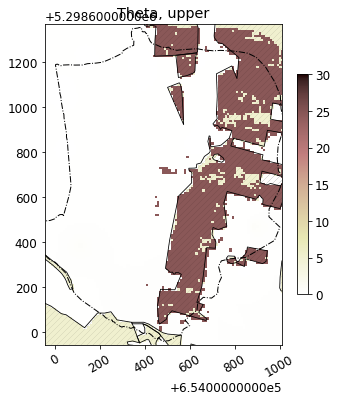

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,8), sharex=True, sharey=True)

vmin=0
vmax=30

cmap = plt.cm.pink_r

plt.sca(ax)
ax.set_aspect("equal")
p = plt.pcolormesh(xx, yy, drymassgrid.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.4)
#plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Theta, upper")
plt.xticks(rotation=30)
#plt.grid()
plot_forest(ax)

plt.xlim(bboxxy[0][0]+150,bboxxy[0][1])
plt.ylim(bboxxy[1])

ax.ticklabel_format(axis="x", useOffset=654000)
ax.ticklabel_format(axis="y", useOffset=5298600)

plt.tight_layout()

plt.savefig("figures/drymatter_ip.png", dpi=150, bbox_inches="tight")


# Total average aboveground drymass per CRNS footprint (incl. forest)

In [90]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
for i, id in enumerate(attrs.index[attrs.hasdata & attrs.usedata]):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, fcoords.reshape((-1,2)))
    w = cs.core.horizontal_weight_koehli(dist, press_oncamp, Hveg, attrs.loc[id,"thetaeff"], h_oncamp) / (2 * np.pi * dist)
    w[dist>=300] = 0 
    w[np.isnan(w)] = 0
    w = w / w.sum()
    #print("ID %d: %.2f" % (id, frac))
    attrs.loc[id, "forestfrac"] = np.sum(w * fgrid.ravel())    
    attrs.loc[id, "drymass"] = np.sum(w * drymassgrid.ravel())

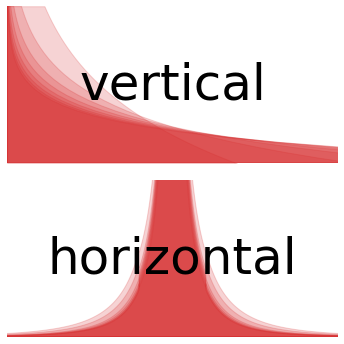

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,5))

myx = np.arange(1,301)
myx_ = np.concatenate((-myx[::-1], myx))
myy = np.arange(0,31)

plt.sca(ax[0])
for mytheta in np.arange(0.05, 0.8, 0.1):
    myvweights = cs.core.vertical_weight_koehli(100, myy, mytheta, 1000., 0, 1.5)
    myvweights = myvweights / myvweights.sum()
    plt.fill_betweenx(myy, myvweights, alpha=0.2, color="tab:red")
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[0].invert_yaxis() 
plt.xlim(0,0.1)
plt.ylim(0,30)
plt.text(0.05,15, "vertical", verticalalignment="center", horizontalalignment="center", 
         fontsize=50)
#plt.ylabel("depth (cm)")

plt.sca(ax[1])
for mytheta in np.arange(0.05, 0.8, 0.1):
    myhweights = cs.core.horizontal_weight_koehli(myx, 1000.0, 0, mytheta, 0.5) / (2 * np.pi * myx)
    myhweights = myhweights / myhweights.sum()
    myhweights = np.concatenate((myhweights[::-1], myhweights))
    plt.fill_between(myx_, myhweights, alpha=0.2, color="tab:red")
ax[1].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
plt.ylim(0,0.001)
plt.xlim(-250, 250)
#plt.xlabel("Distance (m)")
plt.text(0,0.001*0.5, "horizontal", verticalalignment="center", horizontalalignment="center", 
         fontsize=50)

plt.tight_layout()

for i, a in enumerate(ax):
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["bottom"].set_visible(False)
    a.spines["left"].set_visible(False)

plt.savefig("figures/vertical_horizontal.png", dpi=150, bbox_inches="tight")#, transparent=True)

# Calibrate the $N_0$ parameter

Volumetric soil moisture is estimated from a single relation that includes a local calibration parameter $N_0$. [Desilets et al. (2010)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009WR008726) suggested the following one:

\begin{equation*}
\theta = \Bigl(\frac{a_0}{\frac{N_{corr}}{N_0} - a_1} - a_2\Bigl) * \frac{\rho_b}{\rho_w}
\end{equation*}

While $a_0$, $a_1$ and $a_2$ are empirical parameters, soil bulk density $\rho_b$ can be measured or retrieved via transfer functions or literature, the density of water $\rho_w$ is a function of temperature and salinity, although the approximate value of 1000 kg/m3 is can be used without introducing much error as compared to other uncertainties.

The parameter $N_0$ depends on the local hydrogen pool and footprint, and needs to be obtained from calibration with gravimetric soil moisture measurements in the footprint at a defined point in time. For the time being, we just take a wild guess and set $N_0$ to 1500 cph.

**Consider the effect of vegetation**

In case we want to estimate one uniform calibration parameter, we have to assume that interfering hydrogen pools are homogeneous across space and time. In Fendt, we certainly have a strong difference in hydrogen pools between forest and grassland. In the following, we try to account for the *additional* biomass in thee forest as compared to grassland. Furthermore, we need to account for different fractions of forest in the different footprints. Combining the two, we can estimate the effective biomass for each footprint that comes on top of the typical grassland biomass.

Baatz et al. (2015) found (p. 2039)
> [...] a neutron intensity reduction of 0.9 % per kg of dry aboveground biomass per $m²$ [...]

In [92]:
biomasseffect = 0.9 # % per kg/ m2
# Apply correction
crns20c_vegc = crns20c.copy()
for id in attrs.index[attrs.hasdata & attrs.usedata]:
    crns20c_vegc[id] = crns20c_vegc[id] / (1 - attrs.loc[id, "drymass"] * biomasseffect / 100.)

In [93]:
caltimes = ["2019-06-25 08:00:00", "2019-06-26 18:00:00"]
ids4cal = np.array([1, 2, 3, 4, 5, 6, 7, 8, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25])
def objtheta_uniform(n0):
    error = np.array([])
    for id in attrs.index[attrs.hasdata & attrs.usedata & np.isfinite(attrs.N0)]:
        cphin = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id])
        rhob = attrs.loc[id, "rhob"] * 1000.
        obstheta = attrs.loc[id, "thetaeff"]
        x = cs.core.n_to_theta_desilets(cphin, n0, rhob=rhob)
        error = np.append(error, np.abs(obstheta - x) )
    return np.mean(error)#totalerror
singleopt = minimize_scalar(objtheta_uniform)
print(singleopt)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/cosmicsense-0.0.1.dev0-py3.9.egg/cosmicsense/core.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  return ((a0 / (n/n0 -a1)) - a2) * rhob / rhow


     fun: 0.05769689001679709
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 45
     nit: 26
 success: True
       x: 3581.5842285279873


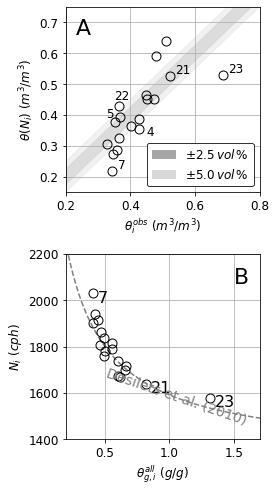

In [94]:
avgn0 = singleopt["x"]
d2summary = attrs[attrs.hasdata & attrs.usedata & np.isfinite(attrs.N0)].copy()
d2summary["theta_crns"] = np.nan
d2summary["eff_gravm_sm"] = np.nan
d2summary["corr_cph"] = np.nan

plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(4,7), nrows=2)
ax = ax.ravel()

plt.sca(ax[0])
plt.fill_between([0, 1], y1=[-0.025, 0.975], y2=[0.025, 1.025], alpha=0.7, color="lightgrey")
plt.fill_between([0, 1], y1=[-0.05, 0.95], y2=[0.05, 1.05], alpha=0.3, color="lightgrey")

for i, id in enumerate(ids4cal):
    tmp = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id])
    tmp1 = np.nanmean(crns20c_vegc.loc["2019-06-25 08:00:00":"2019-06-25 18:00:00", id])
    tmp2 = np.nanmean(crns20c_vegc.loc["2019-06-26 08:00:00":"2019-06-26 18:00:00", id])
    tmptheta = cs.core.n_to_theta_desilets(np.array([tmp, tmp1, tmp2]), n0=avgn0,
                                           rhob=attrs.loc[id, "rhob"]*1000)
    movex, movey = 0.04, 0.02
    if id in [4,5,7,21,22,23]:
        if id==4:
            movex, movey = .035, -0.01
        if id==5:
            movex, movey = -0.03, 0.01
        if id==7:
            movex, movey = 0.03, .02
        if id==22:
            movex, movey = 0.01, 0.03
        plt.text(attrs.theta[id]+movex, tmptheta[0]-attrs.thetaeq[id]+movey, str(id), color="black",
                 horizontalalignment='center', verticalalignment='center')
    plt.plot(attrs.theta[id], tmptheta[0]-attrs.thetaeq[id], "ko", ms=9, mec="black", mfc="None")
    d2summary.loc[id, "theta_crns"] = tmptheta[0]-attrs.thetaeq[id]
    d2summary.loc[id, "eff_gravm_sm"] = attrs.loc[id,"thetaeff"]/attrs.loc[id, "rhob"]
    d2summary.loc[id, "corr_cph"] = tmp
plt.grid()
plt.xlim(0.2, 0.8)    
plt.ylim(0.15, 0.75)
plt.xlabel(r"$\theta^{obs}_i~(m^3/m^3)$")
plt.ylabel(r"$\theta(N_i)~(m^3/m^3)$")
plt.text(0.23, 0.66, "A", fontsize=22)
#print("R2=%.3f" % np.corrcoef( d2summary.theta_crns, attrs.theta[ids4cal])[0,1]**2)
#print("min, max=%.3f, %.3f" % (np.min(attrs.theta[ids4cal]), 
#                                      np.max(attrs.theta[ids4cal])))
#print(np.round(d2summary.theta_crns - attrs.theta[ids4cal],3))

legend_elements = [Patch(facecolor="grey", edgecolor="None", alpha=0.7, label="$\pm 2.5\,vol\,\%$"),
                   Patch(facecolor="grey", edgecolor="None", alpha=0.3, label="$\pm 5.0\,vol\,\%$")]
_ = ax[0].legend(handles=legend_elements, loc="lower right", framealpha=1., edgecolor="black", fontsize=12)
_.get_frame().set_linewidth(0.8)

plt.sca(ax[1])
narr = np.arange(1400,2200)
plt.plot(cs.core.n_to_theta_desilets(narr, n0=avgn0, rhob=1000.), narr, color="grey", ls="dashed") 
    
for i, id in enumerate(ids4cal):
    tmp = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id])
    plt.plot(attrs.loc[id,"thetaeff"]/attrs.loc[id, "rhob"], tmp, ms=9, marker="o", mfc="None", mec="black")
    if id in [7, 21, 23]:
        plt.text(attrs.loc[id,"thetaeff"]/attrs.loc[id, "rhob"]+0.04, tmp-20, str(id), 
                 horizontalalignment='left', verticalalignment='center', fontsize=16)
plt.xlabel(r"$\theta_{g,i}^{all}~(g/g)$")
plt.ylabel(r"$N_i~(cph)$")
plt.grid()
plt.text(0.5, 1465, "Desilets et al. (2010)", rotation=-19, color="grey", fontsize=14)
plt.xlim(0.2, 1.7)
plt.ylim(1400, 2200)
plt.text(1.5, 2070, "B", fontsize=22)

plt.tight_layout()

plt.savefig("figures/n0_calibration.pdf", dpi=300, bbox_inches="tight")

# Mini-Monte-Carlo for universal $N_0$

In [95]:
nsamples = 1000
nprofiles = 18
depths = np.arange(0,30)
for i in attrs.index:
    print("Iterating for CRNS #%d..." % i)
    crnsloc = attrs.loc[i,["x","y"]].to_numpy().reshape((1,2))

    # bd
    tree = spatial.KDTree(bdxy)
    bdix = tree.query_ball_point(crnsloc, r=300)[0]
    print(len(bdix), end=",")
    bdprofs = np.array([proffunbd(depths, bdupper[j], bdlower[j]) for j in bdix])

    # theta
    tree = spatial.KDTree(thetaxy)
    thetaix = tree.query_ball_point(crnsloc, r=300)[0]
    print(len(thetaix))
    thetaprofs = np.array([proffunth(depths, thetaupper[j], thetalower[j]) for j in thetaix])

    thetamc = []
    bdmc = []
    for n in range(nsamples):
        # Random sampling
        bdselix = np.random.choice(np.arange(len(bdprofs)), len(bdprofs), replace=True)
        bdprofs_ = bdprofs[bdselix]
        bdxy_ = bdxy[bdix][bdselix]

        thetaselix = np.random.choice(np.arange(len(thetaprofs)), len(thetaprofs), replace=True)
        thetaprofs_ = thetaprofs[thetaselix]
        thetaxy_ = thetaxy[thetaix][thetaselix]


        # Initial guess of theta in the footprint
        thetaguess = thetaprofs_.mean()
        bdguess = bdprofs_.mean()
        thetaeq = attrs.at[i,"thetaeq"]
        thetaeff = thetaguess + thetaeq
        distsbd = cs.util.distance(crnsloc[0], bdxy_)
        dists = cs.util.distance(crnsloc[0], thetaxy_)

        for iteri in range(5):
#            print("\ttheta=%.2f, bd=%.2f, thetaeq=%.2f, thetaeff=%.2f" % (thetaguess, bdguess, thetaeq, thetaeff) )
            # Vertical weighting
            vweights = cs.core.vertical_weight_koehli(dists, depths, thetaeff, press_oncamp, Hveg, bdguess).T
            theta_vertavgs = np.sum(vweights * thetaprofs_, axis=1) / np.sum(vweights, axis=1)
            # Vertical weighting bulk density (other set of profiles)
            vweightsbd = cs.core.vertical_weight_koehli(distsbd, depths, thetaeff, press_oncamp, Hveg, bdguess).T
            bd_vertavgs = np.sum(vweightsbd * bdprofs_, axis=1) / np.sum(vweightsbd, axis=1 )
    #        thetaeq_vertavgs = np.sum(vweights * thetaeq_vertgrd, axis=1) / np.sum(vweights, axis=1 )
            # Horizontal weighting theta
            hweights = cs.core.horizontal_weight_koehli(dists, press_oncamp, Hveg, thetaguess, h_oncamp) \
                       / (2 * np.pi * dists)
            hweights[dists>300] = 0
            thetaguess = np.sum(hweights * theta_vertavgs) / np.sum(hweights)
            # Horizontal weighting bulk density
            hweightsbd = cs.core.horizontal_weight_koehli(distsbd, press_oncamp, Hveg, thetaguess, h_oncamp) \
                       / (2 * np.pi * distsbd)
            hweightsbd[distsbd>300] = 0

            bdguess = np.sum(hweightsbd * bd_vertavgs) / np.sum(hweightsbd)
    #        thetaeqguess = np.sum(hweights * thetaeq_vertavgs) / np.sum(hweights)
            thetaeff = thetaguess + thetaeq
        thetamc.append(thetaguess)
        bdmc.append(bdguess)
    attrs.at[i,"thetalci"] = np.quantile(thetamc, 0.025)
    attrs.at[i,"thetauci"] = np.quantile(thetamc, 0.975)
    attrs.at[i,"thetamean"] = np.mean(thetamc)
    attrs.at[i,"bdlci"] = np.quantile(bdmc, 0.025)
    attrs.at[i,"bduci"] = np.quantile(bdmc, 0.975)
    attrs.at[i,"nprofs"] = len(thetaix)

Iterating for CRNS #1...
4,14
Iterating for CRNS #2...
6,11
Iterating for CRNS #3...
6,12
Iterating for CRNS #4...
5,6
Iterating for CRNS #5...
8,15
Iterating for CRNS #6...
2,4
Iterating for CRNS #7...
6,8
Iterating for CRNS #8...
6,12
Iterating for CRNS #9...
7,27
Iterating for CRNS #10...
3,17
Iterating for CRNS #11...
3,3
Iterating for CRNS #12...
8,12
Iterating for CRNS #13...
8,24
Iterating for CRNS #14...
4,19
Iterating for CRNS #15...
7,26
Iterating for CRNS #16...
3,18
Iterating for CRNS #17...
5,10
Iterating for CRNS #18...
9,14
Iterating for CRNS #19...
6,27
Iterating for CRNS #21...
5,12
Iterating for CRNS #22...
7,21
Iterating for CRNS #23...
4,13
Iterating for CRNS #24...
7,14
Iterating for CRNS #25...
6,12


In [96]:
attrs[["theta","thetamean","thetalci","thetauci"]]

,theta,thetamean,thetalci,thetauci
id,,,,
1,0.478495,0.476103,0.392613,0.507014
2,0.326591,0.339823,0.296493,0.458913
3,0.357053,0.346341,0.334139,0.410146
4,0.426949,0.463467,0.350558,0.551725
5,0.367204,0.355007,0.309514,0.468459
6,0.403115,0.414866,0.393014,0.496020
7,0.343378,0.362607,0.339988,0.428262
8,0.452481,0.461750,0.344299,0.506875
9,0.343063,0.337145,0.300302,0.432473


# Export to $N_0$ analysis

In [97]:
# #id 	date 	theta 	N 	bd 	nprofs 	nmeas 	n0 	fname 	Nsim 	fi 	Nscaled 	weq 	thetaeff 	landuse
# cals = pd.DataFrame({"id":[], "date":[], "theta":[], "N":[], "bd":[], "nprofs":[], "nmeas":[], "n0":[], 
#                      "fname":[], "Nsim":[], "fi":[], "Nscaled":[], "weq":[], "thetaeff":[], "landuse":[]})
# for i in ids4cal:
#     x = attrs.loc[i]
#     Ncal = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], i])
#     calitem = pd.DataFrame({"id":["FENDT"+str(i)],
#                             "date":dt.datetime(2019,6,25),
#                             "theta":[x.theta],
#                             "N": [np.nan],
#                             "bd":[x.rhob*1000],
#                             "nprofs": [len(locs.index)],
#                             "nmeas": [500],
#                             "n0": [np.nan],
#                             "fname": ["FENDT"+str(i)],
#                             "Nsim": [26.7],
#                             "fi": [np.nan],
#                             "Nscaled": [Ncal*17.1/26.7],
#                             "weq":[x.thetaeq],
#                             "thetaeff":[x.thetaeff],
#                             "landuse": ["Cropland"]})
#     cals = pd.concat([cals, calitem], ignore_index=True)

# cals.to_csv("/media/x/cosmicsense/git/general-cal/data/fendt-caldata.csv", sep=";", index=False)
# # Export data for universal calibration study

In [98]:
x

1382.095930603393

In [100]:
cals = pd.DataFrame()

for i in ids4cal:
    x = attrs.loc[i]
    Ncal = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], i])
    landuse = "Grassland"
    if x.forestfrac > 0.2:
        landuse = "Forest"
    calitem = pd.DataFrame({"id":["FENDT"+str(i)],
                            "date":dt.datetime(2019,6,25,18,0,0),
                            "theta":[x.theta],
                            "bd":[x.rhob*1000],
                            "som": [np.nan],
                            "nprofs": [x.nprofs],
                            "nmeas": [int(x.nprofs)*6],
                            "Nr": [crns[i].loc[caltimes[0]:caltimes[1],"moder_cph_filt"].mean() ],
                            "N": [crns[i].loc[caltimes[0]:caltimes[1],"cph1cal"].mean() ],
                            "Nc": [crns20c.loc[caltimes[0]:caltimes[1],i].mean() ],
                            "Nvegc": [crns20c_vegc.loc[caltimes[0]:caltimes[1],i].mean() ],
                            "biomass": [attrs.at[i,"drymass"]],
                            "abshum": [meteo.loc[caltimes[0]:caltimes[1],"abshum2m"].mean()],
                            "fp": [fp2.loc[caltimes[0]:caltimes[1]].mean()],
                            "fwv": [fwv2.loc[caltimes[0]:caltimes[1]].mean()],
                            "fijung": [fi.loc[caltimes[0]:caltimes[1]].mean()],
                            "lon": [x.lon],
                            "lat": [x.lat],
                            "alt": [x.alt],
                            "phi": [(fwv2 / (fi * fp2)).loc[caltimes[0]:caltimes[1]].mean()],
                            "thetalci": [x.thetalci],
                            "thetauci": [x.thetauci],
                            "bdlci": [x.bdlci],
                            "bduci": [x.bduci],
                            #"fi": [17.1/26.7],
                            "fi": [17.1/x.parma],
                            #"Nscaled": [Ncal*17.1/26.7],
                            "Nscaled": [Ncal*17.1/x.parma],
                            "weq":[x.thetaeq],
                            "thetaeff":[x.thetaeff],
                            "landuse": [landuse],
                            "sensitivity": [attrs.at[i,"sensitivity"]],
                            "n0": [avgn0],
                            "fname": ["FENDT"+str(i)],
                            "Nsim": [x.parma]
                           })
    cals = pd.concat([cals, calitem], ignore_index=True)
cals.to_csv("/media/x/cosmicsense/git/general-cal/data/fendt-caldata.csv", sep=";", index=False)

In [103]:
crns[1].columns

Index(['rec_id', 'press1', 'temp1', 'relhum1', 'volt', 'counts1', 'nsecs1',
       'counts2', 'nsecs2', 'moder_cph_filt', 'cph1cal'],
      dtype='object')

In [99]:
attrs.columns

Index(['institution', 'type', 'lon', 'lat', 'hasdata', 'hascal', 'calstart',
       'calend', 'mincph', 'maxcph', 'sens_mq', 'sens_fendt', 'sensitivity',
       'sens_comment', 'usedata', 'N0', 'ismin', 'id', 'x', 'y', 'cylid',
       'rhob', 'theta', 'thetaini', 'bdini', 'thetaeq', 'som', 'thetaeff',
       'forestfrac', 'drymass'],
      dtype='object')

In [93]:
header="""# COLUMNS DESCRIPTORS
# id: Sensor ID acc. to JFC1 conventions
# institution: sensor owner
# type: sensor type
# lon: WGS84 longitude (deg)
# lat: WGS84 latitude (deg)
# x: UTM 32N Easting (m)
# y: UTM 32N Northing (m)
# sensitivity: sensitivity relative to calibrator (-)
# forestfrac: weighted fraction of forest cover in sensor footprint (-)
# drymass: weighted avg. dry biomass in sensor footprint (kg/m2)
# rhob: weighted avg. soil bulk density in sensor footprint (g/ccm)  
# theta: weighted avg. volum. soil moisture in sensor footprint (m3/m3)
# thetaeq: weighted avg. volum. soil moisture equivalent of SOC and lattice water in sensor footprint (m3/m3)
# thetaeff: "apparent" or "effective" theta equivalent of SM, SOC, and lattice water , i.e. theta + theta_eq (m3/m3)
# corr_cph: average corrected neutron count rates (in cph) during ground campaign ("2019-06-25 08:00:00" - "2019-06-26 18:00:00"])
# theta_crns: theta estimated from corr_cph (with N0=3744) minus thetaeq (m3/m3)
# eff_gravm_sm: apparent (or effective) gravimetric soil moisture (in g water/g dry soil) obtained from thetaeff / rhob, i.e. incl. SOM and lattics water
#
# FURTHER INFO
# abs. humidity of the air (from climate station) as avg. over the campaign: 11.2 g/m3
#
"""
summaryf = "calibration_summary.csv"
with open(summaryf, "w") as f:
    out = f.write(header)
d2summary[['institution', 'type', 'lon', 'lat', 'x', 'y', 'sensitivity',
          'forestfrac', 'drymass', 'rhob', "som", 'theta', 'thetaeq', 
          'thetaeff', "corr_cph", "theta_crns", "eff_gravm_sm"]].to_csv(summaryf,
                                                                        sep=";", mode="a", float_format="%.4f")


In [94]:
d2summary.id = d2summary.index
d2paper = d2summary[['id','forestfrac', 'drymass', 'rhob', "som", 'theta', 'thetaeq', "corr_cph", "theta_crns"]]
d2paper.loc[:,"forestfrac"] = (d2paper.forestfrac * 100).astype("i4")
d2paper.loc[:,"drymass"] = np.round(d2paper.drymass,1)
d2paper.loc[:,"rhob"] = np.round(d2paper.rhob,2)
d2paper.loc[:,"som"] = np.round(d2paper.som,2)
d2paper.loc[:,"theta"] = np.round(d2paper.theta,2)
d2paper.loc[:,"thetaeq"] = np.round(d2paper.thetaeq,2)
d2paper.loc[:,"corr_cph"] = (d2paper.corr_cph).astype("i4")
d2paper.loc[:,"theta_crns"] = np.round(d2paper.theta_crns,2)
d2paper = d2paper[["id","forestfrac","drymass","corr_cph","rhob","som","theta","thetaeq","theta_crns"]]
d2paper.columns = ["ID","Forest","AGB","N","rho_b","som",
                   "theta","thetasom+thetalw","theta(N)"]
d2paper.to_latex()
print(d2paper.to_latex(index=False))


\begin{tabular}{rrrrrrrrr}
\toprule
 ID &  Forest &   AGB &     N &  rho\_b &   som &  theta &  thetasom+thetalw &  theta(N) \\
  1 &      73 &  18.2 &  1775 &   0.96 &  0.15 &   0.48 &              0.11 &      0.52 \\
\midrule
  2 &       0 &   0.4 &  1959 &   1.06 &  0.15 &   0.34 &              0.12 &      0.31 \\
  3 &       0 &   0.1 &  1971 &   1.07 &  0.14 &   0.35 &              0.12 &      0.31 \\
  4 &       2 &   0.6 &  1867 &   1.01 &  0.17 &   0.43 &              0.13 &      0.38 \\
  5 &       0 &   0.4 &  1831 &   0.93 &  0.13 &   0.34 &              0.10 &      0.42 \\
  6 &      17 &   4.0 &  1880 &   1.07 &  0.15 &   0.40 &              0.12 &      0.40 \\
  7 &       0 &   0.2 &  2091 &   1.07 &  0.15 &   0.36 &              0.12 &      0.21 \\
  8 &       0 &   0.1 &  1789 &   0.92 &  0.14 &   0.45 &              0.10 &      0.48 \\
 14 &      92 &  20.8 &  1851 &   0.98 &  0.15 &   0.36 &              0.11 &      0.41 \\
 16 &       9 &   2.6 &  1843 &   0.96 &  0.

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Monte-Carlo experiment

In [95]:
# Uncertainty of ground truth interpolation
# Temporal variability of signal during ground-truth campaign
# Vegetation effect
# Sensor sensitivity

np.random.seed(101)

biomass_range = [0.8, 1.2]
sens_range = [0.98, 1.02]
weq_range = [0.8, 1.2]
loctheta_range = [-0.05, 0.05]
locbd_range = [0.8, 1.2]

n = 200

hours = np.random.uniform(0, 24, n)
mckrange_bd = np.random.uniform(25, 75, n)
mckrange_theta = np.random.uniform(75, 225, n)

samplesize_theta = int(thetaupper.shape[0]*0.8)
samplesize_bd = int(bdupper.shape[0]*0.8)
print("Subsampling sizes: %d (theta) and %d (bd)" % (samplesize_theta, samplesize_bd))

centertimes = [dt.datetime(2019,6,25,12) + dt.timedelta(hours=hour) for hour in hours]

n0s = np.array([])
errs = np.array([])

# Result containers
truethetadf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])
thetaeqdf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])
thetaeffdf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])
estthetadf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])
cphdf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])
truethetagrvdf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])
estthetagrvdf = pd.DataFrame(index=attrs.index[attrs.hasdata & attrs.usedata])

def montecarlo(mci):
    truethetadf[mci] = np.nan
    thetaeqdf[mci] = np.nan
    thetaeffdf[mci] = np.nan
    estthetadf[mci] = np.nan
    cphdf[mci] = np.nan
    truethetagrvdf[mci] = np.nan
    estthetagrvdf[mci] = np.nan
    
    # Subsampling
    thetasample = np.random.choice(np.arange(thetaupper.shape[0]), size=samplesize_theta, replace=False)
    bdsample = np.random.choice(np.arange(bdupper.shape[0]), size=samplesize_bd, replace=False)
    
    # INTERPOLATION -----------------------------------------------------------------------
    # theta
    #ok = wradlib.ipol.OrdinaryKriging(thetaxy, xxyy, cov='1.0 Exp(500.)', nnearest=10)
    ok = wradlib.ipol.OrdinaryKriging(thetaxy[thetasample,:], xxyy, cov='1.0 Exp(%.1f)' % mckrange_theta[mci], \
                                      nnearest=30)
    #ok = wradlib.ipol.Idw(thetaxy, xxyy, nnearest=10, p=1.5)
    adderror = np.random.uniform(loctheta_range[0], loctheta_range[1],len(thetasample))
    ip_thetaupper = ok(thetaupper[thetasample]+adderror)
    adderror = np.random.uniform(loctheta_range[0], loctheta_range[1],len(thetasample))
    ip_thetalower = ok(thetalower[thetasample]+adderror)
    # bd
    ok = wradlib.ipol.OrdinaryKriging(bdxy[bdsample,:], xxyy, cov='1.0 Exp(%.1f)' % mckrange_bd[mci], nnearest=15)
    multerror = np.random.uniform(locbd_range[0], locbd_range[1],len(bdsample))
    ip_bdupper = ok(bdupper[bdsample]*multerror)
    multerror = np.random.uniform(locbd_range[0], locbd_range[1],len(bdsample))
    ip_bdlower = ok(bdlower[bdsample]*multerror)
    
    depths = np.arange(0,30)
    theta3d = np.array([proffunth(depths, ip_thetaupper[j], ip_thetalower[j]) for j in range(len(ip_thetalower))])
    bd3d = np.array([proffunbd(depths, ip_bdupper[j], ip_bdlower[j]) for j in range(len(ip_thetaupper))])
    
    # SOIL WATER EQUIVALENTS
    # Use the same locations for weq interpolation as we used for bulk density
    weqxy = bdxy[bdsample,:]
    ok = wradlib.ipol.OrdinaryKriging(weqxy, xxyy, cov='1.0 Exp(%.1f)' % mckrange_bd[mci], nnearest=15)
    # 3d container
    weq = np.zeros(bd3d.shape)

    for depthi in np.arange(0,30,5):
        minweq = proffunweqmin(np.array([depthi]))[0]
        orgweq = proffunweqorg(np.array([depthi]))[0]
        weqdepthi = np.ones(len(weqxy)) * orgweq
        # DISTURB AT ORG LOCS
        weqdepthi = weqdepthi * np.random.uniform(weq_range[0], weq_range[1], len(weqdepthi))
        # DISTURB AT MIN LOCS
        minlocs = np.array(locs.ismin[bdix])[bdsample]
        minlocslen = len(np.where(minlocs)[0])        
        weqdepthi[minlocs] = minweq * np.random.uniform(weq_range[0], weq_range[1], minlocslen)
        ip_weq_depthi = ok(weqdepthi)
        weq[:,depthi:depthi+5] = ip_weq_depthi.reshape((-1,1))
    
    thetaeq = weq * bd3d
    
    # AVERAGE THETA IN FOOTPRINT -----------------------------------------------------------
    # Initial guess of theta in the footprint
    attrs_cp = attrs.copy()
    attrs_cp["thetaini"] = np.nan
    attrs_cp["bdini"] = np.nan
    for i, id in enumerate(attrs_cp.index):
        attrs_cp.loc[id, "thetaini"] = avgtheta_from_fit[ix[i]].mean()
        attrs_cp.loc[id, "bdini"] = avgbd_from_fit[ix[i]].mean()
    
    attrs_cp["thetaeq"] = 0.

    maxiter = 5
    for i, id in enumerate(attrs_cp.index):   
        if not attrs_cp.loc[id, "hasdata"]:
            continue
        # Initial guess
        thetaguess = attrs_cp.loc[id, "thetaini"]
        bdguess = attrs_cp.loc[id, "bdini"]
        theta_vertgrd = theta3d[ix[i]]
        bd_vertgrd = bd3d[ix[i]]
        thetaeq_vertgrd = thetaeq[ix[i]]
        thetaeqguess = thetaeq_vertgrd.mean()
        thetaeff = thetaguess + thetaeqguess
        # Distances of grid cells to probe
        dists = cs.util.distance(crnsxy[i], xxyy[ix[i]])

        for iteri in range(maxiter):
            vweights = cs.core.vertical_weight_koehli(dists, depths, thetaeff, press_oncamp, Hveg, bdguess).T
            theta_vertavgs = np.sum(vweights * theta_vertgrd, axis=1) / np.sum(vweights, axis=1)
            bd_vertavgs = np.sum(vweights * bd_vertgrd, axis=1) / np.sum(vweights, axis=1 )
            thetaeq_vertavgs = np.sum(vweights * thetaeq_vertgrd, axis=1) / np.sum(vweights, axis=1 )
            hweights = cs.core.horizontal_weight_koehli(dists, press_oncamp, Hveg, thetaguess, h_oncamp) \
                       / (2 * np.pi * dists)
            hweights[dists>300] = 0
            thetaguess = np.sum(hweights * theta_vertavgs) / np.sum(hweights)
            bdguess = np.sum(hweights * bd_vertavgs) / np.sum(hweights)
            thetaeqguess = np.sum(hweights * np.sum(hweights * thetaeq_vertavgs) / np.sum(hweights)) / np.sum(hweights)
            thetaeff = thetaguess + thetaeqguess

        attrs_cp.loc[id, "theta"] = thetaguess
        attrs_cp.loc[id, "rhob"] = bdguess
        attrs_cp.loc[id, "thetaeq"] = thetaeqguess
        attrs_cp.loc[id, "thetaeff"] = thetaeff
        
    
    # AVERAGE BIOMASS IN FOOTPRINT------------------------------------------------------------------------
    for i, id in enumerate(attrs_cp.index[attrs_cp.hasdata & attrs_cp.usedata]):
        dist = cs.util.distance(np.array([attrs_cp.loc[id,"x"], attrs_cp.loc[id,"y"]]).T, fcoords.reshape((-1,2)))
        w = cs.core.horizontal_weight_koehli(dist, press_oncamp, Hveg, attrs_cp.loc[id,"thetaeff"], h_oncamp) / (2 * np.pi * dist)
        w[dist>=300] = 0 
        w[np.isnan(w)] = 0
        w = w / w.sum()   
        attrs_cp.loc[id, "drymass"] = np.sum(w * drymassgrid.ravel()) * \
                                      np.random.uniform(biomass_range[0], biomass_range[1],1)[0]
        
    
    # N_0 CALIBRATION -----------------------------------------------------------------------------
    
    biomasseffect = 0.9 # % per kg/ m2
    # Apply correction
    crns20c_vegc = crns20c.copy()
    for id in attrs_cp.index[attrs_cp.hasdata & attrs_cp.usedata]:
        crns20c_vegc[id] = np.random.uniform(sens_range[0], sens_range[1],1)[0] * \
                           crns20c_vegc[id] / (1 - attrs_cp.loc[id, "drymass"] * biomasseffect / 100.)

    halfwin = dt.timedelta(hours=6)
    caltimes = [(centertimes[mci]-halfwin).strftime("%Y-%m-%d %H:%M:%S"),
                (centertimes[mci]+halfwin).strftime("%Y-%m-%d %H:%M:%S")]

    def objtheta_uniform(n0):
        error = np.array([])
        for id in attrs_cp.index[attrs_cp.hasdata & attrs_cp.usedata & np.isfinite(attrs_cp.N0)]:
            #if id in [23,7]:
            #    continue
            cphin = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id])
            rhob = attrs_cp.loc[id, "rhob"] * 1000.
            obstheta = attrs_cp.loc[id, "thetaeff"]
            #print(id, optres.fun, optres.x)
            x = cs.core.n_to_theta_desilets(cphin, n0, rhob=rhob)
            error = np.append(error, np.abs(obstheta - x) )
        return np.mean(error)
   
    singleopt = minimize_scalar(objtheta_uniform)
    
    for i, id in enumerate(attrs_cp.index[attrs_cp.hasdata & attrs_cp.usedata]):
        cphin = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id])
        estthetadf.loc[id, mci] = cs.core.n_to_theta_desilets(cphin, n0=singleopt["x"], 
                                                              rhob=attrs_cp.loc[id, "rhob"]*1000) - attrs_cp.loc[id, "thetaeq"]
        truethetadf.loc[id, mci] = attrs_cp.loc[id, "theta"]
        thetaeqdf.loc[id, mci] = attrs_cp.loc[id, "thetaeq"]
        cphdf.loc[id, mci] = cphin
        truethetagrvdf.loc[id, mci] = attrs_cp.loc[id, "thetaeff"] / attrs_cp.loc[id, "rhob"]
        estthetagrvdf.loc[id, mci] = cs.core.n_to_theta_desilets(cphin, n0=singleopt["x"], rhob=1000.) / attrs_cp.loc[id, "rhob"]    
    
    
    return singleopt
for i in range(n):
    out = montecarlo(i)
    n0s = np.append(n0s, out["x"])
    errs = np.append(errs, out["fun"])
    print("%d: %.0f (%.4f)" % (i, n0s[i], errs[i]))

Subsampling sizes: 52 (theta) and 18 (bd)


/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice.
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/cosmicsense-0.0.1.dev0-py3.7.egg/cosmicsense/core.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  return ((a0 / (n/n0 -a1)) - a2) * rhob / rhow


0: 3671 (0.0879)
1: 3649 (0.0701)
2: 3647 (0.0762)
3: 3680 (0.0667)
4: 3734 (0.0471)
5: 3735 (0.0817)
6: 3714 (0.0613)
7: 3707 (0.0688)
8: 3777 (0.0864)
9: 3657 (0.0767)
10: 3759 (0.0758)
11: 3696 (0.0756)
12: 3673 (0.0806)
13: 3705 (0.0591)
14: 3727 (0.0897)
15: 3689 (0.0671)
16: 3664 (0.0791)
17: 3693 (0.0817)
18: 3652 (0.0822)
19: 3663 (0.0698)
20: 3668 (0.0710)
21: 3652 (0.0586)
22: 3722 (0.0786)
23: 3671 (0.0723)
24: 3671 (0.0793)
25: 3758 (0.0854)
26: 3678 (0.0670)
27: 3705 (0.0743)
28: 3733 (0.0610)
29: 3704 (0.0612)
30: 3729 (0.0705)
31: 3682 (0.0711)
32: 3691 (0.0624)
33: 3635 (0.0968)
34: 3708 (0.0541)
35: 3716 (0.0749)
36: 3746 (0.0803)
37: 3681 (0.0686)
38: 3633 (0.0951)
39: 3697 (0.0828)
40: 3739 (0.0630)
41: 3702 (0.0611)
42: 3711 (0.0561)
43: 3724 (0.0763)
44: 3672 (0.0809)
45: 3734 (0.0634)
46: 3655 (0.0818)
47: 3632 (0.0867)
48: 3651 (0.0934)
49: 3711 (0.0633)
50: 3646 (0.0823)
51: 3658 (0.0574)
52: 3765 (0.0718)
53: 3622 (0.0793)
54: 3660 (0.0698)
55: 3720 (0.0716)
56

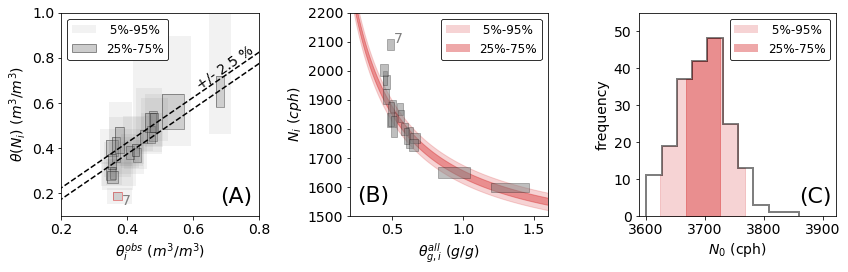

In [96]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(12,4), ncols=3)
ax = ax.ravel()

labelfontsize = 22

inner = [0.25, 0.75]
inner2 = [0.05, 0.95]
bestix = np.argmin(errs)
plt.sca(ax[0])
plt.plot([0,1], [0.025,1.025], ms=0, color="black", ls="--", label="5 %")
plt.plot([0,1], [-0.025,0.975], ms=0, color="black", ls="--", label="_tmp")
perccontx = np.zeros((len(ids4cal),2)) # container for inter-quartile range
percconty = np.zeros((len(ids4cal),2)) # container for inter-quartile range
for i, id in enumerate(ids4cal):
    bottom, top = np.quantile(estthetadf.loc[id], inner)#estthetadf.loc[id].min()
    left, right = np.quantile(truethetadf.loc[id], inner)#truethetadf.loc[id].min()
    perccontx[i] = [left, right]
    percconty[i] = [bottom, top]
    bottom2, top2 = np.quantile(estthetadf.loc[id], inner2)#estthetadf.loc[id].min()
    left2, right2 = np.quantile(truethetadf.loc[id], inner2)#truethetadf.loc[id].min()
    rect = patches.Rectangle((left,bottom),right-left,top-bottom, edgecolor='None',
                             facecolor='grey', alpha = 0.3)
    rect2 = patches.Rectangle((left2,bottom2),right2-left2,top2-bottom2, edgecolor='None',
                             facecolor='grey', alpha = 0.1)
    edgecolor="black"
    alpha=0.7
    if id==7:
        edgecolor="tab:red"
        alpha=1.
    rect_ = patches.Rectangle((left,bottom),right-left,top-bottom, lw=0.5, edgecolor=edgecolor,
                             facecolor='None', alpha = alpha)
    ax[0].add_patch(rect)
    ax[0].add_patch(rect2)
    ax[0].add_patch(rect_)
    if id in [7]:
        plt.text(right, bottom, str(id), 
                 horizontalalignment='left', verticalalignment='center', fontsize=14, color="grey")
plt.xlim(0.2, .8)    
plt.ylim(0.1, 1)
plt.xlabel(r"$\theta^{obs}_i~(m^3/m^3)$")
plt.ylabel(r"$\theta(N_i)~(m^3/m^3)$")
shifter = 1.2
plt.text(0.5*shifter, 0.55*shifter, "+/- 2.5 %", rotation=35, color="black", fontsize=14)
plt.text(0.68, 0.16, "(A)", fontsize=labelfontsize)


legend_elements = [Patch(facecolor="grey", edgecolor="None", alpha=0.1, label=" 5%-95%"),
                   Patch(facecolor="grey", edgecolor="black", alpha=0.4, label="25%-75%")]
_ = ax[0].legend(handles=legend_elements, loc="upper left", framealpha=1., edgecolor="black", fontsize=12)
_.get_frame().set_linewidth(0.8)


plt.sca(ax[1])
narr = np.arange(1400,2400)
thetaarr = np.zeros((n, len(narr)))
for i in range(n):
    thetaarr[i] = cs.core.n_to_theta_desilets(narr, n0=n0s[i], rhob=1000.)

x1, x2 = np.quantile(thetaarr, inner2, axis=0)
plt.fill_betweenx(narr, x1=x1, x2=x2, color="tab:red", alpha=0.2)
x1, x2 = np.quantile(thetaarr, inner, axis=0)
plt.fill_betweenx(narr, x1=x1, x2=x2, color="tab:red", alpha=0.4)
for i, id in enumerate(attrs.index[attrs.hasdata & attrs.usedata & np.isfinite(attrs.N0)]):
    bottom, top = np.quantile(cphdf.loc[id], inner)
    left, right = np.quantile(truethetagrvdf.loc[id], inner)

    rect = patches.Rectangle((left,bottom),right-left,top-bottom, lw=0.5, edgecolor="black",
                             facecolor='grey', alpha = 0.5)
    ax[1].add_patch(rect)

    if id in [7]:
        plt.text(right, top, str(id), 
                 horizontalalignment='left', verticalalignment='center', fontsize=14, color="grey")
plt.xlabel(r"$\theta_{g,i}^{all}~(g/g)$")
plt.ylabel(r"$N_i~(cph)$")
plt.xlim(0.2, 1.6)
plt.ylim(1500, 2200)
plt.text(0.25, 1550, "(B)", fontsize=labelfontsize)

legend_elements = [Patch(facecolor="tab:red", edgecolor="None", alpha=0.2, label=" 5%-95%"),
                   Patch(facecolor="tab:red", edgecolor="None", alpha=0.4, label="25%-75%")]
_ = ax[1].legend(handles=legend_elements, loc="upper right", framealpha=1., edgecolor="black", fontsize=12)
_.get_frame().set_linewidth(0.8)



plt.sca(ax[2])

lown0, highn0 = np.quantile(n0s, inner2)

tmp = plt.hist(n0s, color="black", lw=2, alpha=0.5, histtype="step")
mask = (tmp[1]>=lown0) & (tmp[1]<=highn0)
mask[np.where(mask)[0][-1]+1] = True
x_ = tmp[1][mask]
y_ = tmp[0][mask[1:]]
x_[-1] = highn0
x_ = np.concatenate([[lown0], x_])
y_ = np.concatenate([[y_[0]]    , y_])
plt.fill_between(x_,y_, step="pre", color="tab:red", alpha=0.2)

lown0, highn0 = np.quantile(n0s, inner)
mask = (tmp[1]>=lown0) & (tmp[1]<=highn0)
mask[np.where(mask)[0][-1]+1] = True
x_ = tmp[1][mask]
y_ = tmp[0][mask[1:]]
x_[-1] = highn0
x_ = np.concatenate([[lown0], x_])
y_ = np.concatenate([[y_[0]]    , y_])
plt.fill_between(x_,y_, step="pre", color="tab:red", alpha=0.4)

plt.xlabel(r"$N_0$ (cph)")
plt.ylabel("frequency")

plt.ylim(0,55)
plt.xlim(ax[2].get_xlim()[0], ax[2].get_xlim()[1]+50)
plt.text(3860., 3.5, "(C)", fontsize=labelfontsize)

_ = ax[2].legend(handles=legend_elements, loc="upper right", framealpha=1., edgecolor="black", fontsize=12)
_.get_frame().set_linewidth(0.8)


plt.tight_layout()

plt.savefig("figures/n0_calibration_montecarlo.pdf", dpi=300, bbox_inches="tight")

In [97]:
#for i in range(len(perccontx)):
#    print(perccontx[i].round(3), percconty[i].round(3))
iqrdiffsx = (perccontx[:,1] - perccontx[:,0])
iqrdiffsy = (percconty[:,1] - percconty[:,0])
print(r"Avg. theta obs uncertainty:",iqrdiffsx.mean().round(3), "\n"
      "Avg. theta(N) uncertainty:",iqrdiffsy.mean().round(3))

Avg. theta obs uncertainty: 0.028 
Avg. theta(N) uncertainty: 0.082


# Construct gridded series of theta from calibrated CRNS

In [98]:
# Static setup
ids = np.array([1,2,3,4,5,6,8,14,16,17,18,19,21,22,23,24,25])
srcxy = np.array(attrs.loc[ids,["x","y"]])

In [99]:
h24 = crns20c_vegc[ids].rolling("24H", min_periods=int(3*24*0.8)).mean()
h24.index = h24.index - dt.timedelta(seconds=12*3600)
h24 = h24["2019-05-01 00:00:00":]

In [100]:
crnstheta = h24.apply(copy.deepcopy)
for id in ids:
    crnstheta[id] = cs.core.n_to_theta_desilets(h24[id].copy(), n0=avgn0, rhob=attrs.loc[id, "rhob"]*1000) - attrs.thetaeq[id] 

In [101]:
#exportf = "/home/maik/b2drop/cosmicsense/inbox/fendt/products/mc/theta_from_crns_single_probes_uniform_n0/theta_from_crns_24_rollingmean_uniform_n0.v0_1.data.csv"
#crnstheta.to_csv(exportf, sep=";", float_format="%.3f", index_label="datetime_utc", na_rep="nan")

In [102]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
allw = np.zeros((len(ids), len(xxyy)))
for i, id in enumerate(ids):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist) / (2 * np.pi * dist)
    w[dist>300] = 0
    allw[i] = w

In [103]:
startdate = "2019-05-14"
enddate = "2019-07-15"
sli = crnstheta[startdate:enddate][ids].resample("24H", loffset=dt.timedelta(hours=24)).mean()
vals = np.zeros((len(sli),len(xxyy)))
for i in range(len(sli)):
    print(".", end="")
    tmp = np.array(sli.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    # THIS OPTION USES THE WEIGHTING FUNCTION
#    vals[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)
    # THIS OPTION USES ORDINARY KRIGING
    okopt = wradlib.ipol.OrdinaryKriging(srcxy[goodix], xxyy, cov='1.0 Exp(300.)', nnearest=len(np.where(goodix)[0]))
    vals[i] = okopt(tmp[goodix]).ravel()

...............................................................

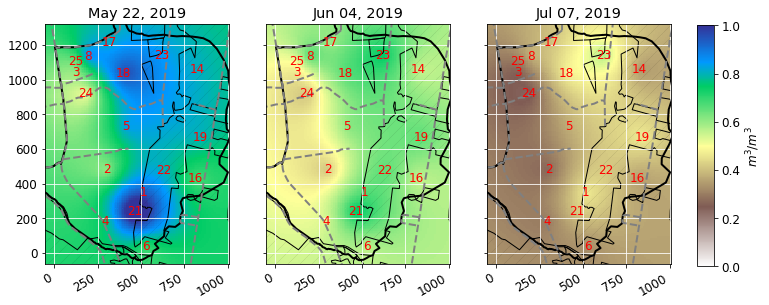

In [104]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5), sharey=True, sharex=True)
#ax = ax.ravel()

def decorate(ax, title):
    for id in ids:
        text_object = ax.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                                   ha='center', va='center', color="red")
    wradlib.vis.add_lines(ax, catborders, color='black', lw=2)
    wradlib.vis.add_lines(ax, roads, color='grey', ls="dashed", lw=2)
    for i in range(len(lut)):
        if lutkeys[i]=="forest":
            wradlib.vis.add_patches(ax, lut[i], hatch="//", facecolors="None")
    ax.ticklabel_format(axis="x", useOffset=654000)
    ax.grid(color="white")
    #tstamp = ax.set_title("")
    #cb = plt.colorbar(quad1, shrink=0.5)
    #cb.set_label("Theta (%)")
    plt.xlim(xx.min()+350, xx.max()-350)
    plt.ylim(yy.min()+250, yy.max()-250)
    plt.title(title)
    ax.ticklabel_format(axis="y", useOffset=5298600)
    plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
    plt.setp(ax.get_yaxis().get_offset_text(), visible=False)

wetdate = dt.datetime(2019,5,22,0,0)
mediumdate = dt.datetime(2019,6,4,0,0)
drydate = dt.datetime(2019,7,7,0,0)
ixwet = np.where(sli.index==wetdate)[0][0]
ixmedium = np.where(sli.index==mediumdate)[0][0]
ixdry = np.where(sli.index==drydate)[0][0]

vmin = 0.
vmax = 1.

ax[0].set_aspect("equal")
plt.sca(ax[0])
axi=0
quad1 = ax[0].pcolormesh(xx, yy, vals[ixwet].reshape(xx.shape), vmin=vmin, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
decorate(ax[axi], title=wetdate.strftime("%b %d, %Y"))

axi = 1
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixmedium].reshape(xx.shape), vmin=vmin, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
decorate(ax[axi], title=mediumdate.strftime("%b %d, %Y"))


axi = 2
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixdry].reshape(xx.shape), vmin=vmin, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
decorate(ax[axi], title=drydate.strftime("%b %d, %Y"))

fig.autofmt_xdate() 

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.67])
cb = plt.colorbar(quad1, orientation="vertical", cax=cbar_ax)#use_gridspec=False, ax=ax)
cb.set_label("$m^3/m^3$")

plt.savefig("figures/mapsseries_wet_medium_dry.png", dpi=300, bbox_inches="tight")

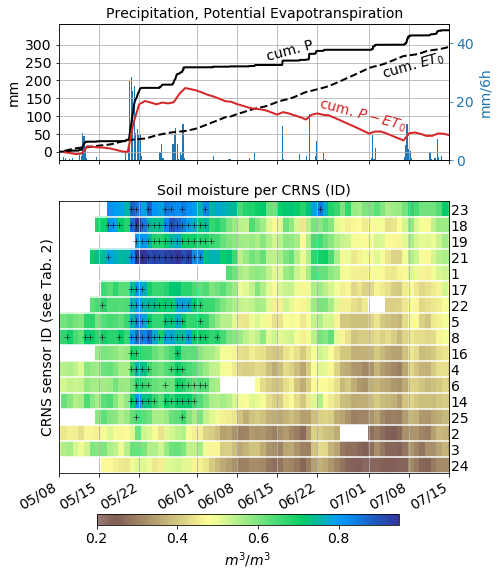

In [105]:
plt.rc('font', **{'size'   : 14})

mycolors = plt.cm.tab20(np.linspace(0,1,len(ids)))

#fig, ax = plt.subplots(nrows=3, figsize=(7,9), sharex=True)
fig = plt.figure(figsize=(7, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 3]) 

xlim = (dt.datetime(2019,5,8), dt.datetime(2019,7,15))

plstart = xlim[0].strftime("%Y-%m-%d")
plend = xlim[1].strftime("%Y-%m-%d")

axi=0
ax = plt.subplot(gs[axi])
plt.sca(ax)
plt.title("Precipitation, Potential Evapotranspiration", fontsize=14)
plprec = plt.plot(prec[plstart:plend].index, prec[plstart:plend].depth.cumsum(), color="black", lw=2, label="P (cum.)")
tmpeto = eto_pm[plstart:plend].resample("24H", loffset=dt.timedelta(hours=24)).sum()
plt.plot(tmpeto.index, tmpeto.cumsum(), color="black", lw=2, ls="--", label="$ET_0$ (cum.)")
balance = prec[plstart:plend].depth.resample("24H", loffset=dt.timedelta(hours=24)).sum() \
          - eto_pm[plstart:plend].resample("24H", loffset=dt.timedelta(hours=24)).sum()
plt.plot(balance.index, balance.cumsum(), linewidth=2, color="tab:red",  label="$P - ET_0$ (cum.)")
plt.ylabel("mm")
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(xlim)
plt.yticks(np.arange(0, 350, 50))
plt.text(dt.datetime(2019,6,13),255,"cum. P", rotation=15)
plt.text(dt.datetime(2019,6,22),60,"cum. $P - ET_0$", color="tab:red", rotation=-15)
plt.text(dt.datetime(2019,7,3),205,"cum. $ET_0$", rotation=16 )

ax2 = ax.twinx()
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2, label="Precipitation (6 hrs)")
ax2.set_ylabel("mm/6h", color="tab:blue")
ax2.spines['left'].set_color("tab:blue")
ax2.tick_params(axis='y', colors="tab:blue")

ax.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2
ax.patch.set_visible(False) # hide the 'canvas'


axi = 1
ax = plt.subplot(gs[axi])
plt.sca(ax)
plt.title(r"Soil moisture per CRNS (ID)", fontsize=14)
sortix = np.argsort(np.array(crnstheta.loc["2019-07-08":"2019-07-15", ids].mean()))
tmp = crnstheta[ids].iloc[:,sortix].resample("24H", loffset=dt.timedelta(hours=12)).mean()
x_lims = tmp.index[0], tmp.index[-1]
x_lims = mdates.date2num(x_lims)

# Manipulate terrain colormap
from matplotlib.colors import LinearSegmentedColormap
interval = np.linspace(0.2,1)#np.hstack([np.linspace(0, 0.3), np.linspace(0.7, 1)])
mymapcols = plt.cm.terrain_r(interval)
mycmap = LinearSegmentedColormap.from_list('name', mymapcols)

pm = plt.imshow(tmp.T, extent = [x_lims[0], x_lims[1],  0, len(ids)], aspect="auto", origin="lower",
           vmin=0.2, vmax=0.95, cmap=mycmap)#plt.cm.terrain_r)

plt.grid()
for i, id in enumerate(ids[sortix]):
    tmpix = np.where(~np.isnan(crnstheta[id]))[0][0]
    labeltime = crnstheta.index[tmpix]#+dt.timedelta(hours=24)
    labeltime = np.max([labeltime, xlim[0]+dt.timedelta(hours=12)])
    labeltime = dt.datetime(2019,7,14,18)
    if id==23:
        textcolor="black"
    else:
        textcolor="black"
    plt.text(labeltime+dt.timedelta(hours=12), i+0.4, str(id), color=textcolor, 
             horizontalalignment="left", verticalalignment="center")
    plt.hlines(i, xmin=dt.datetime(2019,4,1), xmax=dt.datetime(2019,8,1), color="white")
    tmpix = np.where(tmp[id] > (1 - (attrs.loc[id,"rhob"]/2.65))*1.05)[0]
    plt.plot(tmp.index[tmpix], np.repeat(i+0.5, len(tmpix)),"k+", mew=0.5)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.get_yaxis().set_ticks([])
plt.ylabel("CRNS sensor ID (see Tab. 2)")
plt.xlim(xlim)
fig.autofmt_xdate()

fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.02])
cb = plt.colorbar(pm, orientation="horizontal", cax=cbar_ax)#use_gridspec=False, ax=ax)
cb.set_label("$m^3/m^3$")

plt.savefig("figures/timeseries.png", dpi=300, bbox_inches="tight")

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


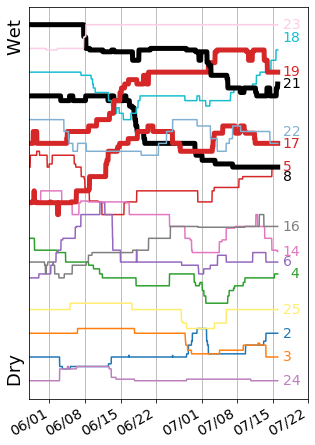

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,8))
tmpids = np.array([ 2,  3,  4,  5,  6,  8, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25])
sortix = np.argsort(np.array(crnstheta.loc["2019-05-22":"2019-06-01", tmpids].mean()))
tmp = crnstheta.loc["2019-05-22":"2019-07-15",tmpids].rolling("24H", min_periods=24*3).mean()

tmp_ = np.round(np.array(tmp),2)
ranks = np.empty_like(tmp_)
for i in range(len(tmp_)):
    ranks[i] = stats.rankdata(tmp_[i])

ranks = 16*ranks / np.sum(~np.isnan(tmp_), axis=1).reshape((-1,1))
ranks[np.isnan(tmp_)] = np.nan


ranks_ = pd.DataFrame(ranks,columns=tmpids,index=tmp.index)
ranks_ = ranks_.rolling("10D").median()
mycolors = np.concatenate((plt.cm.tab10(np.linspace(0,1,10)), plt.cm.Set3(np.linspace(0,1,6))))#[sortix]
for i, id in enumerate(tmpids):
    mycolor=mycolors[i]
    #mycolor="grey"
    lw=1.5
    if id in [8, 21]:
        mycolor="black"
        lw=5
    if id in [17,19]:
        mycolor="tab:red"
        lw=5
    plt.plot(ranks_.index, ranks_[id], color=mycolor, lw=lw)
    ypos = ranks_[id][-1]
    xpos = dt.datetime(2019,7,17)
    if id in [18,22]:
        ypos += 0.5
    if id in [8]:
        ypos -= 0.4
    if id in [4]:
        xpos += dt.timedelta(seconds=36*3600)
    plt.text(xpos, ypos, str(id), color=mycolor,
             verticalalignment="center", horizontalalignment="left", fontsize=14, weight=500)
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.get_yaxis().set_ticks([])
plt.ylabel("Dry                                                    Wet", fontsize=18)
plt.xlim(dt.datetime(2019,5,28), dt.datetime(2019,7,22))
fig.autofmt_xdate()

plt.savefig("figures/theta_ranking.pdf", dpi=300, bbox_inches="tight")

# Optimal interpolation

## Theoretical illustration

In [107]:
import numpy as np
import scipy.interpolate as spip
from scipy.ndimage import gaussian_filter1d
import scipy.ndimage as ndim
import scipy.optimize as sciopt

In [108]:
def cosmic_weights1d(x, xi):
    """Return horizontal weights.
    
    Parameters
    ----------
    x : Spatial coordinates for which to compuet weights
       array of floats
    xi : Coordinates at which observation is simulated
       array of floats
    
    Returns
    -------
    output : array of floats of shape (len(xi), len(x))
    """
    disti = np.abs(x-xi.reshape((-1,1)))+1
    wi = cs.core.horizontal_weight_koehli_approx(disti)
    #return wi/wi.sum(axis=1).reshape((-1,1))    
    return wi


def cosmic_filter1d(x, y, xi):
    """Return filtered values of y as seen from xi.
    
    Parameters
    ----------
    x : Spatial coordinates for which to compuet weights
       array of floats
    xi : Coordinates at which observation is simulated
       array of floats
    
    Returns
    -------
    output : array of floats of shape (len(xi), len(x))
    """
    wi = cosmic_weights1d(x,xi)
    wi = wi/wi.sum(axis=1).reshape((-1,1))
    return np.sum(y * wi, axis=1)


def cosmic_interp1d(x, xi, yi):
    """Return filtered values of y as seen from xi.
    
    Parameters
    ----------
    x : Spatial coordinates for which to compuet weights
       array of floats
    xi : Coordinates at which observation is simulated
       array of floats
    
    Returns
    -------
    output : array of floats of shape (len(xi), len(x))
    """
    wi = cosmic_weights1d(x,xi)
    wi = wi/wi.sum(axis=0)#.reshape((-1,1))
    return np.sum(yi.reshape((-1,1)) * wi, axis=0)
    

In [109]:
xlen = 201
np.random.seed(13) #ok: 9, 12
x = np.arange(xlen)
xobs = np.array([90,150])
y = np.random.randn(xlen).cumsum()
y = y + np.abs(y.min())
y = y/(y.max() + 10)
y = y + 0.05

n0 = 3500
filter_sigma = 25
filter_len=50
#ipmode = "thin-plate"
#smooth=10

ysmooth = cosmic_filter1d(x, y, x)


nobs = cs.core.theta_to_n_desilets(ysmooth[xobs], n0=n0)

theta_crns = cs.core.n_to_theta_desilets(nobs, n0=n0)

ip = wradlib.ipol.OrdinaryKriging(xobs[:,None], x[:,None], nnearest=2, cov='1.0 Exp(2000.)')
fi = ip(theta_crns)
#fi = cosmic_interp1d(x, xobs, theta_crns)

nsim = cs.core.theta_to_n_desilets(cosmic_filter1d(x, fi, xobs), n0=n0)

# Optimization
def objfun(pars):
    fi = ip(pars)
    nsim = cs.core.theta_to_n_desilets(cosmic_filter1d(x, fi, xobs), n0=n0)
    return(np.sum((nsim-nobs)**2))

optip_out = sciopt.minimize(objfun, theta_crns, method="CG")

optfi = ip(optip_out["x"])

nopt = cs.core.theta_to_n_desilets(cosmic_filter1d(x, optfi, xobs), n0=n0)

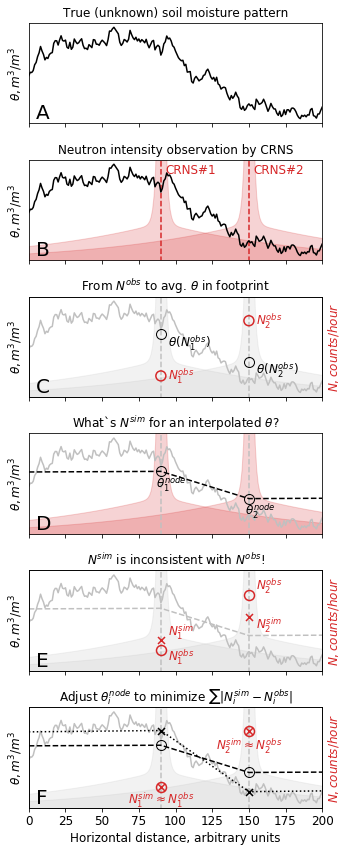

In [110]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(5,12), nrows=6, sharex=True)
#fig, ax = plt.subplots(figsize=(12,5), nrows=2, ncols=3, sharex=True)
ax = ax.ravel()

# for panel labels
panelx = 5
panely = 0.05
panelfontsize = 20

filter_len=60
fs_title = 12
cosmiccol="tab:blue"
alpha=0.2
amplify=0.3
filter_y = cosmic_weights1d(x, xobs)

plt.sca(ax[0])
plt.title("True (unknown) soil moisture pattern", fontsize=fs_title)
plt.plot(x, y, 'black', label=r'$\theta_{true}$ (unknown)')
ylim = plt.ylim()
plt.ylabel(r"$\theta, m^3/m^3$")
ax[0].get_yaxis().set_ticks([])
plt.text(panelx, panely, "A", fontsize=panelfontsize)


plt.sca(ax[1])
plt.title("Neutron intensity observation by CRNS", fontsize=fs_title)
plt.plot(x, y, 'black', label=r'$\theta_{true}$ (unknown)')
plt.vlines(xobs, ymin=0, ymax=1, color="tab:red", ls="--")
plt.ylim(ylim)
for i,xi in enumerate(xobs):
    plt.text(xi+3, ylim[1]-0.1, "CRNS#%d" % (i+1), color="tab:red")
    plt.fill_between(x, amplify*filter_y[i], color="tab:red", alpha=alpha)
#plt.xlabel("Horizontal distance, arbitrary units")
plt.ylabel(r"$\theta, m^3/m^3$")
ax[1].get_yaxis().set_ticks([])
plt.text(panelx, panely, "B", fontsize=panelfontsize)

plt.sca(ax[2])
plt.title(r"From $N^{obs}$ to avg. $\theta$ in footprint", fontsize=fs_title)
backgcol = "silver"
plt.plot(x, y, backgcol, label=r'$\theta_{true}$ (unknown)')
plt.vlines(xobs, ymin=0, ymax=1, color=backgcol, ls="--")
plt.ylim(ylim)
for i,xi in enumerate(xobs):
    plt.fill_between(x, amplify*filter_y[i], color=backgcol, alpha=alpha)
    plt.plot(xobs[i], theta_crns[i], "ko", ms=10, mfc="None")
    plt.text(xi+5, theta_crns[i]-0.09, r"$\theta(N^{obs}_{%d})$" % (i+1), 
             color="black", horizontalalignment="left")
#plt.xlabel("Horizontal distance, arbitrary units")
plt.ylabel(r"$\theta, m^3/m^3$")
ax[2].get_yaxis().set_ticks([])
plt.text(panelx, panely, "C", fontsize=panelfontsize)
ax1 = ax[2].twinx()
plt.sca(ax1)
plt.scatter(xobs, nobs, facecolors="None", edgecolors="tab:red", s=100, lw=1.5)
for i,xi in enumerate(xobs):
    plt.text(xi+5, nobs[i], r"$N^{obs}_{%d}$" % (i+1), 
             color="tab:red", horizontalalignment="left", verticalalignment="center")
plt.ylabel(r"$N, counts / hour$")
ax1.get_yaxis().set_ticks([])
ylimtw = ax1.get_ylim()
ax1.set_ylim(ylimtw[0]*0.95, ylimtw[1]*1.05)
ax1.yaxis.label.set_color('tab:red')


plt.sca(ax[3])
plt.title(r'What`s $N^{sim}$ for an interpolated $\theta$?', fontsize=fs_title)
plt.plot(x, y, backgcol, label=r'$\theta_{true}$ (unknown)')
plt.vlines(xobs, ymin=0, ymax=1, color=backgcol, ls="--")
plt.ylim(ylim)
for i,xi in enumerate(xobs):
    plt.fill_between(x, amplify*filter_y[i], color="tab:red", alpha=alpha)
    plt.plot(xobs[i], theta_crns[i], "ko", ms=10, mfc="None")
    plt.text(xi-3, theta_crns[i]-0.12, r"$\theta^{node}_{%d}$" % (i+1), 
             color="black", horizontalalignment="left")
plt.plot(x, fi, 'k--')
#plt.xlabel("Horizontal distance, arbitrary units")
plt.ylabel(r"$\theta, m^3/m^3$")
ax[3].get_yaxis().set_ticks([])
plt.text(panelx, panely, "D", fontsize=panelfontsize)


plt.sca(ax[4])
plt.title('$N^{sim}$ is inconsistent with $N^{obs}!$', fontsize=fs_title)
plt.plot(x, y, backgcol, label=r'$\theta_{true}$ (unknown)')
plt.vlines(xobs, ymin=0, ymax=1, color=backgcol, ls="--")
plt.ylim(ylim)
for i,xi in enumerate(xobs):
    plt.fill_between(x, amplify*filter_y[i], color=backgcol, alpha=alpha)
plt.plot(x, fi, color=backgcol, ls="--")
#plt.xlabel("Horizontal distance, arbitrary units")
plt.ylabel(r"$\theta, m^3/m^3$")
ax[4].get_yaxis().set_ticks([])
plt.text(panelx, panely, "E", fontsize=panelfontsize)
ax1 = ax[4].twinx()
plt.sca(ax1)
plt.plot(xobs, nopt, "bo", marker="o", ms=10, mfc="None", mec="tab:red", mew=1.5)
plt.plot(xobs, nsim, "bo", marker="x", ms=7, color="tab:red", mew=1.5)
for i,xi in enumerate(xobs):
    multy = 0.02
    if nobs[i] > nsim[i]:
        multy = 1. + multy
    else:
        multy = 1. - multy
    plt.text(xi+5, nobs[i]*multy, r"$N^{obs}_{%d}$" % (i+1), 
             color="tab:red", horizontalalignment="left", verticalalignment="center")
    plt.text(xi+5, nsim[i]*(1/multy), r"$N^{sim}_{%d}$" % (i+1), 
             color="tab:red", horizontalalignment="left", verticalalignment="center")

plt.ylabel(r"$N, counts / hour$")
ax1.get_yaxis().set_ticks([])
ylimtw = ax1.get_ylim()
ax1.set_ylim(ylimtw[0]*0.95, ylimtw[1]*1.05)
ax1.yaxis.label.set_color('tab:red')


plt.sca(ax[5])
plt.title(r"Adjust $\theta^{node}_i$ to minimize $\sum|N^{sim}_i - N^{obs}_i|$", fontsize=fs_title)
plt.plot(x, y, backgcol, label=r'$\theta_{true}$ (unknown)')
plt.vlines(xobs, ymin=0, ymax=1, color=backgcol, ls="--")
plt.ylim(ylim)
for i,xi in enumerate(xobs):
    plt.fill_between(x, amplify*filter_y[i], color=backgcol, alpha=alpha)
plt.plot(x, fi, color="black", ls="--")
plt.plot(x, optfi, color="black", ls="dotted")
plt.plot(xobs, theta_crns, "ko", ms=10, mfc="None")
plt.plot(xobs, optfi[xobs], "bo", marker="x", ms=7, color="black", mew=1.5)
plt.xlabel("Horizontal distance, arbitrary units")
plt.ylabel(r"$\theta, m^3/m^3$")
ax[5].get_yaxis().set_ticks([])
plt.xlim(x[0], x[-1])
#ax[5].get_xaxis().set_ticks([])
plt.text(panelx, panely, "F", fontsize=panelfontsize)
ax1 = ax[5].twinx()
plt.sca(ax1)
plt.plot(xobs, nopt, "bo", marker="o", ms=10, mfc="None", mec="tab:red", mew=1.5)
plt.plot(xobs, nopt, "bo", marker="x", ms=7, color="tab:red", mew=1.5)
for i,xi in enumerate(xobs):
    plt.text(xi, nopt[i]*0.99, r"$N^{sim}_{%d} \approx N^{obs}_{%d}$" % (i+1, i+1), 
             color="tab:red", horizontalalignment="center", verticalalignment="top")
plt.ylabel(r"$N, counts / hour$")
ax1.get_yaxis().set_ticks([])
ylimtw = ax1.get_ylim()
ax1.set_ylim(ylimtw[0]*0.95, ylimtw[1]*1.05)
ax1.yaxis.label.set_color('tab:red')

plt.tight_layout()#h_pad=0.03)

plt.savefig("figures/optip_concept.pdf", dpi=300, bbox_inches="tight")

## Practical implementation

In [111]:
# Static setup
useids = [1,2,3,4,5,6,8,14,16,17,18,19,21,22,23,24,25]
#useids = [3,8,17,18,23,24,25]
srcrhob = attrs.loc[useids, "rhob"]*1000
srcthetaeq = attrs.loc[useids, "thetaeq"]
srcxy = np.array(attrs.loc[useids,["x","y"]])

# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
horiz_weights = np.zeros((len(useids), len(xxyy)))
for i, id in enumerate(useids):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist) / (2 * np.pi * dist)
    w = w / w.sum()
    w[dist>300] = 0
    horiz_weights[i] = w
    
# Interpolator object
#okopt = wradlib.ipol.OrdinaryKriging(srcxy, xxyy, cov='1.0 Exp(300.)', nnearest=len(useids))

#okopts = []
#possible_ranges = np.arange(100, 510., 10.)
#for r_ in possible_ranges:
#    okopts.append( wradlib.ipol.OrdinaryKriging(srcxy, xxyy, cov='1.0 Exp(%.1f)' % r_, nnearest=len(useids)) )

### Ordinary Kriging

In [112]:
interval = 24*3600
thedays = wradlib.util.from_to("2019-05-15 00:00:00", "2019-07-15 00:00:00", interval)

In [113]:
# Containers
naiveip          = np.zeros((len(thedays),len(xxyy)))
optimip          = np.zeros((len(thedays),len(xxyy)))
optimals         = []
mae_init         = np.zeros(len(thedays))
mae_optim        = np.zeros(len(thedays))
nobs             = np.zeros((len(thedays),len(useids)))
theta_from_nobs  = np.zeros((len(thedays),len(useids)))
theta_from_naive = np.zeros((len(thedays),len(useids)))
theta_from_optim = np.zeros((len(thedays),len(useids)))
nsims_naive      = np.zeros((len(thedays),len(useids)))
nsims_optim      = np.zeros((len(thedays),len(useids)))
ranges_optim     = np.zeros(len(thedays))

sensitivityrangefactor = 1.#1e7

for i, theday in enumerate(thedays):
    # Collect data for one time window
    start = theday.isoformat(" ")
    end = (theday+dt.timedelta(seconds=interval)).isoformat(" ")
    print(start[:14], end=" ")
    nobs[i] = np.array(crns20c_vegc.loc[start:end,useids].mean())
    goodix = ~np.isnan(nobs[i])
    print("%d sensors, " % len(np.where(goodix)[0]), end="")
#    if np.any(np.isnan(nobs[i])):
#        print("...no data for %d probes." % len(np.where(np.isnan(nobs[i]))[0]))
#        continue
    theta_from_nobs[i] = cs.core.n_to_theta_desilets(nobs[i], n0=avgn0, rhob=srcrhob) - srcthetaeq
    
    okopt = wradlib.ipol.OrdinaryKriging(srcxy[goodix], xxyy, cov='1.0 Exp(300.)', nnearest=len(np.where(goodix)[0]))
    
    # Naive Interpolation
    naiveip[i] = okopt(theta_from_nobs[i][goodix])

    # Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
    # and it has to be updated based on current soilmoisture
    horiz_weights = np.zeros((len(useids), len(xxyy)))
    press_oncamp = press.p0[start:end].mean()
    h_oncamp = temphum[start:end].abshum2m.mean()
    Hveg = 0.
    for k, id in enumerate(useids):
        dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
        thetaeffinit = theta_from_nobs[i][k] + np.array(srcthetaeq)[k]
        w = cs.core.horizontal_weight_koehli(dist, press_oncamp, Hveg, thetaeffinit, h_oncamp) / (2 * np.pi * dist)
        #w = cs.core.horizontal_weight_koehli_approx(dist) / (2 * np.pi * dist)
        w[dist>300] = 0
        w = w / w.sum()
        horiz_weights[k] = w
        theta_from_naive[i,k] = np.dot(horiz_weights[k], naiveip[i])

    # Simulate N from naive interpolation 
    nsims_naive[i] = cs.core.theta_to_n_desilets(theta_from_naive[i]+srcthetaeq, n0=avgn0, rhob=srcrhob)
    mae_init[i] = np.mean(np.abs(nsims_naive[i][goodix]-nobs[i][goodix]))

    # Optimization
    def objfun2d(pars):
        srctheta_ = pars
        interpolator=okopt
        trgtheta_ = interpolator(srctheta_)
        theta_from_ip_ = np.dot(horiz_weights, trgtheta_)
        nsim_ = cs.core.theta_to_n_desilets(theta_from_ip_+srcthetaeq, n0=avgn0, rhob=srcrhob)
        error = np.mean(np.abs(nsim_-nobs[i]))
        return(error)
    # Optimise Kriging range as well?
    optpars = theta_from_nobs[i][goodix]
    optip2d = sciopt.minimize(objfun2d, optpars, method="Nelder-Mead", options={"adaptive":True})#, bounds=bounds, 
    # Process optimal theta
    mae_optim[i] = optip2d["fun"]
    optimip[i] = okopt(optip2d["x"])
    for k, id in enumerate(useids):
        theta_from_optim[i,k] = np.dot(horiz_weights[k], optimip[i])
    nsims_optim[i] = cs.core.theta_to_n_desilets(theta_from_optim[i]+srcthetaeq, n0=avgn0, rhob=srcrhob)

    print("MAE naive: %.6f" % mae_init[i], end=", ")
    print("MAE optimal: %.6f" % mae_optim[i])

2019-05-15 00: 15 sensors, MAE naive: 6.953823, MAE optimal: 0.000301
2019-05-16 00: 15 sensors, MAE naive: 8.362467, MAE optimal: 0.000360
2019-05-17 00: 15 sensors, MAE naive: 8.406973, MAE optimal: 0.000316
2019-05-18 00: 15 sensors, MAE naive: 9.980087, MAE optimal: 0.000394
2019-05-19 00: 15 sensors, MAE naive: 7.411145, MAE optimal: 0.000395
2019-05-20 00: 15 sensors, MAE naive: 9.992155, MAE optimal: 0.008607
2019-05-21 00: 16 sensors, MAE naive: 11.484706, MAE optimal: 0.003253
2019-05-22 00: 16 sensors, MAE naive: 10.645654, MAE optimal: 0.000308
2019-05-23 00: 16 sensors, MAE naive: 10.192419, MAE optimal: 0.000212
2019-05-24 00: 16 sensors, MAE naive: 10.501339, MAE optimal: 0.001276
2019-05-25 00: 16 sensors, MAE naive: 10.196810, MAE optimal: 0.000433
2019-05-26 00: 16 sensors, MAE naive: 9.642517, MAE optimal: 0.000322
2019-05-27 00: 16 sensors, MAE naive: 9.642783, MAE optimal: 0.000286
2019-05-28 00: 16 sensors, MAE naive: 8.550506, MAE optimal: 0.000495
2019-05-29 00: 

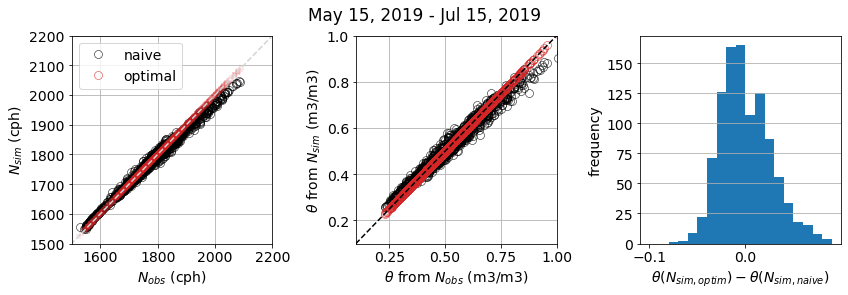

In [114]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(12,4), ncols=3)

mew=0.5
ms=8

plt.sca(ax[0])
plt.plot(nobs, nsims_naive, "ko", mfc="None", mec="black", mew=mew, ms=ms)
plt.plot(nobs, nsims_optim, "r+", mfc="None", mec="tab:red", mew=0.2, ms=ms)
plt.plot([0,3000], [0,3000], "k-", color="lightgrey", ls="--")
plt.xlim(1500, 2200)
plt.ylim(1500, 2200)
plt.xlabel(r"$N_{obs}$ (cph)")
plt.ylabel(r"$N_{sim}$ (cph)")
plt.grid()
legend_elements = [plt.Line2D([0], [0], marker="o",  ms=ms, mec="black", mfc="None", mew=mew,  lw=0, label="naive"),
                   plt.Line2D([0], [0], marker="o",  ms=ms, mec="tab:red", mfc="None", mew=mew,  lw=0, label="optimal")
                  ]
plt.legend(handles=legend_elements)


plt.sca(ax[1])
#ax[1].set_aspect("equal")
plt.plot(theta_from_nobs, theta_from_naive, "ko", mfc="None", mec="black", mew=mew, ms=ms)
plt.plot(theta_from_nobs, theta_from_optim, "ko", mfc="None", mec="tab:red", mew=mew, ms=ms)
plt.plot([0,1], [0,1], "k-", ls="--")
plt.xlim(0.1, 1.)
plt.ylim(0.1, 1.)
plt.xlabel(r"$\theta$ from $N_{obs}$ (m3/m3)")
plt.ylabel(r"$\theta$ from $N_{sim}$ (m3/m3)")
plt.grid()

plt.sca(ax[2])
plt.hist(theta_from_optim.ravel()-theta_from_naive.ravel(), bins=np.arange(-0.1, 0.1, 0.01))#[-0.1, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.2])
plt.grid(axis="y")
plt.xlabel(r"$\theta(N_{sim, optim}) - \theta(N_{sim, naive})$")
plt.ylabel("frequency")

fig.suptitle(thedays[0].strftime("%b %d, %Y")+" - "+thedays[-1].strftime("%b %d, %Y"), y=1.03)

plt.tight_layout()
plt.savefig("figures/optimal_interpolation_scatter.png", dpi=300, bbox_inches="tight")

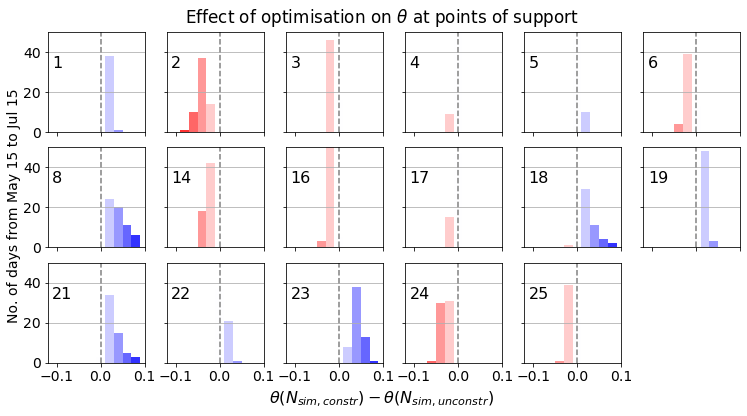

In [115]:
from matplotlib import colors
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(10,5), nrows=3, ncols=6, sharex=True, sharey=True)
ax = ax.ravel()

bins = np.arange(-0.11, 0.11, 0.02)

for i, id in enumerate(useids):
    plt.sca(ax[i])
    N, bins, bpatches = plt.hist(theta_from_optim[:,i] - theta_from_naive[:,i], bins=bins)#, density=True)
    #plt.title(str(id))
    plt.grid(axis="y")
    fracs = bins
    norm = colors.Normalize(bins[0], bins[-1])
    for thisfrac, thispatch in zip(fracs, bpatches):
        color = plt.cm.bwr_r(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.vlines(0, ymin=0, ymax=100, ls="--", color="grey")
    plt.text(-0.11, 32, str(id), horizontalalignment="left", fontsize=16)
    plt.ylim(0,50)
fig.text(0.5,-0.05,r"$\theta(N_{sim, constr}) - \theta(N_{sim, unconstr})$", horizontalalignment="center", fontsize=16)
fig.text(-0.02, 0.5, "No. of days from %s to %s" % (thedays[0].strftime("%b %d"), thedays[-1].strftime("%b %d")), rotation=90, verticalalignment="center")

ax[-1].axis('off')

plt.suptitle(r"Effect of optimisation on $\theta$ at points of support", y=1.05)

plt.tight_layout(pad=0.1)    

plt.savefig("figures/optimal_ip_effect_per_probe.png", dpi=300, bbox_inches="tight")

# Verification using SoilNet observations

In [116]:
from netCDF4 import Dataset

In [117]:
nc = Dataset("data/soilmoisture/permanent_wsn/CosmicSense_JFC1_DE-Fen_SNdata_revised3.nc", "r", format="NETCDF4")
sn_dtimes = [dt.datetime(2019,5,1) + dt.timedelta(seconds=tmp*60) for tmp in nc.variables["time"][:]]

In [118]:
nc.variables.keys()

odict_keys(['time', 'lat', 'lon', 'elev', 'depth', 'station_name', 'eps_a', 'eps_b', 'vwc_a', 'vwc_b', 'T_a', 'T_b', 'theta_a_conv', 'theta_b_conv', 'theta_a_Fersch', 'theta_b_Fersch'])

In [119]:
snx, sny = wradlib.georef.reproject(nc.variables["lon"][:],
                                    nc.variables["lat"][:],
                                    projection_target=utm32n)
snxy = np.vstack([snx, sny]).T
snxy.shape

(55, 2)

In [120]:
nc.variables["depth"][:]

masked_array(data=[ 5., 20., 50.],
             mask=False,
       fill_value=1e+20)

In [121]:
nc.variables.keys()

odict_keys(['time', 'lat', 'lon', 'elev', 'depth', 'station_name', 'eps_a', 'eps_b', 'vwc_a', 'vwc_b', 'T_a', 'T_b', 'theta_a_conv', 'theta_b_conv', 'theta_a_Fersch', 'theta_b_Fersch'])

In [122]:
snbufr = 0
snleft, snright, snbottom, sntop = snx.min()+40, snx.max()-40, sny.min()+60, sny.max()

In [123]:
snixl = np.where(xx[0,:] < snleft)[0][-1]
snixr = np.where(xx[0,:] > snright)[0][0]
snixb = np.where(yy[:,0] > snbottom)[0][-1]
snixt = np.where(yy[:,0] < sntop)[0][0]
snixl, snixr, snixb, snixt

sngrdxx, sngrdyy = xx[snixt:snixb,snixl:snixr], yy[snixt:snixb,snixl:snixr]
sngrdxy = np.vstack([sngrdxx.ravel(), sngrdyy.ravel()]).T
sngrdxy.shape

snix = np.zeros(xx.shape, dtype="int")
snix[snixt:snixb,snixl:snixr] = 1
snix = (snix==1).ravel()

In [124]:
sntheta = np.array(nc.variables["theta_a_Fersch"][:] / 100.)
sntheta[sntheta==-1] = np.nan

snthetab = np.array(nc.variables["theta_b_Fersch"][:] / 100.)
snthetab[snthetab==-1] = np.nan

sntheta = (sntheta + snthetab) / 2

In [125]:
from scipy import interpolate

In [126]:
snres_depths = np.arange(1,31,1)
snthetars = np.zeros((sntheta.shape[0],len(snres_depths), sntheta.shape[2]))
for i in range(len(snthetars)):
    x = nc.variables["depth"][:]
    y = sntheta[i]
    yb = snthetab[i]
    f = interpolate.interp1d(x, y, axis=0, fill_value="extrapolate")
    snthetars[i] = f(snres_depths)

In [127]:
snthetars[:, snres_depths<5, :] = sntheta[:,0,:].reshape((snthetars.shape[0],1,snthetars.shape[2]))

In [128]:
#vweights_sn = cs.core.vertical_weight_koehli(20, snres_depths, 0.1, 1000., 0, 0.8).reshape((-1,1))
#vertavg_sn_generic = np.sum(vweights_sn * snthetars, axis=1) / np.sum(vweights_sn)

In [129]:
#for test in [20]:
##    if test==1:
##        snthetars[:, snres_depths<5, :] = sntheta[:,0,:].reshape((snthetars.shape[0],1,snthetars.shape[2]))
#    print(test)
#    vertavg_sn = np.zeros((snthetars.shape[0], snthetars.shape[2]))
#    maxiter = 5
#    for i in range(len(snthetars)):
#        thtmp = np.nanmean(snthetars[i], axis=0)
#        for iteri in range(maxiter):
#            #print("%.2f" % thtmp, end="=>")
#            vweights_sn = cs.core.vertical_weight_koehli(20, snres_depths, thtmp, 1000., 0., 1.)#.reshape((-1,1))
#            thtmp = np.sum(vweights_sn * snthetars[i], axis=0) / np.sum(vweights_sn, axis=0)
#        vertavg_sn[i] = thtmp
#    plt.plot(sn_dtimes, np.nanmean(vertavg_sn, axis=1), label="%s" % test)
#plt.plot(sn_dtimes, np.nanmean(vertavg_sn_generic, axis=1), label="generic")
#plt.plot(sn_dtimes, np.nanmean(snthetars, axis=(1,2)), label="root zone")
#plt.legend()

In [130]:
## COMPUTE HORIZONTAL WEIGHTS ACC. TO CONTRIBUTION
#vertavg_sn2 = np.zeros((snthetars.shape[0], snthetars.shape[2]))
#maxiter = 3
#for i in range(len(snthetars)):
#    #print(i,end=" ")
#    for j in range(snthetars.shape[2]):
#        thtmp = np.nanmean(snthetars[i,:,j])
#        for iteri in range(maxiter):
#            vweights_sn2 = cs.core.vertical_weight_koehli(20, snres_depths, thtmp, 1000., 0., 0.8)#.reshape((-1,1))
#            thtmp = np.sum(vweights_sn2 * snthetars[i,:,j]) / np.sum(vweights_sn2)
#        vertavg_sn2[i,j] = thtmp

In [131]:
#plt.plot(sn_dtimes, np.nanmean(vertavg_sn2, axis=1), label="neu")
#plt.plot(sn_dtimes, np.nanmean(vertavg_sn, axis=1), label="%s" % test)
#plt.legend()

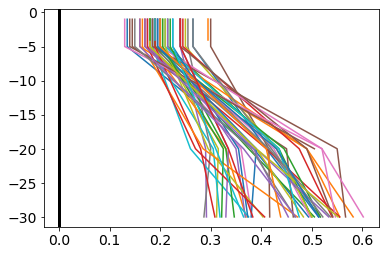

In [132]:
for i in range(55):
    _ = plt.plot(snthetars[8000,:,i], -snres_depths)
plt.axvline(0,ymin=-30, ymax=110, color="black", lw=3)

## Compare SoilNet to single CRNS locations

Compute daily average values per depth, then interpolate these horizontally

In [133]:
snip052050 = np.zeros((len(thedays), 3, len(sngrdxy)))
for i, dtime in enumerate(thedays):
    start = dtime
    end = dtime + dt.timedelta(seconds=interval)
    timeix = (np.array(sn_dtimes) >= start) & (np.array(sn_dtimes) <= end)
    sntheta_sub = sntheta[timeix]
    # We deliberately use np.mean instead of np.nanmean 
    sntheta_sub_avg = np.mean(sntheta_sub, axis=0)
    for j in range(3):
        vals = np.array(sntheta_sub_avg[j])
        goodix = np.where(~np.isnan(vals))[0]
        oksn = wradlib.ipol.OrdinaryKriging(snxy[goodix], sngrdxy, cov='1.0 Exp(300.)', nnearest=len(goodix))
        snip052050[i,j] = oksn(vals[goodix])
    print(".", end="")
print("done.")

..............................................................done.


Interpolate vertical profile per grid cell at centimeter resolution

In [134]:
snres_depths = np.arange(1,31,1)
snip052050rs = np.zeros((snip052050.shape[0],len(snres_depths), snip052050.shape[2]))
for i in range(len(snip052050rs)):
    x = nc.variables["depth"][:]
    y = snip052050[i]
    f = interpolate.interp1d(x, y, axis=0, fill_value="extrapolate")
    snip052050rs[i] = f(snres_depths)

In [135]:
# Use nearest on top
snip052050rs[:,0:4,:] = snip052050rs[:,5,:].reshape((snip052050rs.shape[0],1,snip052050rs.shape[2]))

Apply vertical and horizontal averaging for each day

In [136]:
crns_in_sn = [3,8,17,18,24, 25]
dfsn_at_crns = pd.DataFrame({}, columns=useids, index=thedays)
d86_at_crns = pd.DataFrame({}, columns=useids, index=thedays)
vweights_at_crns = np.zeros((len(thedays),len(crns_in_sn),30,len(sngrdxy)))
maxiter = 5
for ii, day in enumerate(thedays):
    for i, id in enumerate(crns_in_sn):   
        #print("Iterating for CRNS #%d..." % id)
        # Initial guess
        thetaguess = snip052050rs[ii,0:20].mean()
        bdguess = attrs.loc[id, "rhob"]
        thetaeqguess = attrs.loc[id, "thetaeq"]
        thetaeff = thetaguess + thetaeqguess
        # Distances of grid cells to probe
        dists = cs.util.distance(np.array(attrs.loc[id,["x","y"]]), sngrdxy)
        press_oncamp = press.p0[start:end].mean()
        h_oncamp = temphum[start:end].abshum2m.mean()
        Hveg = 0.
        for iteri in range(maxiter):
            #print("\ttheta=%.4f, bd=%.2f, thetaeq=%.2f, thetaeff=%.2f" % (thetaguess, bdguess, thetaeqguess, thetaeff) )
            # Vertical weights
            vweights = cs.core.vertical_weight_koehli(dists, snres_depths, thetaeff, press_oncamp, Hveg, bdguess)
            theta_vertavgs = np.sum(vweights * snip052050rs[ii], axis=0) / np.sum(vweights, axis=0)
            #bd_vertavgs = np.sum(vweights * bd_vertgrd, axis=1) / np.sum(vweights, axis=1 )
            #thetaeq_vertavgs = np.sum(vweights * thetaeq_vertgrd, axis=1) / np.sum(vweights, axis=1 )
            hweights = cs.core.horizontal_weight_koehli(dists, press_oncamp, Hveg, thetaguess, h_oncamp) \
                       / (2 * np.pi * dists)
            hweights[dists>300] = 0
            thetaguess = np.sum(hweights * theta_vertavgs) / np.sum(hweights)
            #bdguess = np.sum(hweights * bd_vertavgs) / np.sum(hweights)
            #thetaeqguess = np.sum(hweights * np.sum(hweights * thetaeq_vertavgs) / np.sum(hweights)) / np.sum(hweights)
            thetaeff = thetaguess + thetaeqguess
        dfsn_at_crns.loc[day, id] = thetaeff
        d86_at_crns.loc[day, id] = cs.core.D86(20, thetaeff, 1000, 0, bdguess)
        vweights_at_crns[ii,i] = vweights
        
#    print(".", end="")
print("done.")

done.


In [137]:
N24 = crns20c_vegc[useids].resample("24H").mean()
#h24.index = h24.index - dt.timedelta(seconds=12*3600)
N24 = N24[thedays[0]:thedays[-1]]
#h48 = crns20c_vegc[ids].rolling("48H", min_periods=int(3*48*0.8)).mean()
crnstheta24 = N24.apply(copy.deepcopy)
#crnstheta48 = h48.apply(copy.deepcopy)
for id in useids:
    crnstheta24[id] = cs.core.n_to_theta_desilets(N24[id].copy(), n0=avgn0, rhob=attrs.loc[id, "rhob"]*1000) - attrs.thetaeq[id] 

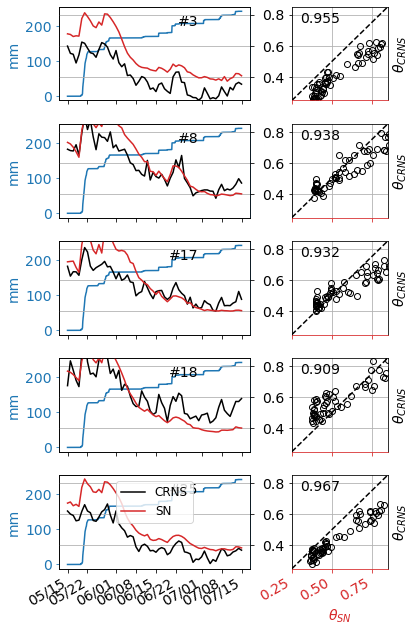

In [138]:
plotids=[3, 8, 17, 18, 25]
axmin, axmax = 0.25, 0.85
fig = plt.figure(figsize=(6,9))
spec = gridspec.GridSpec(ncols=2, nrows=len(plotids),
                         width_ratios=[2, 1])

#fig,ax = plt.subplots(figsize=(5,10), nrows=5, ncols=2)
for i, id_ in enumerate(plotids):
    ax = fig.add_subplot(spec[i,1])
    #plt.sca(ax[i,1])
    plt.plot(dfsn_at_crns[[id_]], crnstheta24[[id_]], "ko", mfc="None", mec="black")
    plt.plot([0,1],[0,1],color="black", ls="--")
    plt.xlim(axmin, axmax)
    plt.ylim(axmin, axmax)
    plt.grid()
    plt.xlabel(r"$\theta_{SN}$", color="tab:red")
    ax.spines['bottom'].set_color("tab:red")
    ax.tick_params(axis='x', colors="tab:red")
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("right")
    plt.ylabel(r"$\theta_{CRNS}$")
    corr = stats.pearsonr(np.array(dfsn_at_crns[[id_]]).ravel(), np.array(crnstheta24[[id_]]).ravel())[0]
    plt.text(0.3,0.75,"%.3f" % corr)
    #plt.sca(ax[i,0])
    ax = fig.add_subplot(spec[i,0])
    plt.plot(meteo[thedays[0]:thedays[-1]].index, meteo[thedays[0]:thedays[-1]].precip.cumsum(), 
             color="tab:blue", label="Cum. prec.")
    plt.ylabel("mm", color="tab:blue")
    ax.spines['right'].set_color("tab:blue")
    ax.tick_params(axis='y', colors="tab:blue")
    ax = plt.twinx()
    plt.plot(thedays, crnstheta24[[id_]], color="black", label=r"CRNS")
    plt.plot(thedays, dfsn_at_crns[[id_]], color="tab:red", label=r"SN")
    plt.ylim(axmin, axmax)
    ax.axes.yaxis.set_ticklabels([])
    if i==4:
        plt.legend(loc="upper center", fontsize=12)
    plt.grid()
    plt.text(dt.datetime(2019,6,30), 0.73, "#"+str(id_), fontsize="14", horizontalalignment="right")

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


fig.autofmt_xdate()
plt.tight_layout(w_pad=0.)

plt.savefig("figures/crns_vs_soilnet_by_loc.pdf", dpi=300, bbox_inches="tight")

In [160]:
vertavg_sn = np.zeros((snthetars.shape[0], snthetars.shape[2]))
maxiter = 5
for i in range(len(snthetars)):
    thtmp = np.nanmean(snthetars[i], axis=0)
    for iteri in range(maxiter):
        #print("%.2f" % thtmp, end="=>")
        vweights_sn = cs.core.vertical_weight_koehli(20, snres_depths, thtmp, 1000., 0, 0.9)
        thtmp = np.sum(vweights_sn * snthetars[i], axis=0) / np.sum(vweights_sn, axis=0)
    vertavg_sn[i] = thtmp

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [140]:
# ALTERNATIVE: Use vweights from each CRNS, and daily SN profiles
vertavg_sn_new = np.zeros((len(thedays), len(crns_in_sn), snip052050rs.shape[2]))
#maxiter = 5
for i in range(len(thedays)):
    for ii in range(len(crns_in_sn)):
#    thtmp = np.nanmean(snip052050rs[i], axis=0)
#    for iteri in range(maxiter):
#        #print("%.2f" % thtmp, end="=>")
#        vweights_sn = cs.core.vertical_weight_koehli(20, snres_depths, thtmp, 1000., 0, 0.8)#.reshape((-1,1))
#        thtmp = np.sum(vweights_sn * snip052050rs[i], axis=0) / np.sum(vweights_sn, axis=0)
        #vweights_sn = np.mean(vweights_at_crns[i], axis=0)
        vweights_sn = vweights_at_crns[i,ii]
        thtmp = np.sum(vweights_sn * snip052050rs[i], axis=0) / np.sum(vweights_sn, axis=0)
        vertavg_sn_new[i,ii] = thtmp

Text(0.5, 1.0, 'Bulk density')

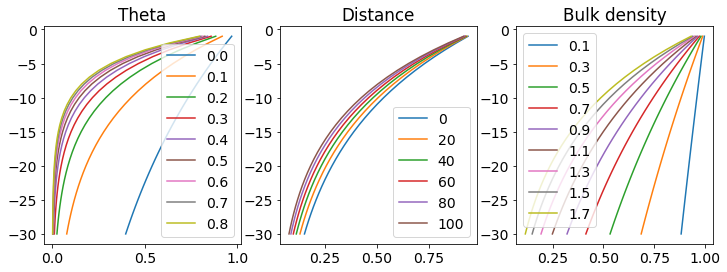

In [141]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
ax = ax.ravel()

plt.sca(ax[0])
for th in np.arange(0.0,0.9,0.1):
    vweights_sn = cs.core.vertical_weight_koehli(100, snres_depths, th, 1000., 0, 1.5).reshape((-1,1))
    plt.plot(vweights_sn, -snres_depths, label="%.1f" % th)
plt.legend()
plt.title("Theta")

plt.sca(ax[1])
for th in np.arange(0,120,20):
    vweights_sn = cs.core.vertical_weight_koehli(th, snres_depths, 0.1, 1000., 0, 1.5).reshape((-1,1))
    plt.plot(vweights_sn, -snres_depths, label="%.0f" % th)
plt.legend()
plt.title("Distance")


plt.sca(ax[2])
for th in np.arange(0.1,1.8,0.2):
    vweights_sn = cs.core.vertical_weight_koehli(th, snres_depths, 0.1, 1000., 0, th).reshape((-1,1))
    plt.plot(vweights_sn, -snres_depths, label="%.1f" % th)
plt.legend()
plt.title("Bulk density")


In [161]:
dfsn = pd.DataFrame(vertavg_sn, index=sn_dtimes)
dfsnday = dfsn.resample("24H").mean()

In [143]:
dfsn30 = pd.DataFrame(np.nanmean(snthetars, axis=(1,2)), index=sn_dtimes)
dfsnday30 = dfsn30.resample("24H").mean()

In [144]:
#snix = (xxyy[:,0] >= snx.min()) & (xxyy[:,0] <= snx.max()) & (xxyy[:,1] >= sny.min()) & (xxyy[:,1] <= sny.max())

In [162]:
snip = np.zeros((len(thedays), len(sngrdxy)))
#snipb = np.zeros((len(thedays), len(sngrdxy)))
for i, dtime in enumerate(thedays):
    print(".", end="")
    vals = np.array(dfsnday.loc[dtime])
    goodix = np.where(~np.isnan(vals))[0]
    oksn = wradlib.ipol.OrdinaryKriging(snxy[goodix], sngrdxy, cov='1.0 Exp(300.)', nnearest=len(goodix))
    snip[i] = oksn(vals[goodix])
#    snip[i] = griddata(snxy[goodix], vals[goodix], sngrdxy, method='cubic')
print("done.")

..............................................................done.


In [146]:
snip30 = np.zeros((len(thedays), len(sngrdxy)))
#snipb = np.zeros((len(thedays), len(sngrdxy)))
for i, dtime in enumerate(thedays):
    print(".", end="")
    vals = np.array(dfsnday30.loc[dtime])
    goodix = np.where(~np.isnan(vals))[0]
    oksn = wradlib.ipol.OrdinaryKriging(snxy[goodix], sngrdxy, cov='1.0 Exp(300.)', nnearest=len(goodix))
    snip30[i] = oksn(vals[goodix])
#    snip[i] = griddata(snxy[goodix], vals[goodix], sngrdxy, method='cubic')
print("done.")

..............................................................done.


In [147]:
#from scipy.ndimage import gaussian_filter

In [148]:
# truncate=4.
# #windows = np.arange(1, 400, 10)
# sigmas = np.arange(0, 5, 0.5)
# sigma_ = 2
# plt_sigmas = 10*2*(truncate*sigmas + 0.5) + 1
# #truncates = (((windows - 1)/2)-0.5)/sigma_ # https://stackoverflow.com/questions/25216382/gaussian-filter-in-scipy
# corrnaives = np.zeros((len(sigmas),len(naiveip)))
# corroptims = np.zeros((len(sigmas),len(naiveip)))
# maenaives = np.zeros((len(sigmas),len(naiveip)))
# maeoptims = np.zeros((len(sigmas),len(naiveip)))
# for j, sigma in enumerate(sigmas):
#     for i in range(len(naiveip)):
#         tmp = gaussian_filter(snip[i].reshape(sngrdxx.shape), sigma=sigma, truncate=truncate).ravel()
#         valix = ~np.isnan(tmp)
#         corrnaive = stats.spearmanr(naiveip[i,snix].ravel(), tmp)[0]
#         corroptim = stats.spearmanr(optimip[i,snix].ravel(), tmp)[0]
#         corrnaives[j, i] = corrnaive
#         corroptims[j, i] = corroptim
#         maenaives[j, i] = np.mean(np.abs(naiveip[i,snix].ravel() - tmp))
#         maeoptims[j, i] = np.mean(np.abs(optimip[i,snix].ravel() - tmp))

In [149]:
# plt.rc('font', **{'size'   : 14})
# fig = plt.figure(figsize=(6,3))
# #spec = gridspec.GridSpec(ncols=2, nrows=1,
# #                         width_ratios=[1, 2])

# ucol="tab:orange"
# ccol="tab:blue"

# ax = fig.add_subplot(111)
# pltdays = [day+dt.timedelta(seconds=24*3600) for day in thedays]
# plt.plot(pltdays, corrnaives[0], color=ucol, label="unconstr.")
# plt.plot(pltdays, corroptims[0], color=ccol, label="constr.")
# plt.fill_between(pltdays, np.round(corroptims[0],2) > np.round(corrnaives[0],2), step="mid",
#                  color=ccol, alpha=0.2)
# plt.fill_between(pltdays, np.round(corroptims[0],2) < np.round(corrnaives[0],2),
#                  step="mid", color=ucol, alpha=0.2)
# plt.ylabel("Rank correlation")
# plt.ylim(0,1)
# plt.legend(loc="lower center", framealpha=0.4, fontsize=12)
# plt.grid()
# plt.twinx()
# plt.plot(meteo[thedays[0]:thedays[-1]].index, meteo[thedays[0]:thedays[-1]].precip.cumsum(), 
#          color="black", ls="--", label="Cum. prec.")
# plt.legend(loc="lower right", framealpha=0.4, fontsize=12)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# plt.ylabel("mm")
# plt.xlim(dt.datetime(2019,5,16), dt.datetime(2019,7,14))

# fig.autofmt_xdate()

# plt.savefig("figures/correlation_benchmark.pdf", dpi=300, bbox_inches="tight")


In [163]:
corrnaives = np.zeros(len(naiveip))
corroptims = np.zeros(len(naiveip))
maenaives  = np.zeros(len(naiveip))
maeoptims  = np.zeros(len(naiveip))
meannaives = np.zeros(len(naiveip))
meanoptims = np.zeros(len(naiveip))
meansn     = np.zeros(len(naiveip))
meansn30    = np.zeros(len(naiveip))
for i in range(len(naiveip)):
    tmp = snip[i].reshape(sngrdxx.shape).ravel()
    meansn[i] = tmp.mean()
    meansn30[i] = snip30[i].reshape(sngrdxx.shape).mean()
    meannaives[i] = naiveip[i,snix].mean()
    meanoptims[i] = optimip[i,snix].mean()
    valix = ~np.isnan(tmp)
    corrnaives[i] = stats.spearmanr(naiveip[i,snix].ravel(), tmp)[0]
    corroptims[i] = stats.spearmanr(optimip[i,snix].ravel(), tmp)[0]
    maenaives[i] = np.mean(np.abs(naiveip[i,snix].ravel() - tmp))
    maeoptims[i] = np.mean(np.abs(optimip[i,snix].ravel() - tmp))

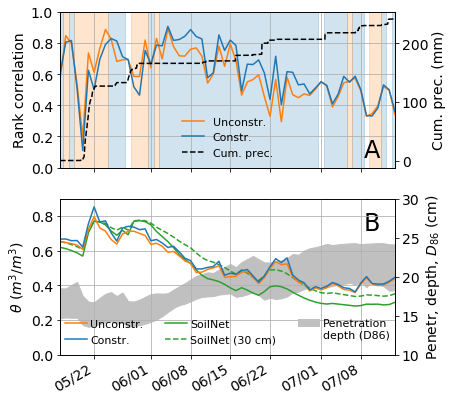

In [164]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(6,7), nrows=2, sharex=True)
ax = ax.ravel()
#fig = plt.figure(figsize=(6,3), nrows=2)
#spec = gridspec.GridSpec(ncols=2, nrows=1,
#                         width_ratios=[1, 2])

ucol="tab:orange"
ccol="tab:blue"

plt.sca(ax[0])
#ax = fig.add_subplot(111)
pltdays = [day+dt.timedelta(seconds=24*3600) for day in thedays]
plt.plot(pltdays, corrnaives, color=ucol, label="unconstr.")
plt.plot(pltdays, corroptims, color=ccol, label="constr.")
plt.fill_between(pltdays, np.round(corroptims,2) > np.round(corrnaives,2), step="mid",
                 color=ccol, alpha=0.2)
plt.fill_between(pltdays, np.round(corroptims,2) < np.round(corrnaives,2),
                 step="mid", color=ucol, alpha=0.2)
plt.ylabel("Rank correlation")
plt.ylim(0,1)
#plt.legend(loc="lower center", framealpha=0.4, fontsize=12)
plt.grid()
plt.twinx()
plt.plot(meteo[thedays[0]:thedays[-1]].index, meteo[thedays[0]:thedays[-1]].precip.cumsum(), 
         color="black", ls="--", label="Cum. prec.")
#plt.legend(loc="lower right", framealpha=0.4, fontsize=12)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.ylabel("Cum. prec. (mm)")
plt.xlim(dt.datetime(2019,5,16), dt.datetime(2019,7,14))

plt.text(dt.datetime(2019,7,8,12), 5, "A", fontsize=24)

legend_elements = [plt.Line2D([0], [0], lw=1.5, ls="-", color="tab:orange", label="Unconstr."),
                   plt.Line2D([0], [0], lw=1.5, ls="-", color="tab:blue", label="Constr."),
                   plt.Line2D([0], [0], lw=1.5, ls="--", color="black", label="Cum. prec."),]
_ = ax[0].legend(handles=legend_elements, loc="lower center", framealpha=0.0, edgecolor="black", 
                 fontsize=11)#, ncol=3)
_.get_frame().set_linewidth(0.8)

plt.sca(ax[1])

pltdays = [day+dt.timedelta(seconds=24*3600) for day in thedays]
plt.plot(pltdays, meansn, color="tab:green", label="SoilNet")
plt.plot(pltdays, meansn30, color="tab:green", ls="--", label="SoilNet_RZ")
plt.plot(pltdays, meannaives, color=ucol, label="Unconstr.")
plt.plot(pltdays, meanoptims, color=ccol, label="Constr.")
#plt.plot(pltdays, vertavg_sn_new.mean(axis=(1,2)), color="tab:red", label="newSN")
#plt.plot(pltdays, vertavg_sn_new.min(axis=(1,2)), color="tab:red", label="newSN")
#plt.plot(pltdays, vertavg_sn_new.max(axis=(1,2)), color="tab:red", label="newSN")
#for i, id in enumerate(crns_in_sn):
#    plt.plot(pltdays, vertavg_sn_new[:,i].mean(axis=1), color="tab:green", label="_zz")#label=str(id))
#plt.plot(pltdays, snip052050rs.max(axis=(1,2)), color="tab:green", label="newSN")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(dt.datetime(2019,5,16), dt.datetime(2019,7,14))
plt.ylabel(r"$\theta$ ($m^3/m^3$)")

plt.ylim(0.0, 0.9)
plt.grid()
#plt.legend()

tax = plt.twinx()
#plt.sca(ax[2])

pltdays = [day+dt.timedelta(seconds=24*3600) for day in thedays]
for id in [3,8,17,18,25]:
    mind86 = d86_at_crns[[3,8,17,18,25]].min(axis=1)
    maxd86 = d86_at_crns[[3,8,17,18,25]].max(axis=1)
#plt.plot(d86_at_crns.index, mind86, color="black")
#plt.plot(d86_at_crns.index, maxd86, color="black")
d86sh = plt.fill_between(d86_at_crns.index, mind86, maxd86, label="penetr. depth", color="silver")


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.ylim(10, 30)
#plt.grid()
ax[1].set_zorder(tax.get_zorder()+1) 
ax[1].patch.set_visible(False)

plt.ylabel(r"Penetr, depth, $D_{86}$ (cm)")
plt.text(dt.datetime(2019,7,8,12), 26, "B", fontsize=24)

legend_elements = [plt.Line2D([0], [0], lw=1.5, ls="-", color="tab:orange", label="Unconstr."),
                   plt.Line2D([0], [0], lw=1.5, ls="-", color="tab:blue", label="Constr."),
                   plt.Line2D([0], [0], lw=1.5, ls="-", color="tab:green", label="SoilNet"),
                   plt.Line2D([0], [0], lw=1.5, ls="--", color="tab:green", label="SoilNet (30 cm)"),
                   Patch(facecolor="silver", edgecolor="None", label="\nPenetration\ndepth (D86)")]
_ = ax[1].legend(handles=legend_elements, loc="lower center", framealpha=0.0, edgecolor="black", 
                 fontsize=11, ncol=3, handletextpad=0.25)
_.get_frame().set_linewidth(0.8)

fig.autofmt_xdate()

plt.savefig("figures/correlation_benchmark.pdf", dpi=300, bbox_inches="tight")


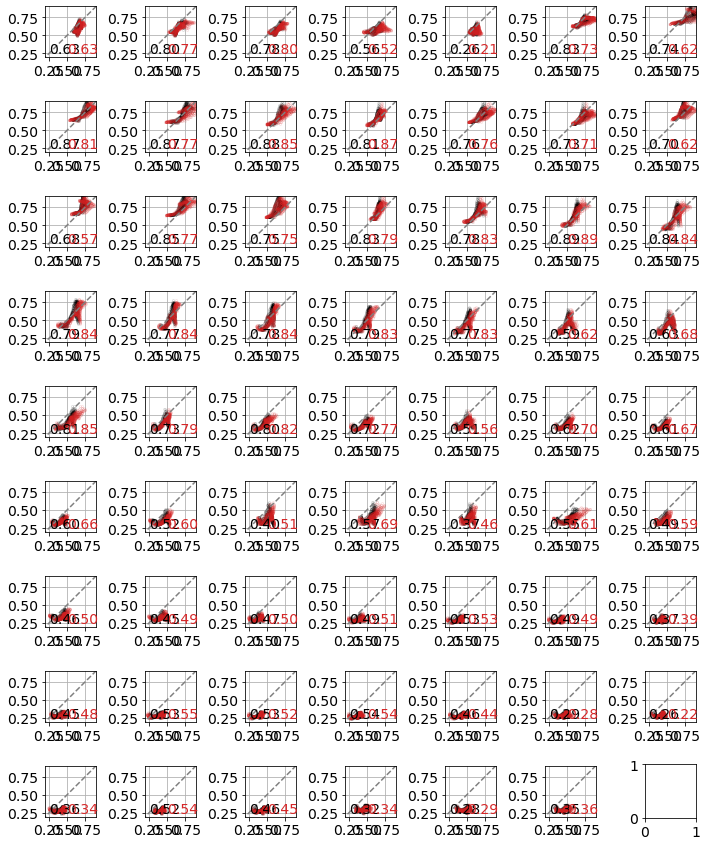

In [152]:
fig, ax = plt.subplots(nrows=9, ncols=7, figsize=(10,12))
ax = ax.ravel()

for i, day in enumerate(thedays):
    plt.sca(ax[i])
    ax[i].set_aspect("equal")
    plt.plot(naiveip[i,snix].ravel(), snip[i].ravel(), "ko", mfc="None", mec="black", mew=0.1, ms=2)
    plt.plot(optimip[i,snix].ravel(), snip[i].ravel(), "ko", mfc="None", mec="tab:red", mew=0.1, ms=2)
    corrnaive = stats.pearsonr(naiveip[i,snix].ravel(), snip[i].ravel())[0]
    corroptim = stats.pearsonr(optimip[i,snix].ravel(), snip[i].ravel())[0]
    plt.xlim(0.2, 0.9)
    plt.ylim(0.2, 0.9)
    plt.text(0.25, 0.25, "%.2f" % corrnaive, color="black")
    plt.text(0.5, 0.25, "%.2f" % corroptim, color="tab:red")
    plt.plot([0,1],[0,1],"k-", color="grey", ls="--")
    plt.grid()

plt.tight_layout()    

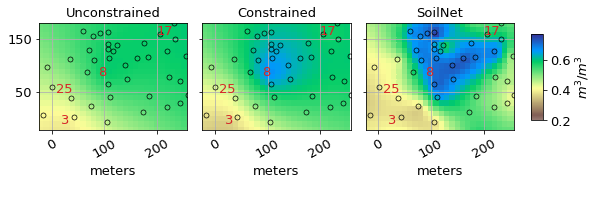

In [153]:
plt.rc('font', **{'size'   : 13})

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,4), sharey=True)
ax = ax.ravel()

vmin=0.2
vmax=0.77

cmap = plt.cm.terrain_r

plotday = dt.datetime(2019,6,7,0,0)
dtix = np.where(np.array(thedays)==plotday)[0][0]

def decoratesn(ax, title):
    plt.plot(snx, sny, lw=0, marker="o", mec="black", mfc="None", ms=5, mew=0.7)
    for id in [3,8,25,17,18,24]:
        text_object = ax.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                                   ha='center', va='center', color="tab:red")
    #plt.plot(attrs.loc[useids,"x"], attrs.loc[useids,"y"], lw=0, marker="o", mec="tab:red", mfc="None", ms=10, mew=2)
    plt.title(title, fontsize=13)
    plt.xticks(rotation=30)
    plt.grid()
    ax.ticklabel_format(axis="x", useOffset=654100)
    ax.ticklabel_format(axis="y", useOffset=5299650)
    plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
    plt.setp(ax.get_yaxis().get_offset_text(), visible=False)
    plt.xlim(snleft, snright)
    plt.ylim(snbottom+20, sntop-10)
    plt.xlabel("meters")
    

plt.sca(ax[0])
ax[0].set_aspect("equal")
p = plt.pcolormesh(sngrdxx, sngrdyy,
                   naiveip[dtix,snix].reshape(sngrdxx.shape),
                   vmin=vmin, vmax=vmax, cmap=mycmap)
decoratesn(ax[0], title="Unconstrained")



plt.sca(ax[1])
ax[1].set_aspect("equal")
p = plt.pcolormesh(sngrdxx, sngrdyy,
                   optimip[dtix,snix].reshape(sngrdxx.shape),
                   cmap=mycmap, vmin=vmin, vmax=vmax)
decoratesn(ax[1], title="Constrained")

plt.sca(ax[2])
ax[2].set_aspect("equal")
p = plt.pcolormesh(sngrdxx, sngrdyy,
#                   gaussian_filter(snip[dtix,:].reshape(sngrdxx.shape), sigma=0),
                   snip[dtix,:].reshape(sngrdxx.shape),
                   cmap=mycmap, vmin=vmin, vmax=vmax)
decoratesn(ax[2], title="SoilNet")

fig.subplots_adjust(right=0.95, wspace=0.1)
cbar_ax = fig.add_axes([0.98, 0.35, 0.02, 0.3])
cb = plt.colorbar(p, orientation="vertical", cax=cbar_ax)#use_gridspec=False, ax=ax)
cb.set_label("$m^3/m^3$")

#plt.tight_layout()

plt.savefig("figures/sncompare.png", dpi=300, bbox_inches="tight",pad_inches=0)

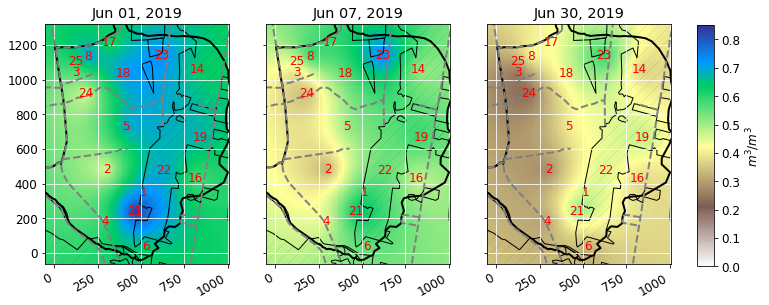

In [154]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5), sharey=True, sharex=True)
#ax = ax.ravel()

def decorate(ax, title):
    for id in useids:
        text_object = ax.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                                   ha='center', va='center', color="red")
    wradlib.vis.add_lines(ax, catborders, color='black', lw=2)
    wradlib.vis.add_lines(ax, roads, color='grey', ls="dashed", lw=2)
    for i in range(len(lut)):
        if lutkeys[i]=="forest":
            wradlib.vis.add_patches(ax, lut[i], hatch="//", facecolors="None")
    ax.ticklabel_format(axis="x", useOffset=654000)
    ax.grid(color="white")
    #tstamp = ax.set_title("")
    #cb = plt.colorbar(quad1, shrink=0.5)
    #cb.set_label("Theta (%)")
    plt.xlim(xx.min()+350, xx.max()-350)
    plt.ylim(yy.min()+250, yy.max()-250)
    plt.title(title)
    ax.ticklabel_format(axis="y", useOffset=5298600)
    plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
    plt.setp(ax.get_yaxis().get_offset_text(), visible=False)

wetdate = dt.datetime(2019,6,1,0,0)
mediumdate = dt.datetime(2019,6,7,0,0)
drydate = dt.datetime(2019,6,30,0,0)
ixwet = np.where(np.array(thedays)==wetdate)[0][0]
ixmedium = np.where(np.array(thedays)==mediumdate)[0][0]
ixdry = np.where(np.array(thedays)==drydate)[0][0]

vmax = 0.85

ax[0].set_aspect("equal")
plt.sca(ax[0])
axi=0
quad1 = ax[0].pcolormesh(xx, yy, naiveip[ixwet].reshape(xx.shape), vmin=0.0, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
decorate(ax[axi], title=wetdate.strftime("%b %d, %Y"))

axi = 1
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, naiveip[ixmedium].reshape(xx.shape), vmin=0.0, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
decorate(ax[axi], title=mediumdate.strftime("%b %d, %Y"))


axi = 2
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, naiveip[ixdry].reshape(xx.shape), vmin=0.0, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
decorate(ax[axi], title=drydate.strftime("%b %d, %Y"))

fig.autofmt_xdate() 

# fig.subplots_adjust(bottom=0.16)
# cbar_ax = fig.add_axes([0.3, 0.01, 0.4, 0.04])
# cb = plt.colorbar(quad1, orientation="horizontal", cax=cbar_ax)#use_gridspec=False, ax=ax)
# cb.set_label("$m^3/m^3$")

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.67])
cb = plt.colorbar(quad1, orientation="vertical", cax=cbar_ax)#use_gridspec=False, ax=ax)
cb.set_label("$m^3/m^3$")

plt.savefig("figures/mapsseries_naive.png", dpi=300, bbox_inches="tight")

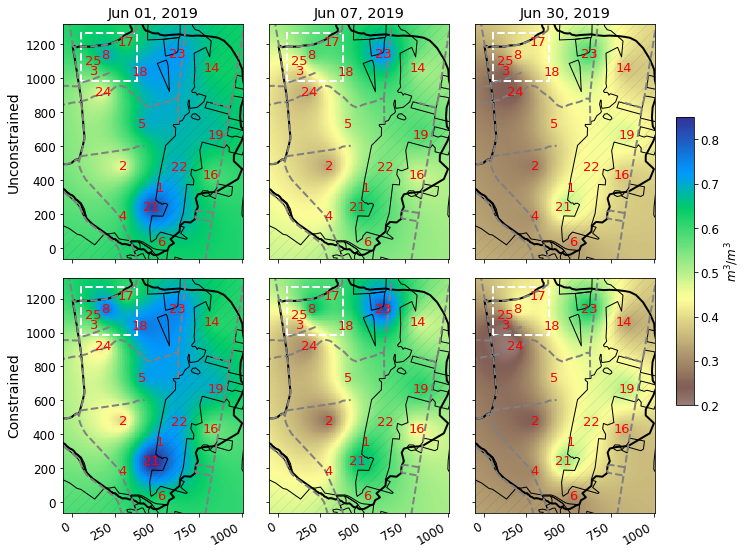

In [155]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,10), sharey=True, sharex=True)
ax = ax.ravel()

def decorate(ax, title, ylabel=""):
    visbuffer = 25
    rect = patches.Rectangle((snleft-visbuffer,snbottom-visbuffer),
                             2*visbuffer+snright-snleft,2*visbuffer+sntop-snbottom,linewidth=2, edgecolor='w',
                             facecolor='None', ls="dashed")
    ax.add_patch(rect)
    for id in useids:
        text_object = ax.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                                   ha='center', va='center', color="red", fontsize=13)
    wradlib.vis.add_lines(ax, catborders, color='black', lw=2)
    wradlib.vis.add_lines(ax, roads, color='grey', ls="dashed", lw=2)
    for i in range(len(lut)):
        if lutkeys[i]=="forest":
            wradlib.vis.add_patches(ax, lut[i], hatch="//", facecolors="None")
    ax.ticklabel_format(axis="x", useOffset=654000)
    #ax.grid(color="white")
    #tstamp = ax.set_title("")
    #cb = plt.colorbar(quad1, shrink=0.5)
    #cb.set_label("Theta (%)")
    plt.xlim(xx.min()+350, xx.max()-350)
    plt.ylim(yy.min()+250, yy.max()-250)
    plt.title(title)
    plt.ylabel(ylabel, fontsize=14)
    ax.ticklabel_format(axis="y", useOffset=5298600)
    plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
    plt.setp(ax.get_yaxis().get_offset_text(), visible=False)

wetdate = dt.datetime(2019,6,1,0,0)
mediumdate = dt.datetime(2019,6,7,0,0)
drydate = dt.datetime(2019,6,30,0,0)
ixwet = np.where(np.array(thedays)==wetdate)[0][0]
ixmedium = np.where(np.array(thedays)==mediumdate)[0][0]
ixdry = np.where(np.array(thedays)==drydate)[0][0]

vmax = 0.85

axi=0
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, naiveip[ixwet].reshape(xx.shape), 
                           vmin=0.2, vmax=vmax, shading="flat", cmap=mycmap)
decorate(ax[axi], title=wetdate.strftime("%b %d, %Y"), ylabel="Unconstrained")

axi = 1
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, naiveip[ixmedium].reshape(xx.shape), 
                           vmin=0.2, vmax=vmax, shading="flat", cmap=mycmap)
decorate(ax[axi], title=mediumdate.strftime("%b %d, %Y"))

axi = 2
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, naiveip[ixdry].reshape(xx.shape), 
                           vmin=0.2, vmax=vmax, shading="flat", cmap=mycmap)
decorate(ax[axi], title=drydate.strftime("%b %d, %Y"))

axi=3
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, optimip[ixwet].reshape(xx.shape),
                           vmin=0.2, vmax=vmax, shading="flat", cmap=mycmap)
decorate(ax[axi], title="", ylabel="Constrained")

axi = 4
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, optimip[ixmedium].reshape(xx.shape),
                           vmin=0.2, vmax=vmax, shading="flat", cmap=mycmap)
decorate(ax[axi], title="")

axi = 5
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
quad1 = ax[axi].pcolormesh(xx, yy, optimip[ixdry].reshape(xx.shape),
                           vmin=0.2, vmax=vmax, shading="flat", cmap=mycmap)
decorate(ax[axi], title="")

fig.autofmt_xdate() 

# fig.subplots_adjust(bottom=0.16)
# cbar_ax = fig.add_axes([0.3, 0.01, 0.4, 0.04])
# cb = plt.colorbar(quad1, orientation="horizontal", cax=cbar_ax)#use_gridspec=False, ax=ax)
# cb.set_label("$m^3/m^3$")

fig.subplots_adjust(wspace=0.0, hspace=0.08, right=0.84)
cbar_ax = fig.add_axes([0.85, 0.35, 0.02, 0.4])
cb = plt.colorbar(quad1, orientation="vertical", cax=cbar_ax)#use_gridspec=False, ax=ax)
cb.set_label("$m^3/m^3$")

plt.savefig("figures/mapsseries_constr_vs_unconstr.png", dpi=300, bbox_inches="tight")

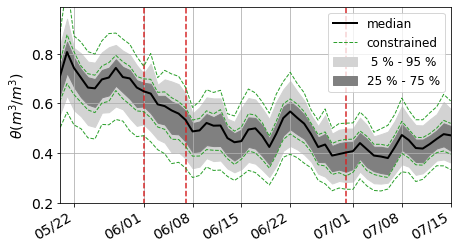

In [156]:
plt.rc('font', **{'size'   : 14})

wetdate = dt.datetime(2019,6,1,0,0)
mediumdate = dt.datetime(2019,6,7,0,0)
drydate = dt.datetime(2019,6,30,0,0)
ixwet = np.where(sli.index==wetdate)[0][0]
ixmedium = np.where(sli.index==mediumdate)[0][0]
ixdry = np.where(sli.index==drydate)[0][0]


fig, ax = plt.subplots(figsize=(7,4))
catmask = np.zeros(xx.size).astype("bool")
catmask[cat_ix] = True
naivemasked = naiveip.copy()
naivemasked[:,~catmask] = np.nan
naiveavgtheta = np.nanmean(naivemasked, axis=1)
optimmasked = optimip.copy()
optimmasked[:,~catmask] = np.nan
optimavgtheta = np.nanmean(optimmasked, axis=1)

#avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan
#lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
#fullcovpl = plt.plot(sli.index, avgtheta, label="Avg. theta (%)", color="black")
#lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
qu0595 = plt.fill_between(thedays, np.nanquantile(naivemasked, 0.05, axis=1), np.nanquantile(naivemasked, 0.95, axis=1),
                            label=" 5 % - 95 %", color="lightgrey")
qu2575 = plt.fill_between(thedays, np.nanquantile(naivemasked, 0.25, axis=1), np.nanquantile(naivemasked, 0.75, axis=1),
                            label="25 % - 75 %", color="grey")
median = plt.plot(thedays, np.nanmedian(naivemasked, axis=1), label="median", color="black", lw=2)
qu05o = plt.plot(thedays, np.nanquantile(optimmasked, 0.05, axis=1), label="constrained", color="tab:green", ls="--", lw=1)
qu95o = plt.plot(thedays, np.nanquantile(optimmasked, 0.95, axis=1), label="_tmp", color="tab:green",  ls="--", lw=1)
qu75o = plt.plot(thedays, np.nanquantile(optimmasked, 0.75, axis=1), label="_tmp", color="tab:green",  ls="--", lw=1)
qu25o = plt.plot(thedays, np.nanquantile(optimmasked, 0.25, axis=1), label="_tmp", color="tab:green",  ls="--", lw=1)

#mediano = plt.plot(thedays, np.nanmedian(optimmasked, axis=1), label="_tmp", color="tab:green",  ls="--", lw=2)
plt.xlim(xlim)
plt.vlines([wetdate, mediumdate, drydate], ymin=0, ymax=1, color="tab:red", ls="dashed")
plt.ylim(0.2,0.99)

plt.ylabel(r"$\theta (m^3$/$m^3)$")
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.legend(fontsize=12)
plt.xlim(dt.datetime(2019,5,20), dt.datetime(2019,7,15))

fig.autofmt_xdate()

plt.savefig("figures/areal_sm_distr_series.pdf", dpi=300, bbox_inches="tight")

# Export to netcdf

In [157]:
ds_theta_naiveip = xarray.Dataset(data_vars={'theta': (('datetime', 'y', 'x'),
                                               naiveip.reshape((-1, xx.shape[0], xx.shape[1])))},
                          coords={'x': xx[0], 'y':yy[:,0], 'datetime': thedays},
                          attrs={"epsg": "32632",
                                 "unit_theta":"m3/m3",
                                 "unit_coords":"meters",
                                 "tz":"UTC",
                                 "timeref":"end_of_interval",
                                 "starttime": thedays[0].isoformat(),
                                 "endtime": thedays[-1].isoformat()})

ds_theta_optimip = xarray.Dataset(data_vars={'theta': (('datetime', 'y', 'x'),
                                               optimip.reshape((-1, xx.shape[0], xx.shape[1])))},
                          coords={'x': xx[0], 'y':yy[:,0], 'datetime': thedays},
                          attrs={"epsg": "32632",
                                 "unit_theta":"m3/m3",
                                 "unit_coords":"meters",
                                 "tz":"UTC",
                                 "timeref":"end_of_interval",
                                 "starttime": thedays[0].isoformat(),
                                 "endtime": thedays[-1].isoformat()})

In [158]:
#fig, ax = plt.subplots(nrows=1, ncols=1)
#ax.set_aspect("equal")
#ds_theta_optimip.theta[23].plot(cmap=mycmap, vmin=0.2, vmax=0.85)
#plt.xlim(xx.min()+350, xx.max()-350)
#plt.ylim(yy.min()+250, yy.max()-250)

In [159]:
# ds_theta_naiveip.to_netcdf("/home/maik/b2drop/cosmicsense/inbox/fendt/products/mc/theta_from_cph_grids_unconstrained.v0_1.nc",
#                   encoding={"theta":{'zlib': True, 'complevel': 9}})

# ds_theta_optimip.to_netcdf("/home/maik/b2drop/cosmicsense/inbox/fendt/products/mc/theta_from_cph_grids_constrained.v0_1.nc",
#                   encoding={"theta":{'zlib': True, 'complevel': 9}})